# Metro Bike Share Analysis Project

### This notebook analyzes Metro Bike Share data to provide insights for
### Operational improvements, business strategy, and customer experience optimization.

### SETUP AND DATA LOADING

In [66]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import FancyArrowPatch, Rectangle

# Geospatial analysis
import plotly.express as px
import plotly.graph_objects as go

# Database connection
import duckdb as ddb

# Statistical analysis
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

# Utilities
from datetime import datetime
import missingno as msno
import os
import warnings
import urllib.request
from math import radians, cos, sin, asin, sqrt

# Suppress warnings
warnings.filterwarnings('ignore')

### Configure display and visualization settings

In [67]:
# Define consistent visualization settings
def set_visualization_defaults():
    """Set consistent styling for all visualizations"""
    # Base settings
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.2)
    
    # Figure size and fonts
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Text sizing
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['figure.titlesize'] = 18
    
    # Define color palettes for different analysis types
    palettes = {
        'temporal': sns.color_palette("viridis", 12),
        'user': sns.color_palette("Set2", 8),
        'comparison': sns.color_palette("RdYlBu_r", 10),
        'business': sns.color_palette("YlGnBu", 8),
        'categorical': sns.color_palette("tab10")
    }
    
    return palettes

# Initialize visualization settings
palettes = set_visualization_defaults()

### Connect to database

In [68]:
# Connect to database and check available tables
con = ddb.connect('../data/processed/metro_bike_share.duckdb')
con

Perfect we have a successfull connection

In [69]:
# Check available tables
tables = con.execute("SHOW TABLES").df()
print("\nAvailable tables in database:")
print(tables)


Available tables in database:
                  name
0             stations
1                trips
2  trips_with_stations


In [70]:
# Load stations data
stations = con.execute("SELECT * FROM stations").df()
print(f"Loaded {len(stations)} station records")

Loaded 219 station records


In [71]:
# Check for missing values in stations data
missing_values = stations.isnull().sum()
missing_percentage = (missing_values / len(stations)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])
print("\nMissing Values in Stations Data:")
print(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))



Missing Values in Stations Data:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


In [72]:
# Display station data sample
stations.head()

station_id    station_name station_city station_zip          station_lat  \
0        3005    7th & Flower         DTLA       90017                34.05   
1        3006     Olive & 8th         DTLA       90014                34.05   
2        3007     5th & Grand         DTLA       90071                34.05   
3        3008  Figueroa & 9th         DTLA       90017                34.05   
4        3010    11th & Maple         DTLA       90015                34.04   

           station_lon  total_docks  bikes_available  docks_available  \
0              -118.26           31               21               10   
1              -118.26           31               14               17   
2              -118.25           23               11               12   
3              -118.26           15                4               11   
4              -118.25           15                4               11   

   classic_bikes_available  smart_bikes_available  electric_bikes_available  
0                       20                      0                         1  
1                       14                      0                         0  
2                       10                      0                         1  
3                        4                      0                         0  
4                        4                      0                         0

In [73]:
# Load trips data
trips = con.execute("SELECT * FROM trips").df()
print(f"Loaded {len(trips)} trip records")

Loaded 1292202 trip records


In [74]:
# Check for missing values in trips data
missing_values = trips.isnull().sum()
missing_percentage = (missing_values / len(trips)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])

print("\nMissing Values in Trips Data:")
print(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


Missing Values in Trips Data:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


In [75]:
# Display trips data sample
trips.head()

trip_id             duration          start_time  \
0          33404951.00                36.00 2017-07-01 00:09:00   
1          33404950.00                13.00 2017-07-01 00:10:00   
2          33404947.00                34.00 2017-07-01 00:11:00   
3          33404948.00                34.00 2017-07-01 00:11:00   
4          33404949.00                12.00 2017-07-01 00:11:00   

             end_time        start_station            start_lat  \
0 2017-07-01 00:45:00              3018.00                34.04   
1 2017-07-01 00:23:00              3055.00                34.04   
2 2017-07-01 00:45:00              3018.00                34.04   
3 2017-07-01 00:45:00              3018.00                34.04   
4 2017-07-01 00:23:00              3055.00                34.04   

             start_lon          end_station              end_lat  \
0              -118.26              3018.00                34.04   
1              -118.25              3082.00                34.05   
2              -118.26              3018.00                34.04   
3              -118.26              3018.00                34.04   
4              -118.25              3082.00                34.05   

               end_lon bike_id passholder_type trip_route_category bike_type  \
0              -118.26    5996         Walk-up          Round Trip   Unknown   
1              -118.24    5777         Walk-up             One Way   Unknown   
2              -118.26    6342         Walk-up          Round Trip   Unknown   
3              -118.26    6478         Walk-up          Round Trip   Unknown   
4              -118.24    6411         Walk-up             One Way   Unknown   

         plan_duration  trip_hour  trip_dayofweek  is_weekend  trip_date  \
0                 0.00          0               5        True 2017-07-01   
1                 0.00          0               5        True 2017-07-01   
2                 0.00          0               5        True 2017-07-01   
3                 0.00          0               5        True 2017-07-01   
4                 0.00          0               5        True 2017-07-01   

      trip_distance_km      trip_speed_kmph duration_bin  is_subscriber  
0                 0.00                 0.00       30-60m          False  
1                 1.33                 6.16        5-15m          False  
2                 0.00                 0.00       30-60m          False  
3                 0.00                 0.00       30-60m          False  
4                 1.33                 6.67        5-15m          False

In [76]:
# Confirm date range in the dataset
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
time_range = (trips['start_time'].min(), trips['start_time'].max())
print(f"\nTime range in dataset: {time_range[0]} to {time_range[1]}")


Time range in dataset: 2017-01-01 00:15:00 to 2024-12-31 23:47:00


In [77]:
# Define helper functions for later use

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# DATA PREPARATION AND CLEANING

### Create complete merged dataset with both start and end station information

In [78]:
# First merge start station data
df_start = trips.merge(
    stations,
    how="left",
    left_on="start_station",
    right_on="station_id",
    suffixes=("", "_start")
).drop(columns=["station_id"])

In [79]:
df_start.head()

trip_id             duration          start_time  \
0          33404951.00                36.00 2017-07-01 00:09:00   
1          33404950.00                13.00 2017-07-01 00:10:00   
2          33404947.00                34.00 2017-07-01 00:11:00   
3          33404948.00                34.00 2017-07-01 00:11:00   
4          33404949.00                12.00 2017-07-01 00:11:00   

             end_time        start_station            start_lat  \
0 2017-07-01 00:45:00              3018.00                34.04   
1 2017-07-01 00:23:00              3055.00                34.04   
2 2017-07-01 00:45:00              3018.00                34.04   
3 2017-07-01 00:45:00              3018.00                34.04   
4 2017-07-01 00:23:00              3055.00                34.04   

             start_lon          end_station              end_lat  \
0              -118.26              3018.00                34.04   
1              -118.25              3082.00                34.05   
2              -118.26              3018.00                34.04   
3              -118.26              3018.00                34.04   
4              -118.25              3082.00                34.05   

               end_lon bike_id passholder_type trip_route_category bike_type  \
0              -118.26    5996         Walk-up          Round Trip   Unknown   
1              -118.24    5777         Walk-up             One Way   Unknown   
2              -118.26    6342         Walk-up          Round Trip   Unknown   
3              -118.26    6478         Walk-up          Round Trip   Unknown   
4              -118.24    6411         Walk-up             One Way   Unknown   

         plan_duration  trip_hour  trip_dayofweek  is_weekend  trip_date  \
0                 0.00          0               5        True 2017-07-01   
1                 0.00          0               5        True 2017-07-01   
2                 0.00          0               5        True 2017-07-01   
3                 0.00          0               5        True 2017-07-01   
4                 0.00          0               5        True 2017-07-01   

      trip_distance_km      trip_speed_kmph duration_bin  is_subscriber  \
0                 0.00                 0.00       30-60m          False   
1                 1.33                 6.16        5-15m          False   
2                 0.00                 0.00       30-60m          False   
3                 0.00                 0.00       30-60m          False   
4                 1.33                 6.67        5-15m          False   

      station_name station_city station_zip          station_lat  \
0  Grand & Olympic         DTLA       90015                34.04   
1              NaN          NaN         NaN                  NaN   
2  Grand & Olympic         DTLA       90015                34.04   
3  Grand & Olympic         DTLA       90015                34.04   
4              NaN          NaN         NaN                  NaN   

           station_lon          total_docks      bikes_available  \
0              -118.26                19.00                 2.00   
1                  NaN                  NaN                  NaN   
2              -118.26                19.00                 2.00   
3              -118.26                19.00                 2.00   
4                  NaN                  NaN                  NaN   

       docks_available  classic_bikes_available  smart_bikes_available  \
0                17.00                     2.00                   0.00   
1                  NaN                      NaN                    NaN   
2                17.00                     2.00                   0.00   
3                17.00                     2.00                   0.00   
4                  NaN                      NaN                    NaN   

   electric_bikes_available  
0                      0.00  
1                       NaN  
2                      0.00  
3                      0.00 

In [80]:
# Now merge end station information
df_end = df_start.merge(
    stations,
    how="left",
    left_on="end_station",
    right_on="station_id",
    suffixes=("", "_end")
).drop(columns=["station_id"])

In [81]:
df_end.head()

trip_id             duration          start_time  \
0          33404951.00                36.00 2017-07-01 00:09:00   
1          33404950.00                13.00 2017-07-01 00:10:00   
2          33404947.00                34.00 2017-07-01 00:11:00   
3          33404948.00                34.00 2017-07-01 00:11:00   
4          33404949.00                12.00 2017-07-01 00:11:00   

             end_time        start_station            start_lat  \
0 2017-07-01 00:45:00              3018.00                34.04   
1 2017-07-01 00:23:00              3055.00                34.04   
2 2017-07-01 00:45:00              3018.00                34.04   
3 2017-07-01 00:45:00              3018.00                34.04   
4 2017-07-01 00:23:00              3055.00                34.04   

             start_lon          end_station              end_lat  \
0              -118.26              3018.00                34.04   
1              -118.25              3082.00                34.05   
2              -118.26              3018.00                34.04   
3              -118.26              3018.00                34.04   
4              -118.25              3082.00                34.05   

               end_lon bike_id passholder_type trip_route_category bike_type  \
0              -118.26    5996         Walk-up          Round Trip   Unknown   
1              -118.24    5777         Walk-up             One Way   Unknown   
2              -118.26    6342         Walk-up          Round Trip   Unknown   
3              -118.26    6478         Walk-up          Round Trip   Unknown   
4              -118.24    6411         Walk-up             One Way   Unknown   

         plan_duration  trip_hour  trip_dayofweek  is_weekend  trip_date  \
0                 0.00          0               5        True 2017-07-01   
1                 0.00          0               5        True 2017-07-01   
2                 0.00          0               5        True 2017-07-01   
3                 0.00          0               5        True 2017-07-01   
4                 0.00          0               5        True 2017-07-01   

      trip_distance_km      trip_speed_kmph duration_bin  is_subscriber  \
0                 0.00                 0.00       30-60m          False   
1                 1.33                 6.16        5-15m          False   
2                 0.00                 0.00       30-60m          False   
3                 0.00                 0.00       30-60m          False   
4                 1.33                 6.67        5-15m          False   

      station_name station_city station_zip          station_lat  \
0  Grand & Olympic         DTLA       90015                34.04   
1              NaN          NaN         NaN                  NaN   
2  Grand & Olympic         DTLA       90015                34.04   
3  Grand & Olympic         DTLA       90015                34.04   
4              NaN          NaN         NaN                  NaN   

           station_lon          total_docks      bikes_available  \
0              -118.26                19.00                 2.00   
1                  NaN                  NaN                  NaN   
2              -118.26                19.00                 2.00   
3              -118.26                19.00                 2.00   
4                  NaN                  NaN                  NaN   

       docks_available  classic_bikes_available  smart_bikes_available  \
0                17.00                     2.00                   0.00   
1                  NaN                      NaN                    NaN   
2                17.00                     2.00                   0.00   
3                17.00                     2.00                   0.00   
4                  NaN                      NaN                    NaN   

   electric_bikes_available station_name_end station_city_end station_zip_end  \
0                      0.00  Grand & Olympic             DTLA      

In [82]:
# Check the shapes of source and merged dataframes
print("Data shapes:")
print(f"- Trips data: {trips.shape} (rows, columns)")
print(f"- Stations data: {stations.shape} (rows, columns)")
print(f"- Complete merged data: {df_start.shape} (rows, columns)")
print(f"- Complete merged data: {df_end.shape} (rows, columns)")

Data shapes:
- Trips data: (1292202, 23) (rows, columns)
- Stations data: (219, 12) (rows, columns)
- Complete merged data: (1292202, 34) (rows, columns)
- Complete merged data: (1292202, 45) (rows, columns)


In [83]:
df_merged = df_end.copy()

In [84]:
# Examine the merged dataset
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292202 entries, 0 to 1292201
Data columns (total 45 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   trip_id                       1292202 non-null  float64       
 1   duration                      1292202 non-null  float64       
 2   start_time                    1292202 non-null  datetime64[ns]
 3   end_time                      1292202 non-null  datetime64[ns]
 4   start_station                 1292202 non-null  float64       
 5   start_lat                     1292202 non-null  float64       
 6   start_lon                     1292202 non-null  float64       
 7   end_station                   1292202 non-null  float64       
 8   end_lat                       1292202 non-null  float64       
 9   end_lon                       1292202 non-null  float64       
 10  bike_id                       1292202 non-null  object        
 11

In [85]:
# Check for missing values in the merged dataset
missing_values = df_merged.isnull().sum()
missing_percentage = (missing_values / len(df_merged)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])

print("\nMissing Values in Merged Dataset:")
missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
missing_data


Missing Values in Merged Dataset:


Missing Values       Percentage (%)
station_name_end                      100682                 7.79
station_city_end                      100682                 7.79
smart_bikes_available_end             100682                 7.79
classic_bikes_available_end           100682                 7.79
docks_available_end                   100682                 7.79
bikes_available_end                   100682                 7.79
total_docks_end                       100682                 7.79
station_lon_end                       100682                 7.79
station_lat_end                       100682                 7.79
station_zip_end                       100682                 7.79
electric_bikes_available_end          100682                 7.79
station_city                           80453                 6.23
electric_bikes_available               80453                 6.23
smart_bikes_available                  80453                 6.23
classic_bikes_available                80453                 6.23
docks_available                        80453                 6.23
bikes_available                        80453                 6.23
total_docks                            80453                 6.23
station_lon                            80453                 6.23
station_lat                            80453                 6.23
station_zip                            80453                 6.23
station_name                           80453                 6.23

<Figure size 1400x600 with 0 Axes>

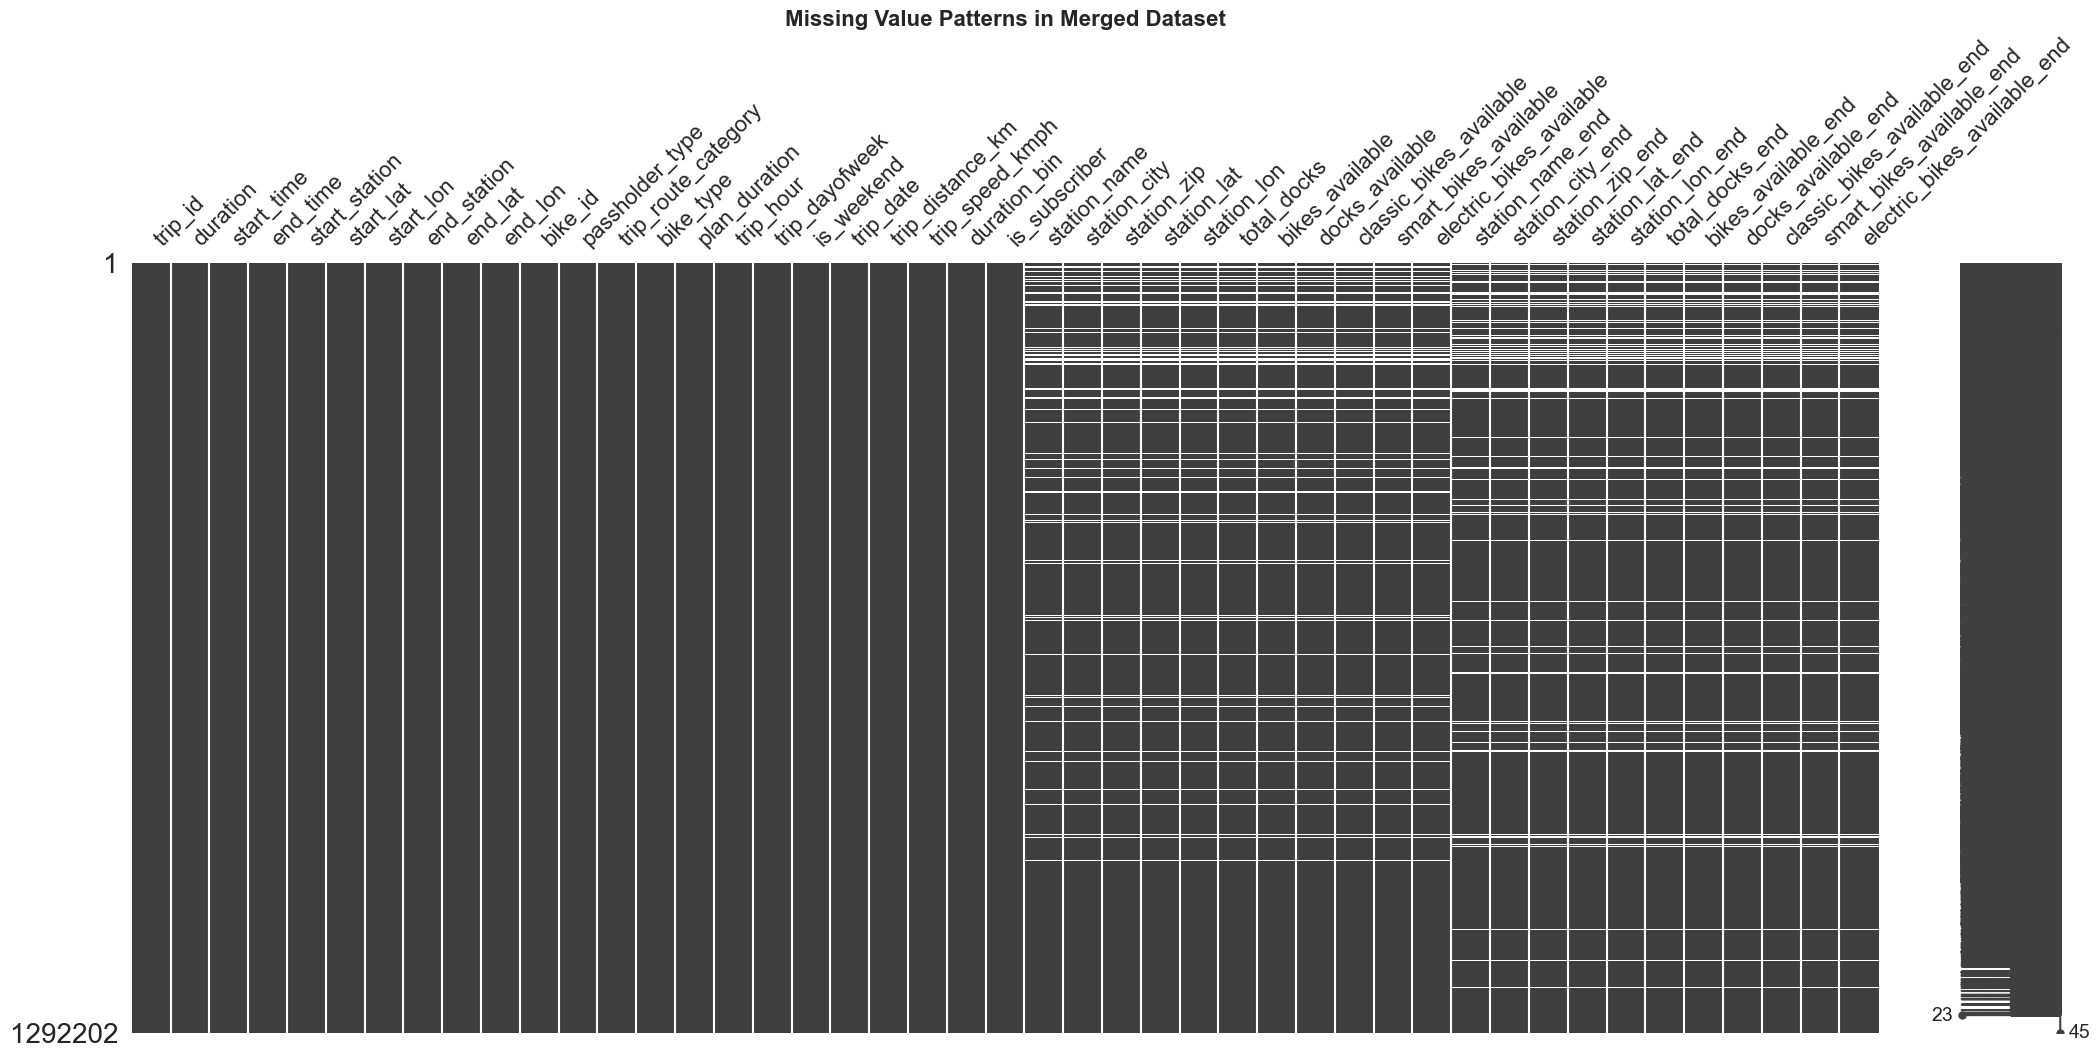

In [86]:
# Visualize missing value patterns
plt.figure(figsize=(14, 6))
msno.matrix(df_merged)
plt.title("Missing Value Patterns in Merged Dataset")
plt.tight_layout()
plt.show()

1. **Start Station Missing Values (~36%)**: 
- About 36% of rows have missing values for station_name, station_city, station_lat, station_lon, etc. 
- This suggests these trips have valid start_station IDs, but those IDs don't have matches in your stations table.

2. **End Station Missing Values (~28%)**: 
- About 28% of rows have missing values for station_name_end, station_city_end, etc. 
- This percentage is different from the start station missing values, which is interesting.

This pattern suggests:
- Some station IDs in your trips table may not exist in your stations table
- You might have data from different time periods with different active stations
- There could be temporary or pop-up stations not fully recorded in the stations table

## Clean missing values in the merged dataset

### Handle These Missing Values

In [87]:
def fill_missing_station_names(df):
    """
    Fill missing station names with their station IDs as fallback
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        DataFrame with filled station names
    """
    print("Filling missing station names with station IDs...")
    
    # For missing station names, use the station ID as a fallback
    df['station_name'] = df['station_name'].fillna('Station ID: ' + df['start_station'].astype(str))
    df['station_name_end'] = df['station_name_end'].fillna('Station ID: ' + df['end_station'].astype(str))
    
    return df


def create_station_lookup_dictionaries(df):
    """
    Create lookup dictionaries for station data from non-missing records
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        Tuple of (start_station_coords, end_station_coords) dictionaries
    """
    print("Creating station lookup dictionaries...")
    
    # Create lookup dictionaries for station data
    start_station_coords = {}
    end_station_coords = {}
    
    # Build lookup dictionary from start stations
    for _, row in df[~df['station_lat'].isna()].iterrows():
        start_station_coords[row['start_station']] = {
            'lat': row['station_lat'],
            'lon': row['station_lon'],
            'total_docks': row['total_docks'],
            'city': row['station_city']
        }
    
    # Build lookup dictionary from end stations
    for _, row in df[~df['station_lat_end'].isna()].iterrows():
        end_station_coords[row['end_station']] = {
            'lat': row['station_lat_end'],
            'lon': row['station_lon_end'],
            'total_docks': row['total_docks_end'],
            'city': row['station_city_end']
        }
    
    print(f"Created lookup dictionaries with {len(start_station_coords)} start stations and {len(end_station_coords)} end stations")
    
    return start_station_coords, end_station_coords


def fill_from_station_lookups(df, start_station_coords, end_station_coords):
    """
    Fill missing station data using the lookup dictionaries
    
    Args:
        df: DataFrame with merged trip and station data
        start_station_coords: Dictionary mapping start station IDs to their data
        end_station_coords: Dictionary mapping end station IDs to their data
        
    Returns:
        DataFrame with filled values from lookups
    """
    # Fill in missing start station records
    missing_start_idx = df[df['station_lat'].isna()].index
    print(f"Filling in {len(missing_start_idx)} missing start station records...")
    
    filled_count = 0
    for idx in missing_start_idx:
        station_id = df.loc[idx, 'start_station']
        if station_id in start_station_coords:
            df.loc[idx, 'station_lat'] = start_station_coords[station_id]['lat']
            df.loc[idx, 'station_lon'] = start_station_coords[station_id]['lon']
            df.loc[idx, 'total_docks'] = start_station_coords[station_id]['total_docks']
            df.loc[idx, 'station_city'] = start_station_coords[station_id]['city']
            filled_count += 1
    
    print(f"Successfully filled {filled_count} start station records using station ID lookups")
    
    # Fill in missing end station records
    missing_end_idx = df[df['station_lat_end'].isna()].index
    print(f"Filling in {len(missing_end_idx)} missing end station records...")
    
    filled_count = 0
    for idx in missing_end_idx:
        station_id = df.loc[idx, 'end_station']
        if station_id in end_station_coords:
            df.loc[idx, 'station_lat_end'] = end_station_coords[station_id]['lat']
            df.loc[idx, 'station_lon_end'] = end_station_coords[station_id]['lon']
            df.loc[idx, 'total_docks_end'] = end_station_coords[station_id]['total_docks']
            df.loc[idx, 'station_city_end'] = end_station_coords[station_id]['city']
            filled_count += 1
    
    print(f"Successfully filled {filled_count} end station records using station ID lookups")
    
    return df


def fill_numeric_columns(df):
    """
    Fill remaining missing numeric values with column means
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        DataFrame with filled numeric columns
    """
    print("Filling remaining missing numeric values with means...")
    
    # Start station numeric columns
    start_numeric_cols = ['total_docks', 'bikes_available', 'docks_available', 
                         'classic_bikes_available', 'smart_bikes_available', 'electric_bikes_available']
    
    for col in start_numeric_cols:
        if col in df.columns and df[col].isna().any():
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"Filled remaining missing values in {col} with mean: {mean_val:.2f}")
    
    # End station numeric columns
    end_numeric_cols = ['total_docks_end', 'bikes_available_end', 'docks_available_end', 
                       'classic_bikes_available_end', 'smart_bikes_available_end', 'electric_bikes_available_end']
    
    for col in end_numeric_cols:
        if col in df.columns and df[col].isna().any():
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"Filled remaining missing values in {col} with mean: {mean_val:.2f}")
    
    return df


def fill_categorical_columns(df):
    """
    Fill remaining missing categorical values with column modes
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        DataFrame with filled categorical columns
    """
    print("Filling remaining missing categorical values with modes...")
    
    # Start station categorical columns
    start_cat_cols = ['station_city', 'station_zip']
    
    for col in start_cat_cols:
        if col in df.columns and df[col].isna().any():
            mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled remaining missing values in {col} with mode: {mode_val}")
    
    # End station categorical columns
    end_cat_cols = ['station_city_end', 'station_zip_end']
    
    for col in end_cat_cols:
        if col in df.columns and df[col].isna().any():
            mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled remaining missing values in {col} with mode: {mode_val}")
    
    return df


def create_unified_station_lookup(df):
    """
    Create a unified station lookup dictionary by combining start and end station data
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        Dictionary mapping station IDs to their data
    """
    print("Creating unified station lookup dictionary...")
    
    station_data = {}
    
    # Collect all station data from start stations
    for _, row in df[~df['station_lat'].isna()].iterrows():
        station_id = row['start_station']
        if station_id not in station_data:
            station_data[station_id] = {
                'lat': row['station_lat'],
                'lon': row['station_lon'],
                'total_docks': row['total_docks'],
                'city': row['station_city'],
                'name': row['station_name']
            }
    
    # Add any end station data we don't already have
    for _, row in df[~df['station_lat_end'].isna()].iterrows():
        station_id = row['end_station']
        if station_id not in station_data:
            station_data[station_id] = {
                'lat': row['station_lat_end'],
                'lon': row['station_lon_end'],
                'total_docks': row['total_docks_end'],
                'city': row['station_city_end'],
                'name': row['station_name_end']
            }
    
    print(f"Created unified lookup table with {len(station_data)} unique stations")
    
    return station_data


def fill_from_unified_lookup(df, station_data):
    """
    Fill missing station data using the unified lookup dictionary
    
    Args:
        df: DataFrame with merged trip and station data
        station_data: Dictionary mapping station IDs to their data
        
    Returns:
        DataFrame with filled values from unified lookup,
        tuple of (missing_start, missing_end) DataFrames for tracking
    """
    # Fill missing start station data
    missing_start = df[df['station_lat'].isna()]
    print(f"Filling {len(missing_start)} missing start station records...")
    
    # Count how many we can fill from our lookup
    fillable_start = sum(1 for station_id in missing_start['start_station'] if station_id in station_data)
    print(f"We can fill {fillable_start} of {len(missing_start)} missing start stations")
    
    # Fill start station data where we have a match
    for idx, row in missing_start.iterrows():
        station_id = row['start_station']
        if station_id in station_data:
            df.loc[idx, 'station_lat'] = station_data[station_id]['lat']
            df.loc[idx, 'station_lon'] = station_data[station_id]['lon']
            df.loc[idx, 'total_docks'] = station_data[station_id]['total_docks']
            df.loc[idx, 'station_city'] = station_data[station_id]['city']
            df.loc[idx, 'station_name'] = station_data[station_id]['name']
    
    # Fill missing end station data
    missing_end = df[df['station_lat_end'].isna()]
    print(f"Filling {len(missing_end)} missing end station records...")
    
    # Count how many we can fill from our lookup
    fillable_end = sum(1 for station_id in missing_end['end_station'] if station_id in station_data)
    print(f"We can fill {fillable_end} of {len(missing_end)} missing end stations")
    
    # Fill end station data where we have a match
    for idx, row in missing_end.iterrows():
        station_id = row['end_station']
        if station_id in station_data:
            df.loc[idx, 'station_lat_end'] = station_data[station_id]['lat']
            df.loc[idx, 'station_lon_end'] = station_data[station_id]['lon']
            df.loc[idx, 'total_docks_end'] = station_data[station_id]['total_docks']
            df.loc[idx, 'station_city_end'] = station_data[station_id]['city']
            df.loc[idx, 'station_name_end'] = station_data[station_id]['name']
    
    return df, missing_start, missing_end


def fill_remaining_missing_values(df):
    """
    Fill any remaining missing values with system-wide means/modes
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        DataFrame with all missing values filled
    """
    print("Filling remaining missing values...")
    
    # Calculate system-wide means/modes for fallback values
    mean_lat = df['station_lat'].mean()
    mean_lon = df['station_lon'].mean()
    mean_total_docks = df['total_docks'].mean()
    mode_city = df['station_city'].mode().iloc[0] if not df['station_city'].mode().empty else "Unknown"
    
    print(f"System-wide means: lat={mean_lat:.4f}, lon={mean_lon:.4f}, docks={mean_total_docks:.1f}")
    print(f"Most common city: {mode_city}")
    
    # Fill remaining missing start station coordinates
    df['station_lat'].fillna(mean_lat, inplace=True)
    df['station_lon'].fillna(mean_lon, inplace=True)
    df['total_docks'].fillna(mean_total_docks, inplace=True)
    df['station_city'].fillna(mode_city, inplace=True)
    
    # Fill remaining missing end station coordinates
    df['station_lat_end'].fillna(mean_lat, inplace=True)
    df['station_lon_end'].fillna(mean_lon, inplace=True)
    df['total_docks_end'].fillna(mean_total_docks, inplace=True)
    df['station_city_end'].fillna(mode_city, inplace=True)
    
    # Fill any remaining missing values for all other columns
    for col in df.columns:
        if df[col].isna().any():
            if df[col].dtype.kind in 'ifc':  # Integer, float, or complex
                df[col].fillna(df[col].mean(), inplace=True)
                print(f"Filled remaining missing values in {col} with mean")
            else:  # Object or categorical
                df[col].fillna("Unknown", inplace=True)
                print(f"Filled remaining missing values in {col} with 'Unknown'")
    
    return df


def add_imputation_flags(df, missing_start, missing_end):
    """
    Add flags to indicate which records had imputed values
    
    Args:
        df: DataFrame with merged trip and station data
        missing_start: DataFrame of records with missing start station data
        missing_end: DataFrame of records with missing end station data
        
    Returns:
        DataFrame with imputation flags added
    """
    print("Adding imputation flags...")
    
    # Create imputation flags
    df['start_station_imputed'] = df['start_station'].isin(missing_start['start_station'].unique())
    df['end_station_imputed'] = df['end_station'].isin(missing_end['end_station'].unique())
    
    # Print summary statistics
    print(f"\nTotal trips: {len(df)}")
    print(f"Trips with imputed start stations: {df['start_station_imputed'].sum()} ({df['start_station_imputed'].mean()*100:.1f}%)")
    print(f"Trips with imputed end stations: {df['end_station_imputed'].sum()} ({df['end_station_imputed'].mean()*100:.1f}%)")
    
    return df


def check_missing_values(df, stage=""):
    """
    Check and report missing values in the DataFrame
    
    Args:
        df: DataFrame to check
        stage: Description of the current cleaning stage
        
    Returns:
        Series with counts of missing values
    """
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if len(missing) > 0:
        print(f"\nMissing values {stage}:")
        print(missing)
    else:
        print(f"\nNo missing values {stage}!")
    
    return missing

In [88]:
def clean_bike_share_data(df):
    """
    Main function to clean the Metro Bike Share dataset
    
    Args:
        df: DataFrame with merged trip and station data
        
    Returns:
        Cleaned DataFrame with no missing values
    """
    print("Starting comprehensive data cleaning process...")
    
    # Check initial missing values
    check_missing_values(df, "before cleaning")
    
    # Step 1: Fill missing station names with IDs
    df = fill_missing_station_names(df)
    
    # Step 2: Create station lookup dictionaries
    start_station_coords, end_station_coords = create_station_lookup_dictionaries(df)
    
    # Step 3: Fill from individual station lookups
    df = fill_from_station_lookups(df, start_station_coords, end_station_coords)
    
    # Step 4: Fill numeric columns with means
    df = fill_numeric_columns(df)
    
    # Step 5: Fill categorical columns with modes
    df = fill_categorical_columns(df)
    
    # Check missing values after basic cleaning
    check_missing_values(df, "after basic cleaning")
    
    # Step 6: Create unified station lookup
    station_data = create_unified_station_lookup(df)
    
    # Step 7: Fill from unified lookup
    df, missing_start, missing_end = fill_from_unified_lookup(df, station_data)
    
    # Step 8: Fill any remaining missing values
    df = fill_remaining_missing_values(df)
    
    # Step 9: Add imputation flags
    df = add_imputation_flags(df, missing_start, missing_end)
    
    # Final check for missing values
    check_missing_values(df, "after comprehensive cleaning")
    
    print("Data cleaning complete!")
    return df

In [89]:
df_merged = clean_bike_share_data(df_merged)

Starting comprehensive data cleaning process...

Missing values before cleaning:
station_name                     80453
station_city                     80453
station_zip                      80453
station_lat                      80453
station_lon                      80453
total_docks                      80453
bikes_available                  80453
docks_available                  80453
classic_bikes_available          80453
smart_bikes_available            80453
electric_bikes_available         80453
station_name_end                100682
station_city_end                100682
station_zip_end                 100682
station_lat_end                 100682
station_lon_end                 100682
total_docks_end                 100682
bikes_available_end             100682
docks_available_end             100682
classic_bikes_available_end     100682
smart_bikes_available_end       100682
electric_bikes_available_end    100682
dtype: int64
Filling missing station names with station IDs..

KeyboardInterrupt: 

In [ ]:
# Now verify that cleaning worked by checking for missing values
missing_values = df_merged.isnull().sum()
print("Missing values after cleaning:")
print(missing_values[missing_values > 0])

Missing values after cleaning:
Series([], dtype: int64)


<Figure size 1400x600 with 0 Axes>

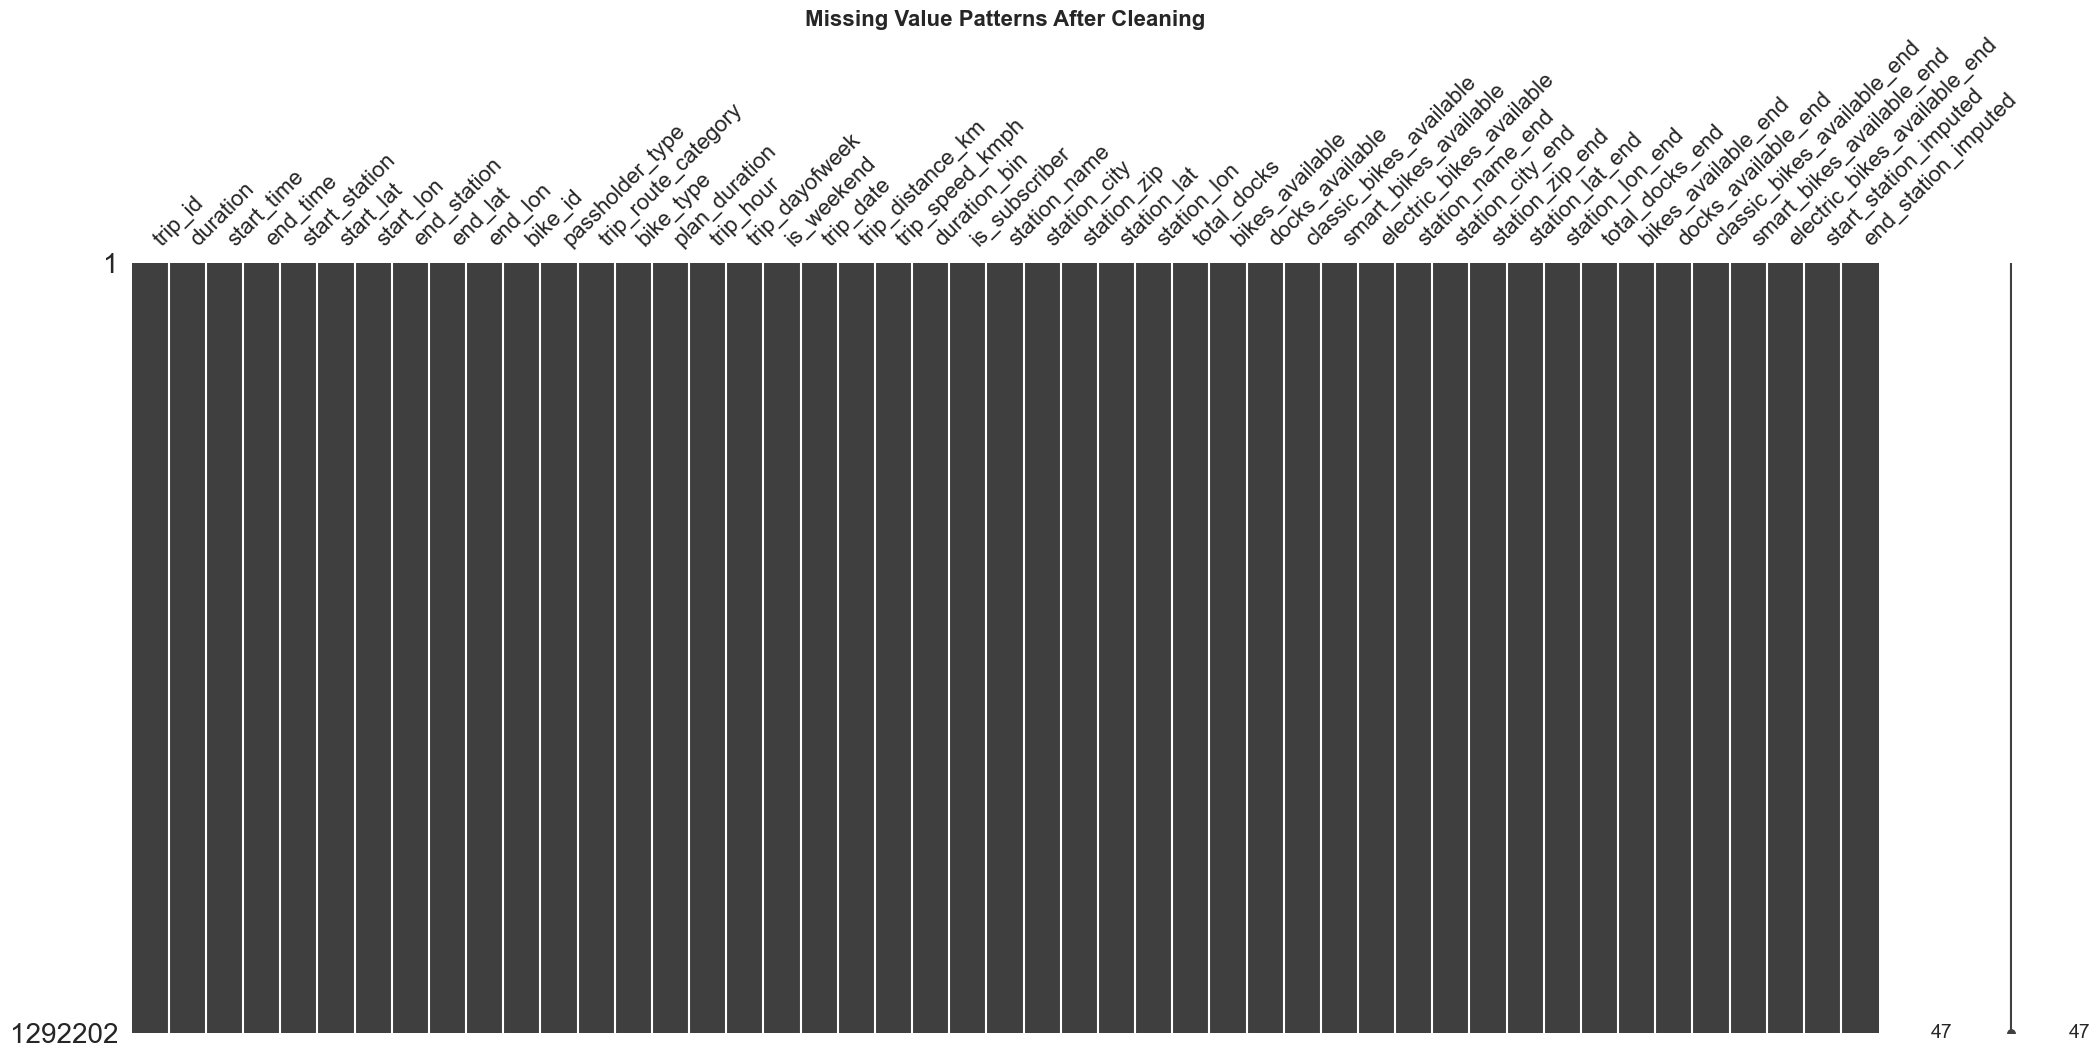

In [ ]:
# Verify missing values are handled
plt.figure(figsize=(14, 6))
msno.matrix(df_merged)
plt.title("Missing Value Patterns After Cleaning")
plt.tight_layout()
plt.show()

In [ ]:
# Create route identifiers
df_merged['route'] = df_merged['start_station'].astype(str) + " → " + df_merged['end_station'].astype(str)
df_merged['route_name'] = df_merged['station_name'] + " → " + df_merged['station_name_end']

# Create round-trip indicator
df_merged['is_round_trip'] = df_merged['start_station'] == df_merged['end_station']

In [ ]:
# Calculate trip distance using Haversine formula
df_merged['trip_distance_km'] = df_merged.apply(
    lambda row: haversine(
        row['start_lon'], row['start_lat'],
        row['station_lon_end'], row['station_lat_end']
    ) if pd.notna(row['start_lon']) and pd.notna(row['station_lon_end']) else np.nan,
    axis=1
)

In [ ]:
# Fill missing distances with median
median_distance = df_merged['trip_distance_km'].median()
df_merged['trip_distance_km'].fillna(median_distance, inplace=True)
print(f"  Median trip distance: {median_distance:.2f} km")

  Median trip distance: 1.14 km


In [ ]:
# Create temporal features
print("- Creating temporal features...")
df_merged['trip_hour'] = df_merged['start_time'].dt.hour
df_merged['weekday'] = df_merged['start_time'].dt.day_name()
df_merged['month'] = df_merged['start_time'].dt.month
df_merged['day'] = df_merged['start_time'].dt.day
df_merged['year'] = df_merged['start_time'].dt.year
df_merged['season'] = pd.cut(
    df_merged['start_time'].dt.month,
    bins=[0,3,6,9,12],
    labels=['Winter','Spring','Summer','Autumn']
)

- Creating temporal features...


In [ ]:
# Display the final prepared dataset
df_merged.head()

trip_id             duration          start_time  \
0          33404951.00                36.00 2017-07-01 00:09:00   
1          33404950.00                13.00 2017-07-01 00:10:00   
2          33404947.00                34.00 2017-07-01 00:11:00   
3          33404948.00                34.00 2017-07-01 00:11:00   
4          33404949.00                12.00 2017-07-01 00:11:00   

             end_time        start_station            start_lat  \
0 2017-07-01 00:45:00              3018.00                34.04   
1 2017-07-01 00:23:00              3055.00                34.04   
2 2017-07-01 00:45:00              3018.00                34.04   
3 2017-07-01 00:45:00              3018.00                34.04   
4 2017-07-01 00:23:00              3055.00                34.04   

             start_lon          end_station              end_lat  \
0              -118.26              3018.00                34.04   
1              -118.25              3082.00                34.05   
2              -118.26              3018.00                34.04   
3              -118.26              3018.00                34.04   
4              -118.25              3082.00                34.05   

               end_lon bike_id passholder_type trip_route_category bike_type  \
0              -118.26    5996         Walk-up          Round Trip   Unknown   
1              -118.24    5777         Walk-up             One Way   Unknown   
2              -118.26    6342         Walk-up          Round Trip   Unknown   
3              -118.26    6478         Walk-up          Round Trip   Unknown   
4              -118.24    6411         Walk-up             One Way   Unknown   

         plan_duration  trip_hour  trip_dayofweek  is_weekend  trip_date  \
0                 0.00          0               5        True 2017-07-01   
1                 0.00          0               5        True 2017-07-01   
2                 0.00          0               5        True 2017-07-01   
3                 0.00          0               5        True 2017-07-01   
4                 0.00          0               5        True 2017-07-01   

      trip_distance_km      trip_speed_kmph duration_bin  is_subscriber  \
0                 0.00                 0.00       30-60m          False   
1                 1.33                 6.16        5-15m          False   
2                 0.00                 0.00       30-60m          False   
3                 0.00                 0.00       30-60m          False   
4                 1.33                 6.67        5-15m          False   

         station_name station_city station_zip          station_lat  \
0     Grand & Olympic         DTLA       90015                34.04   
1  Station ID: 3055.0         DTLA       90017                34.04   
2     Grand & Olympic         DTLA       90015                34.04   
3     Grand & Olympic         DTLA       90015                34.04   
4  Station ID: 3055.0         DTLA       90017                34.04   

           station_lon          total_docks      bikes_available  \
0              -118.26                19.00                 2.00   
1              -118.32                18.89                 8.46   
2              -118.26                19.00                 2.00   
3              -118.26                19.00                 2.00   
4              -118.32                18.89                 8.46   

       docks_available  classic_bikes_available  smart_bikes_available  \
0                17.00                     2.00                   0.00   
1                10.32                     8.06                   0.00   
2                17.00                     2.00                   0.00   
3                17.00                     2.00                   0.00   
4                10.32                     8.06                   0.00   

   electric_bikes_available station_name_end station_city_end station_zip_end  \
0                      0.00  Grand & Olympic     

In [ ]:
# Summary statistics
df_merged.describe()

trip_id             duration  \
count           1292202.00           1292202.00   
mean          255448864.12                16.38   
min            17059125.00                 1.00   
25%           156279581.50                 7.00   
50%           240076626.50                13.00   
75%           357066924.75                23.00   
max           475705471.00                59.00   
std           119196762.26                12.39   

                          start_time                       end_time  \
count                        1292202                        1292202   
mean   2022-07-05 11:07:55.165090560  2022-07-05 11:24:17.583753472   
min              2017-01-01 00:15:00            2017-01-01 00:23:00   
25%              2021-03-27 18:11:45            2021-03-27 18:28:45   
50%              2023-02-12 21:54:30            2023-02-12 22:07:00   
75%              2024-02-17 18:50:30            2024-02-17 19:09:30   
max              2024-12-31 23:47:00            2025-01-01 00:41:00   
std                              NaN                            NaN   

             start_station            start_lat            start_lon  \
count           1292202.00           1292202.00           1292202.00   
mean               3806.83                34.04              -118.32   
min                3000.00                33.98              -118.50   
25%                3040.00                34.03              -118.41   
50%                4212.00                34.05              -118.27   
75%                4446.00                34.05              -118.25   
max                4689.00                34.09              -118.20   
std                 676.05                 0.02                 0.09   

               end_station              end_lat              end_lon  \
count           1292202.00           1292202.00           1292202.00   
mean               3793.13                34.04              -118.32   
min                3000.00                33.98              -118.50   
25%                3036.00                34.03              -118.41   
50%                4214.00                34.05              -118.27   
75%                4444.00                34.05              -118.25   
max                4689.00                34.09              -118.20   
std                 677.93                 0.02                 0.09   

             plan_duration            trip_hour       trip_dayofweek  \
count           1292202.00           1292202.00           1292202.00   
mean                 22.62                14.35                 3.01   
min                   0.00                 0.00                 0.00   
25%                   1.00                11.00                 1.00   
50%                  30.00                15.00                 3.00   
75%                  30.00                18.00                 5.00   
max                  30.00                23.00                 6.00   
std                  12.65                 4.56                 1.97   

                        trip_date     trip_distance_km      trip_speed_kmph  \
count                     1292202           1292202.00           1292202.00   
mean   2022-07-04 20:17:36.562983                 2.36                 7.61   
min           2017-01-01 00:00:00                 0.00                 0.00   
25%           2021-03-27 00:00:00                 0.52                 2.37   
50%           2023-02-12 00:00:00                 1.14                 6.53   
75%           2024-02-17 00:00:00                 2.38                 9.61   
max           2024-12-31 00:00:00                24.14              1183.77   
std                           NaN                 3.91                24.49   

               station_lat          station_lon          total_docks  \
count           1292202.00           1292202.00           1292202.00   
mean                 34.04              -118.32                18.89   
min                  33.98              -118

In [ ]:
df_merged.describe(include='O')

bike_id passholder_type trip_route_category bike_type  \
count   1292202         1292202             1292202   1292202   
unique     4552               4                   2         4   
top       16600    Monthly Pass             One Way  standard   
freq       3191          960596             1105485    625586   

                                station_name station_city station_zip  \
count                                1292202      1292202     1292202   
unique                                   284           19          35   
top     Downtown Santa Monica E Line Station         DTLA       90017   
freq                                   61305       601009      232753   

                            station_name_end station_city_end station_zip_end  \
count                                1292202          1292202         1292202   
unique                                   275               16              32   
top     Downtown Santa Monica E Line Station             DTLA           90017   
freq                                   79912           612957          249498   

                  route                                         route_name  \
count           1292202                                            1292202   
unique            20263                                              20263   
top     4215.0 → 4215.0  Downtown Santa Monica E Line Station → Downtow...   
freq              36339                                              36339   

        weekday  
count   1292202  
unique        7  
top      Friday  
freq     194594

In [ ]:
# Count of unique values for categorical variables
print("\nUnique Values for Categorical Variables:")
categorical_columns = df_merged.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"{col}: {df_merged[col].nunique()} unique values")
    if df_merged[col].nunique() < 10:  # Only show value counts for low-cardinality variables
        print(df_merged[col].value_counts())
        print()


Unique Values for Categorical Variables:
bike_id: 4552 unique values
passholder_type: 4 unique values
passholder_type
Monthly Pass    960596
Walk-up         239488
One Day Pass     88475
Unknown           3643
Name: count, dtype: int64

trip_route_category: 2 unique values
trip_route_category
One Way       1105485
Round Trip     186717
Name: count, dtype: int64

bike_type: 4 unique values
bike_type
standard    625586
electric    566519
Unknown      78149
smart        21948
Name: count, dtype: int64

duration_bin: 4 unique values
duration_bin
5-15m     488891
15-30m    404833
<5m       244043
30-60m    154435
1-2h           0
>2h            0
Name: count, dtype: int64

station_name: 284 unique values
station_city: 19 unique values
station_zip: 35 unique values
station_name_end: 275 unique values
station_city_end: 16 unique values
station_zip_end: 32 unique values
route: 20263 unique values
route_name: 20263 unique values
weekday: 7 unique values
weekday
Friday       194594
Thursday    

# TEMPORAL UTILIZATION ANALYSIS

- This section analyzes how Metro Bike Share usage varies over time,
- including hourly patterns, day of week trends, and seasonal differences.

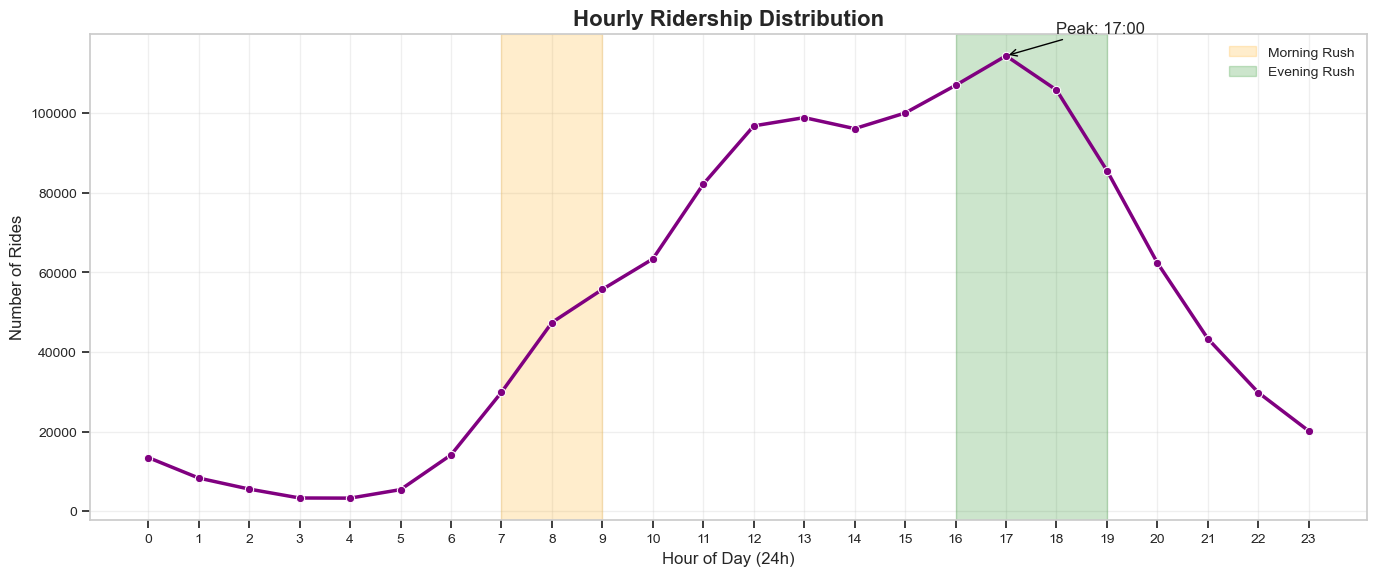

In [ ]:
# 3.1 Hourly usage patterns
# Group trips by hour and count them
hourly_rides = df_merged.groupby('trip_hour').size().reset_index(name='rides')

# Visualize rides by hour of day
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_rides,
    x='trip_hour', y='rides', 
    marker='o',
    color='purple', 
    linewidth=2.5
)
plt.title('Hourly Ridership Distribution')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# Add annotations for key periods
max_hour = hourly_rides.loc[hourly_rides['rides'].idxmax(), 'trip_hour']
plt.annotate(
    f'Peak: {max_hour}:00',
    xy=(max_hour, hourly_rides['rides'].max()),
    xytext=(max_hour+1, hourly_rides['rides'].max()*1.05),
    arrowprops=dict(arrowstyle='->'),
    fontsize=12
)

# Highlight morning and evening rush hours
plt.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
plt.axvspan(16, 19, alpha=0.2, color='green', label='Evening Rush')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Peak hour is {max_hour}:00 with {hourly_rides['rides'].max()} rides")

Peak hour is 17:00 with 114416 rides


Average weekday rides: 185708
Average weekend rides: 181832
Weekend to weekday ratio: 0.98


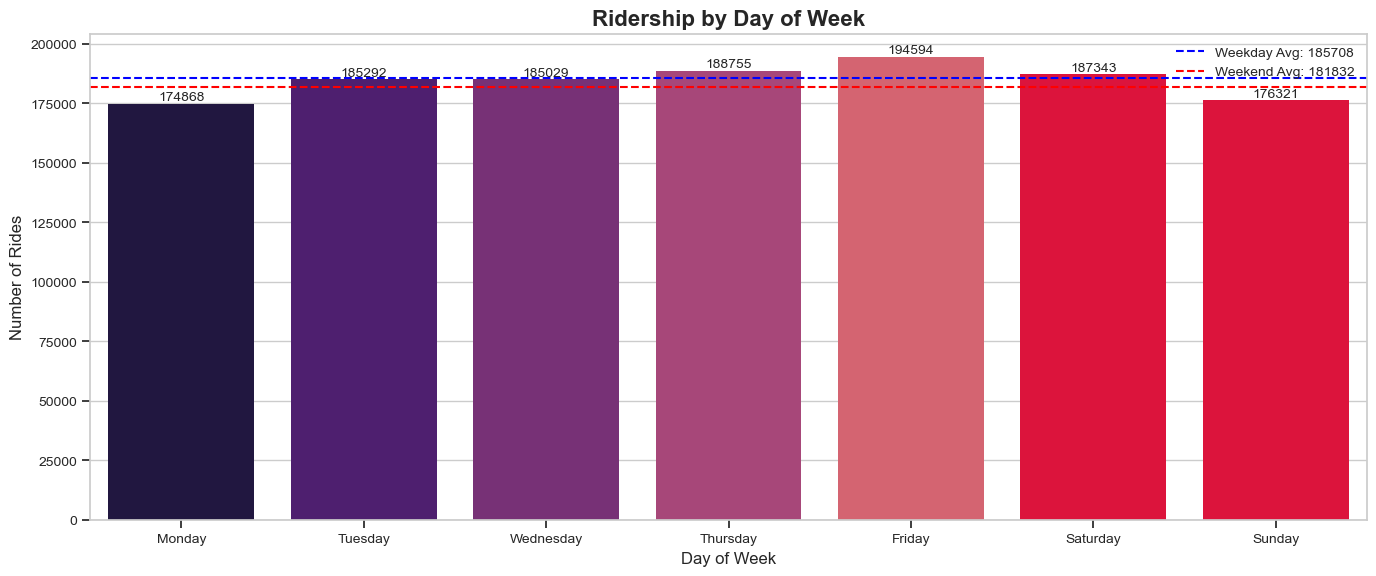

In [ ]:
# Day of week usage patterns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count rides by day of week
daily_rides = df_merged['weekday'].value_counts().reindex(weekday_order).reset_index()
daily_rides.columns = ['weekday', 'rides']

# Calculate weekend vs. weekday average
weekday_avg = daily_rides[daily_rides['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['rides'].mean()
weekend_avg = daily_rides[daily_rides['weekday'].isin(['Saturday', 'Sunday'])]['rides'].mean()
print(f"Average weekday rides: {weekday_avg:.0f}")
print(f"Average weekend rides: {weekend_avg:.0f}")
print(f"Weekend to weekday ratio: {weekend_avg/weekday_avg:.2f}")

# Visualize rides by day of week
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=daily_rides, 
    x='weekday', y='rides', 
    palette='magma'
)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

# Color code weekdays vs. weekends
for i, day in enumerate(weekday_order):
    if day in ['Saturday', 'Sunday']:
        ax.patches[i].set_facecolor('crimson')

plt.title('Ridership by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.axhline(y=weekday_avg, color='blue', linestyle='--', label=f'Weekday Avg: {weekday_avg:.0f}')
plt.axhline(y=weekend_avg, color='red', linestyle='--', label=f'Weekend Avg: {weekend_avg:.0f}')
plt.legend()
plt.tight_layout()
plt.show()

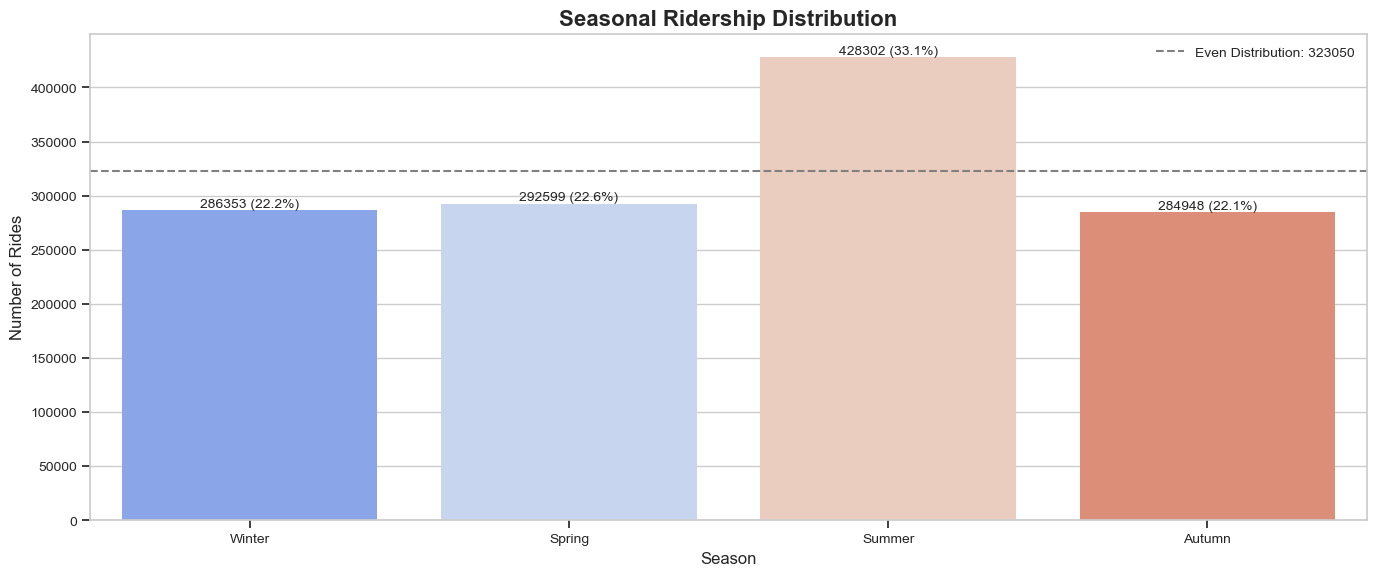

In [ ]:
# Seasonal ridership patterns
# Define season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# Count rides by season
seasonal_rides = df_merged['season'].value_counts().reindex(season_order).reset_index()
seasonal_rides.columns = ['season', 'rides']

# Calculate seasonal percentages
total_rides = seasonal_rides['rides'].sum()
seasonal_rides['percentage'] = (seasonal_rides['rides'] / total_rides * 100).round(1)

# Visualize rides by season
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=seasonal_rides, 
    x='season', y='rides', 
    palette='coolwarm'
)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    ax.annotate(
        f'{p.get_height():.0f} ({seasonal_rides.iloc[i]["percentage"]}%)',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Seasonal Ridership Distribution')
plt.xlabel('Season')
plt.ylabel('Number of Rides')
plt.axhline(y=total_rides/4, color='gray', linestyle='--', label=f'Even Distribution: {total_rides/4:.0f}')
plt.legend()
plt.tight_layout()
plt.show()

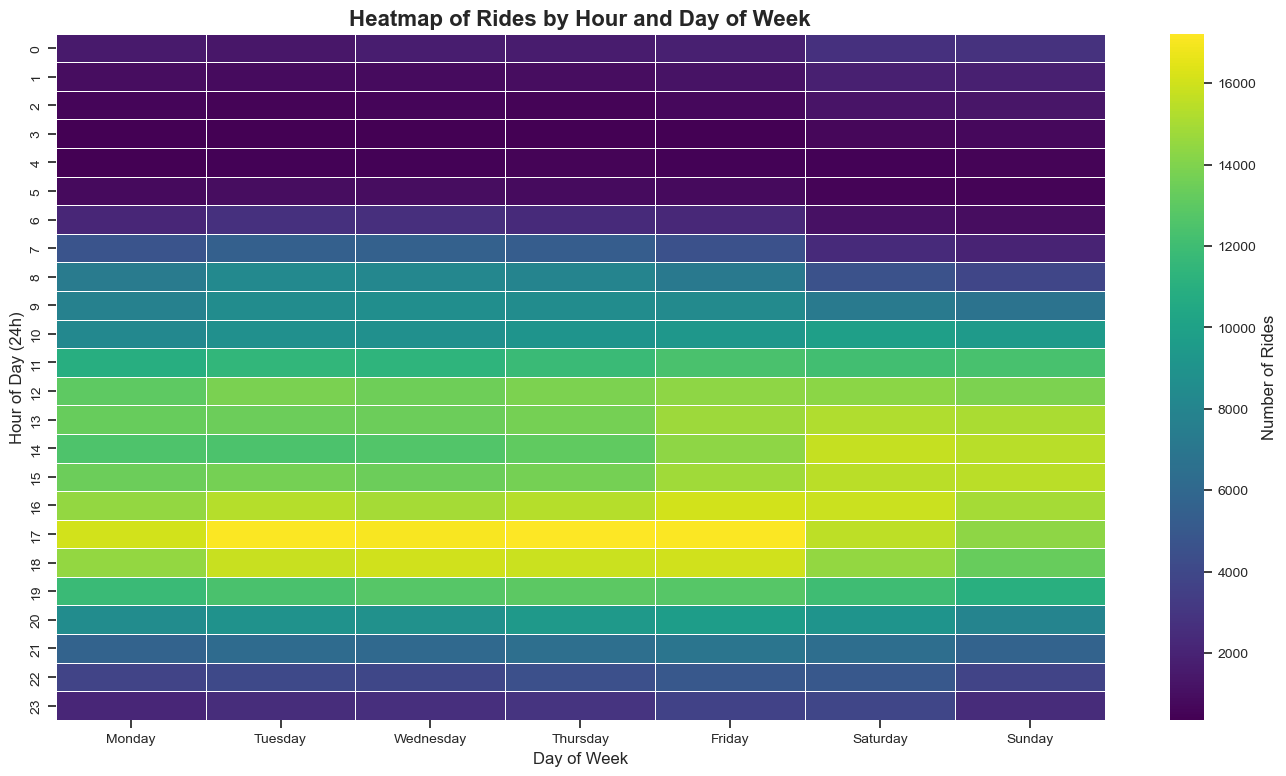

In [ ]:
# Hourly patterns by day of week (heatmap)

# Create a crosstab of hour vs. day
hourly_daily = pd.crosstab(
    index=df_merged['trip_hour'],
    columns=df_merged['weekday'],
    values=df_merged['trip_id'],
    aggfunc='count'
)

# Reorder columns to standard weekday order
hourly_daily = hourly_daily.reindex(columns=weekday_order)

# Visualize as a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    hourly_daily,
    cmap='viridis',
    linewidths=.5,
    annot=False,
    fmt='g',
    cbar_kws={'label': 'Number of Rides'}
)
plt.title('Heatmap of Rides by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day (24h)')
plt.tight_layout()
plt.show()



Analyzing monthly ridership trends...


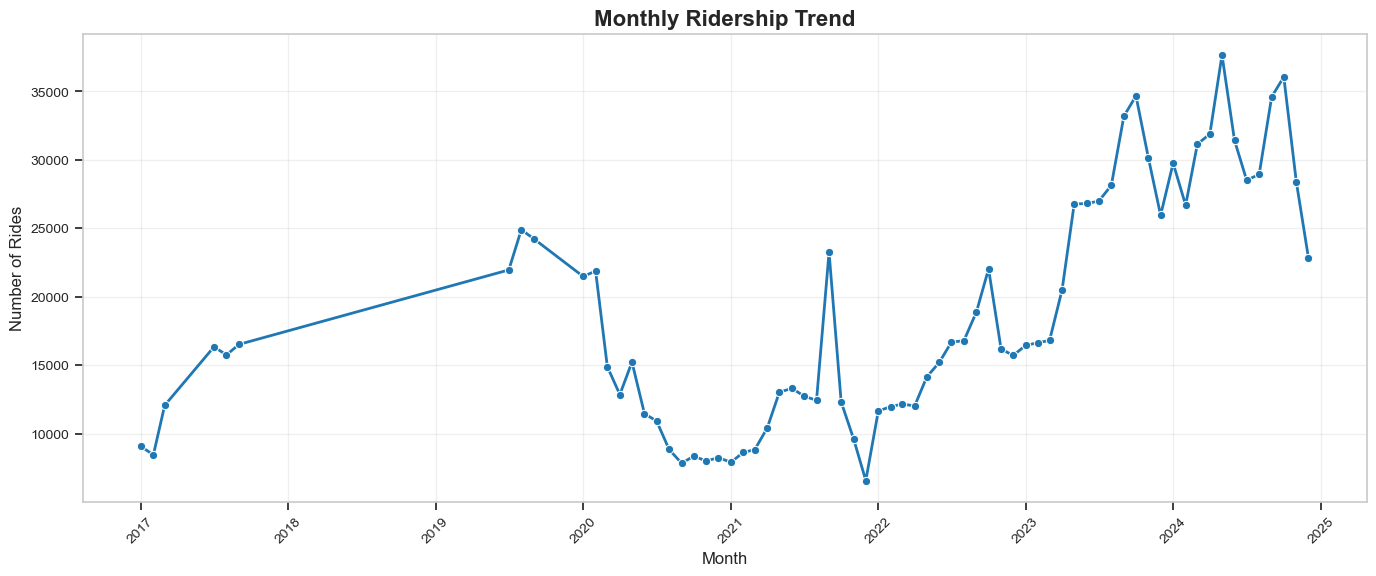

In [ ]:
# Monthly ridership trends
print("\nAnalyzing monthly ridership trends...")

# Count rides by month and year
monthly_rides = df_merged.groupby(['year', 'month']).size().reset_index(name='rides')
monthly_rides['date'] = pd.to_datetime(monthly_rides[['year', 'month']].assign(day=1))

# Visualize monthly trend
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_rides,
    x='date', y='rides',
    marker='o',
    linewidth=2
)
plt.title('Monthly Ridership Trend')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Key findings summary
print("\nKey findings from temporal analysis:")
print("1. Ridership shows clear morning and evening rush hour peaks")
print(f"2. Peak hour is {max_hour}:00 with {hourly_rides['rides'].max()} rides")
print(f"3. Weekend to weekday ratio is {weekend_avg/weekday_avg:.2f}")
print(f"4. {seasonal_rides.iloc[seasonal_rides['rides'].idxmax()]['season']} is the most popular season with {seasonal_rides['rides'].max()} rides ({seasonal_rides['percentage'].max()}% of total)")


Key findings from temporal analysis:
1. Ridership shows clear morning and evening rush hour peaks
2. Peak hour is 17:00 with 114416 rides
3. Weekend to weekday ratio is 0.98
4. Summer is the most popular season with 428302 rides (33.1% of total)


# STATION AND NETWORK ANALYSIS 

- This section analyzes station usage, capacity, rebalancing needs, 
- and geographic patterns to optimize network design and operations.

In [ ]:
# Station popularity and utilization

# Count trips starting at each station
station_trips = df_merged.groupby('station_name').size().reset_index(name='trips')
station_trips = station_trips.sort_values('trips', ascending=False)

# Display top stations by trip count
station_trips.head(10)

station_name  trips
48   Downtown Santa Monica E Line Station  61305
24                           7th & Flower  47784
105               Ocean Front Walk & Navy  45833
58                         Figueroa & 8th  37509
107                           Olive & 8th  28857
69                            Grand & 8th  24426
106       Ocean Front Walk & North Venice  22988
93                             Main & 1st  19900
80                         Hope & Olympic  19159
138                    Station ID: 3031.0  18257

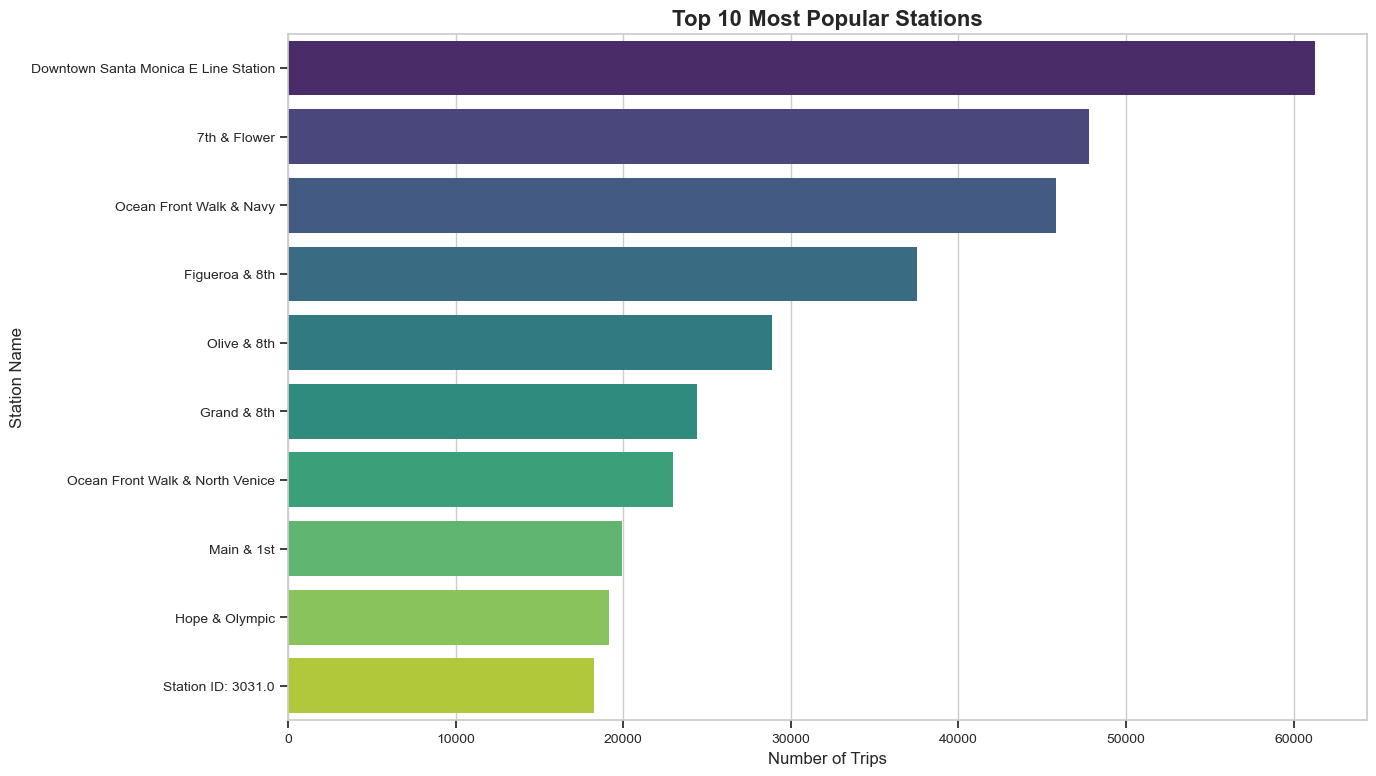

In [ ]:
# Visualize top stations
plt.figure(figsize=(14, 8))
sns.barplot(
    data=station_trips.head(10),
    x='trips', y='station_name',
    palette='viridis'
)
plt.title('Top 10 Most Popular Stations')
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

In [ ]:
# Station capacity and utilization

# Create station metrics dataframe
station_metrics = df_merged.groupby('station_name').agg(
    trips=('trip_id', 'count'),
    total_docks=('total_docks', 'first'),
    lat=('start_lat', 'first'),
    lon=('start_lon', 'first')
).reset_index()

# Calculate utilization rate
station_metrics['utilization_rate'] = station_metrics['trips'] / station_metrics['total_docks']
station_metrics = station_metrics.sort_values('utilization_rate', ascending=False)

# Display top stations by utilization rate
station_metrics[['station_name', 'trips', 'total_docks', 'utilization_rate']].head(10)

station_name  trips          total_docks  \
48   Downtown Santa Monica E Line Station  61305                18.00   
105               Ocean Front Walk & Navy  45833                26.00   
58                         Figueroa & 8th  37509                23.00   
24                           7th & Flower  47784                31.00   
106       Ocean Front Walk & North Venice  22988                15.00   
69                            Grand & 8th  24426                18.00   
96                         Main & Winston  16231                13.00   
94                             Main & 8th   9082                 8.00   
59                         Figueroa & 9th  15619                15.00   
138                    Station ID: 3031.0  18257                18.89   

        utilization_rate  
48               3405.83  
105              1762.81  
58               1630.83  
24               1541.42  
106              1532.53  
69               1357.00  
96               1248.54  
94               1135.25  
59               1041.27  
138               966.70

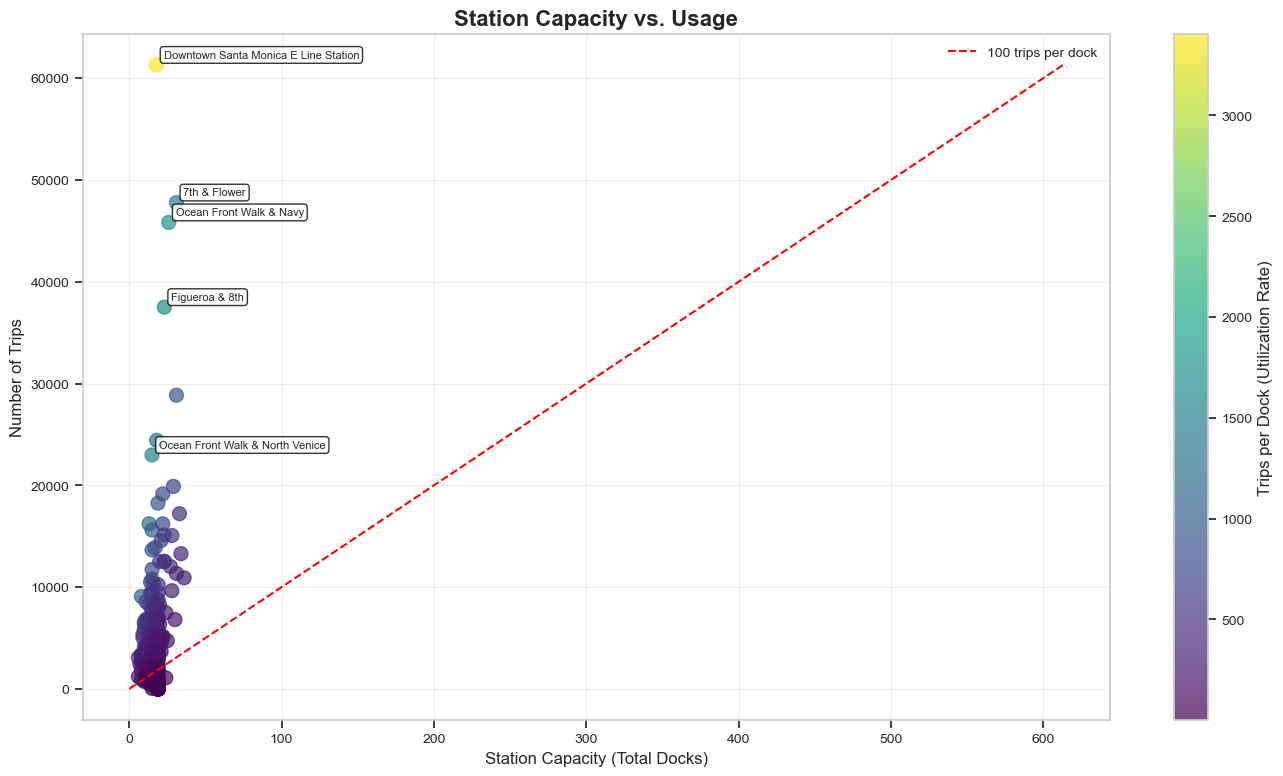

In [ ]:
# Visualize capacity vs. usage
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    station_metrics['total_docks'],
    station_metrics['trips'],
    c=station_metrics['utilization_rate'],
    cmap='viridis',
    s=100,
    alpha=0.7
)

# Add color bar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Trips per Dock (Utilization Rate)')

# Add diagonal reference line for "optimal" utilization
max_val = max(station_metrics['total_docks'].max(), station_metrics['trips'].max() / 100)
plt.plot([0, max_val], [0, max_val * 100], 'r--', label='100 trips per dock')

# Annotate some notable stations
high_util = station_metrics.head(5)  # Top 5 by utilization
for _, station in high_util.iterrows():
    plt.annotate(
        station['station_name'],
        (station['total_docks'], station['trips']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
    )

plt.title('Station Capacity vs. Usage')
plt.xlabel('Station Capacity (Total Docks)')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Rebalancing needs analysis

# Define a "shortage event" when starting station has 0 bikes available
shortages = df_merged[df_merged['bikes_available'] == 0]
station_shortages = (
    shortages['station_name']
      .value_counts()
      .head(10)
      .reset_index(name='shortage_events')
)
station_shortages.columns = ['station_name', 'shortage_events']

# Display top stations with shortage events
station_shortages

station_name  shortage_events
0           Drake Stadium             8231
1         Weyburn Terrace             5301
2      Vista Hermosa Park             4192
3  Mississippi & Sawtelle             3168
4          25th & Vermont             2812

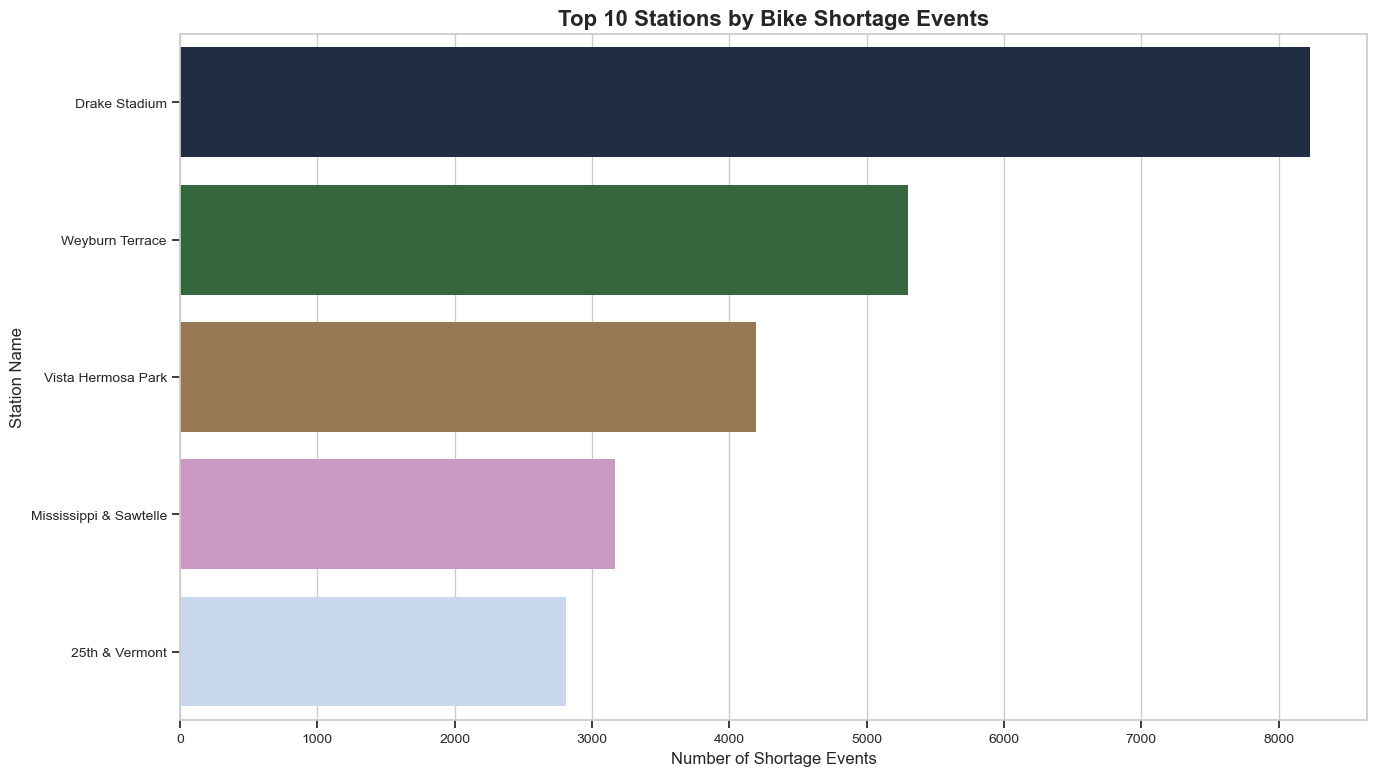

In [ ]:
# Visualize shortage events
plt.figure(figsize=(14, 8))
sns.barplot(
    data=station_shortages,
    x='shortage_events', y='station_name',
    palette='cubehelix'
)
plt.title('Top 10 Stations by Bike Shortage Events')
plt.xlabel('Number of Shortage Events')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

In [ ]:
# Empty dock events (full stations)

# Define an "empty dock event" when ending station has 0 docks available
full_stations = df_merged[df_merged['docks_available_end'] == 0]
station_full = (
    full_stations['station_name_end']
      .value_counts()
      .head(10)
      .reset_index(name='full_events')
)
station_full.columns = ['station_name', 'full_events']

# Display top stations with full events
station_full

station_name  full_events
0       Figueroa & 11th         8106
1  Sunset & Silver Lake         2666

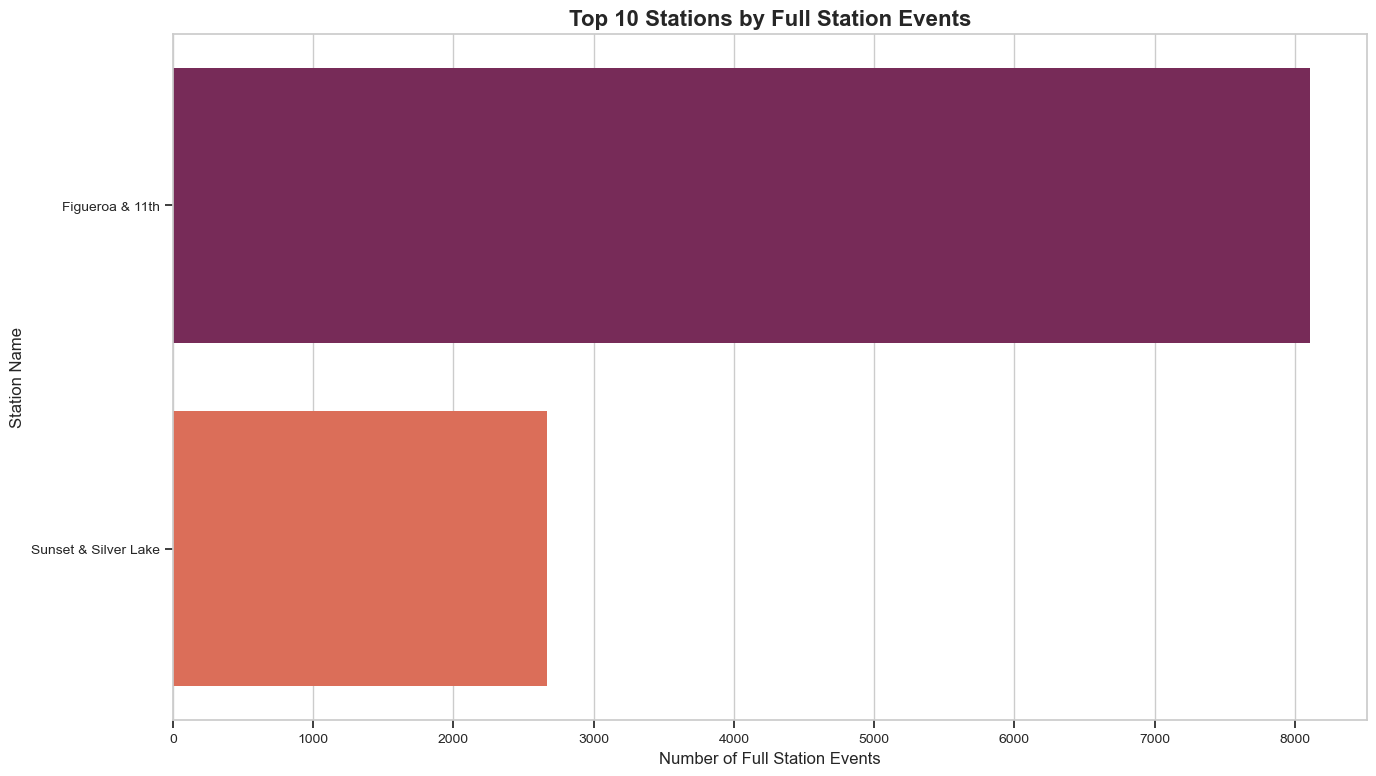

In [ ]:
# Visualize full station events
plt.figure(figsize=(14, 8))
sns.barplot(
    data=station_full,
    x='full_events', y='station_name',
    palette='rocket'
)
plt.title('Top 10 Stations by Full Station Events')
plt.xlabel('Number of Full Station Events')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

In [ ]:
# Route Analysis

# Top 10 routes by count
route_popularity = df_merged['route_name'].value_counts().head(10)
# Display top routes
route_popularity

route_name
Downtown Santa Monica E Line Station → Downtown Santa Monica E Line Station    36339
Ocean Front Walk & Navy → Ocean Front Walk & Navy                              18268
Ocean Front Walk & Navy → Downtown Santa Monica E Line Station                 16410
Downtown Santa Monica E Line Station → Ocean Front Walk & Navy                  8697
Ocean Front Walk & North Venice → Downtown Santa Monica E Line Station          8388
7th & Flower → 7th & Flower                                                     8345
Figueroa & 8th → Figueroa & 8th                                                 7113
Ocean Front Walk & North Venice → Ocean Front Walk & Navy                       6839
Olive & 8th → Olive & 8th                                                       6673
Main & 1st → Union Station West Portal                                          6030
Name: count, dtype: int64

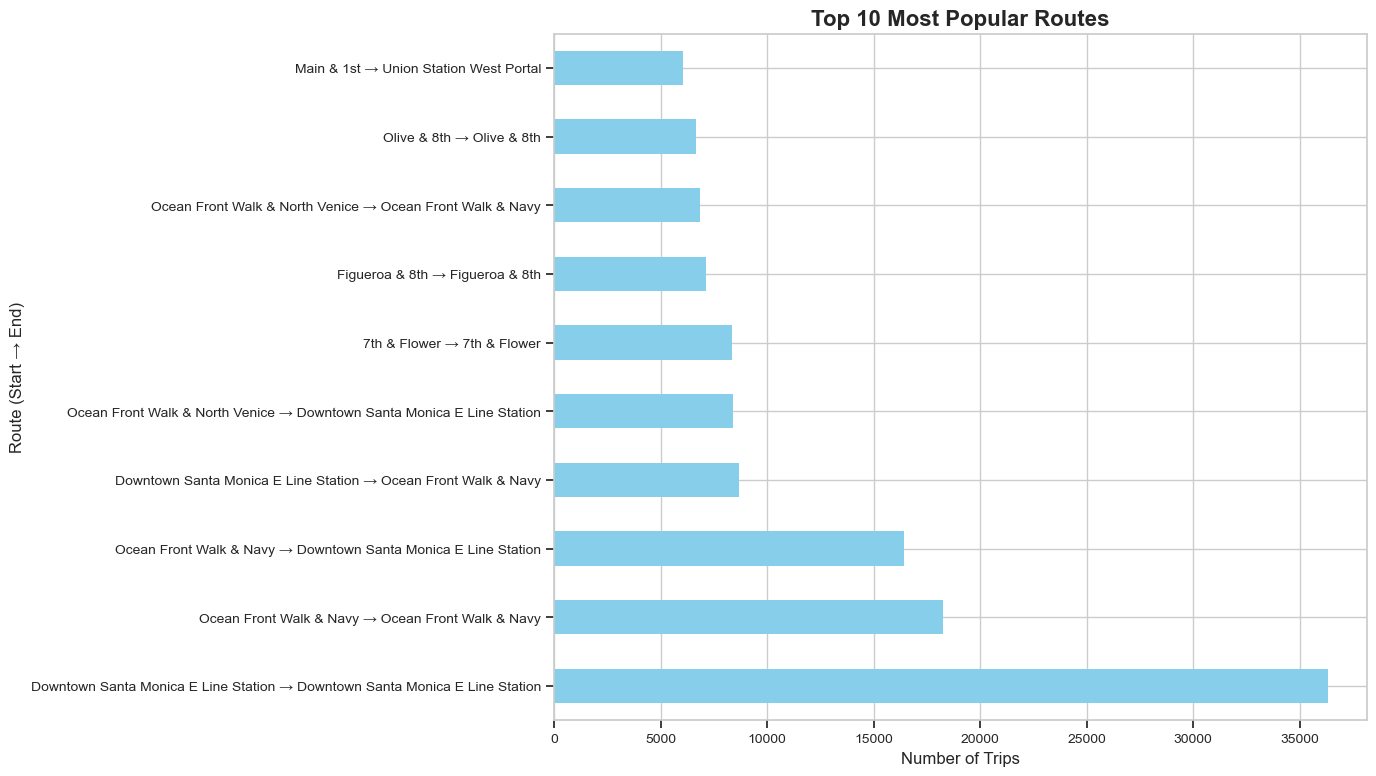

In [ ]:
# Visualize popular routes
plt.figure(figsize=(14, 8))
route_popularity.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Popular Routes')
plt.xlabel('Number of Trips')
plt.ylabel('Route (Start → End)')
plt.tight_layout()
plt.show()

In [ ]:
# Round trip analysis

# Calculate round trip percentage
round_trip_count = df_merged['is_round_trip'].sum()
round_trip_pct = df_merged['is_round_trip'].mean() * 100
print(f"Round trips: {round_trip_count} ({round_trip_pct:.1f}% of all trips)")

Round trips: 213925 (16.6% of all trips)


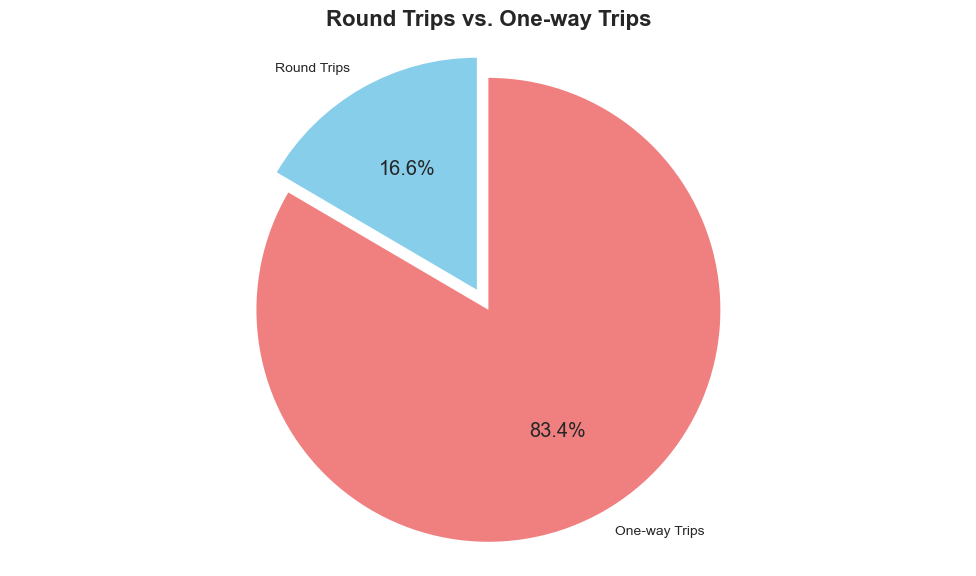

In [ ]:
# Visualize round trip vs one-way
plt.figure(figsize=(10, 6))
plt.pie(
    [round_trip_count, len(df_merged) - round_trip_count],
    labels=['Round Trips', 'One-way Trips'],
    autopct='%1.1f%%',
    colors=['skyblue', 'lightcoral'],
    startangle=90,
    explode=(0.1, 0)
)
plt.title('Round Trips vs. One-way Trips')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Round trips by station
round_trips_by_station = df_merged[df_merged['is_round_trip']].groupby('station_name').size().reset_index(name='round_trips')
round_trips_by_station = round_trips_by_station.sort_values('round_trips', ascending=False)

round_trips_by_station.head(10)

station_name  round_trips
47   Downtown Santa Monica E Line Station        36339
103               Ocean Front Walk & Navy        18268
24                           7th & Flower         8345
57                         Figueroa & 8th         7113
104                           Olive & 8th         6673
37                        Bagley & Venice         5508
78                         Hope & Olympic         3624
67                            Grand & 8th         2855
110                       Pershing Square         2606
265                       Windward & Main         2362

In [ ]:
# Impact of dock additions on empty dock events

# Count empty-dock events (when a trip ends and docks_available==0)
empty_events = df_merged[df_merged['docks_available_end'] == 0].groupby('end_station').size().reset_index(name='events')
capacity_data = stations[['station_id', 'total_docks']]
simulation = empty_events.merge(capacity_data, left_on='end_station', right_on='station_id', how='left')

# Simulate adding docks
print("Simulating reduction in empty dock events when adding docks:")
for additional_docks in [0, 5, 10, 20]:
    # Basic assumption: events reduce proportionally to capacity increase
    simulation[f'events_with_{additional_docks}'] = simulation['events'] * (
        simulation['total_docks'] / (simulation['total_docks'] + additional_docks)
    ) if additional_docks > 0 else simulation['events']
    
    total_events = simulation[f'events_with_{additional_docks}'].sum()
    reduction = (1 - (total_events / simulation['events'].sum())) * 100 if additional_docks > 0 else 0
    
    print(f"- Adding {additional_docks} docks: {total_events:.0f} events ({reduction:.1f}% reduction)")

# Prepare data for visualization
sim_long = simulation.melt(
    id_vars=['end_station'],
    value_vars=[f'events_with_{x}' for x in [0, 5, 10, 20]],
    var_name='docks_added',
    value_name='simulated_events'
)

# Extract the number of docks added from the variable name
sim_long['docks_added'] = sim_long['docks_added'].str.extract('(\d+)').astype(int)

# Calculate average events per station
sim_summary = sim_long.groupby('docks_added')['simulated_events'].agg(['sum', 'mean']).reset_index()
sim_summary['reduction_pct'] = (1 - (sim_summary['sum'] / sim_summary['sum'].iloc[0])) * 100

Simulating reduction in empty dock events when adding docks:
- Adding 0 docks: 10772 events (0.0% reduction)
- Adding 5 docks: 8176 events (24.1% reduction)
- Adding 10 docks: 6588 events (38.8% reduction)
- Adding 20 docks: 4745 events (55.9% reduction)


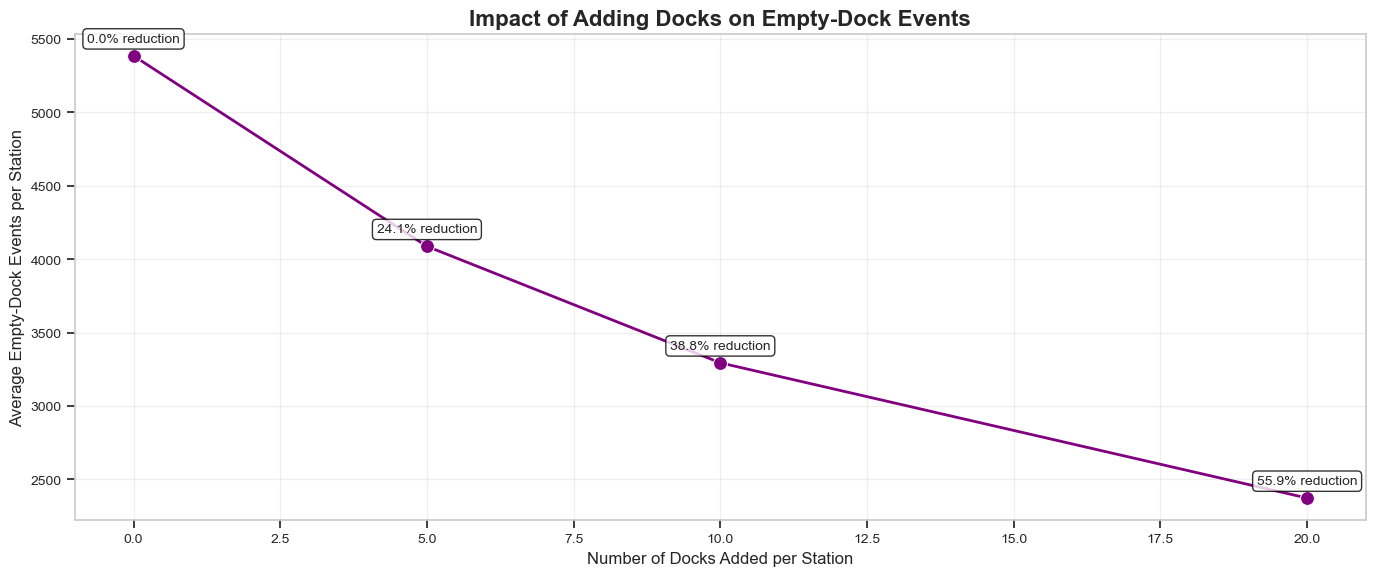

In [ ]:
# Visualize the simulation results
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=sim_summary,
    x='docks_added', y='mean',
    marker='o', 
    markersize=10,
    linewidth=2,
    color='purple'
)

# Add data labels
for i, row in sim_summary.iterrows():
    plt.annotate(
        f"{row['reduction_pct']:.1f}% reduction",
        (row['docks_added'], row['mean']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
    )

plt.title('Impact of Adding Docks on Empty-Dock Events')
plt.xlabel('Number of Docks Added per Station')
plt.ylabel('Average Empty-Dock Events per Station')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Key findings from station analysis
print("\nKey findings from station analysis:")
print("1. The most popular station has", station_trips['trips'].max(), "trips, which is", 
      f"{station_trips['trips'].max() / station_trips['trips'].mean():.1f}x the average station")
print("2. Round trips account for", f"{round_trip_pct:.1f}%", "of all trips")
print("3. Adding 10 docks per station could reduce empty-dock events by approximately", 
      f"{sim_summary.loc[sim_summary['docks_added'] == 10, 'reduction_pct'].values[0]:.1f}%")
print("4. The top 3 stations with capacity issues are:", 
      ", ".join(station_shortages['station_name'].head(3).tolist()))


Key findings from station analysis:
1. The most popular station has 61305 trips, which is 13.5x the average station
2. Round trips account for 16.6% of all trips
3. Adding 10 docks per station could reduce empty-dock events by approximately 38.8%
4. The top 3 stations with capacity issues are: Drake Stadium, Weyburn Terrace, Vista Hermosa Park


# USER EXPERIENCE AND RIDER SEGMENTS

- This section analyzes rider behavior, preferences, and segmentation to
- improve user experience and engagement strategies.

# Trip Duration by Rider Segment Analysis

In [ ]:
# check the unique values in the is_subscriber column
df_merged['is_subscriber'].unique()

array([0])

In [ ]:
# Make sure is_subscriber is properly defined (sometimes it can be a string or have NaN values)
# Convert to binary values if needed
df_merged['is_subscriber'] = df_merged['is_subscriber'].fillna(0).astype(int)

In [ ]:
# Create rider segment labels for plotting
df_merged['rider_segment'] = df_merged['is_subscriber'].map({1: 'Subscribers', 0: 'Casual Riders'})
# Check that we now have proper segments
df_merged['rider_segment'].value_counts()

rider_segment
Casual Riders    1292202
Name: count, dtype: int64

# Trip Duration Distribution by Rider Segment

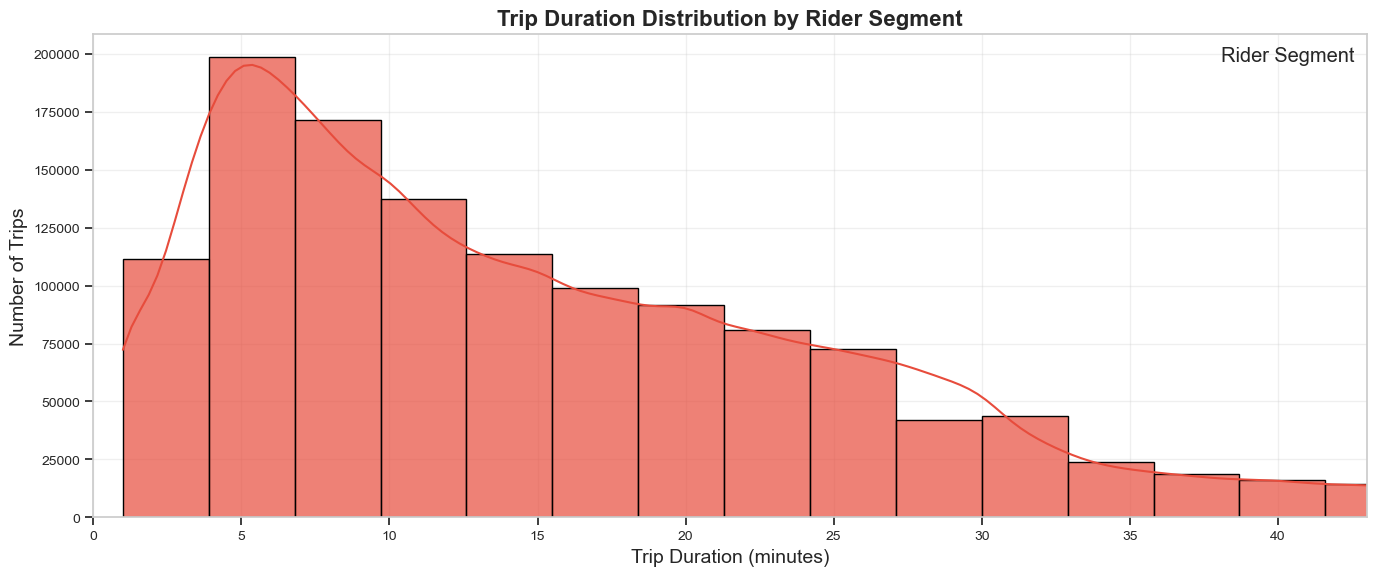

In [ ]:
# Create distribution plot with proper filtering
plt.figure(figsize=(14, 6))
sns.histplot(
    data=df_merged,
    x='duration',
    hue='rider_segment',
    multiple='dodge',
    bins=20,
    alpha=0.7,
    kde=True,
    palette=['#e74c3c', '#3498db']  # Red for casual, Blue for subscribers
)
plt.title('Trip Duration Distribution by Rider Segment', fontsize=16)
plt.xlabel('Trip Duration (minutes)', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xlim(0, df_merged['duration'].quantile(0.95))  # Limit x-axis to 95th percentile for better visibility
plt.legend(title='Rider Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Average Trip Duration by Rider Segment

# Calculate average trip duration by rider segment
duration_by_segment = df_merged.groupby('rider_segment')['duration'].agg(['mean', 'median', 'count']).reset_index()
duration_by_segment.columns = ['rider_segment', 'mean_duration', 'median_duration', 'trip_count']

print("\nTrip duration statistics by rider segment:")
duration_by_segment

# # Create bar chart of average durations
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(
#     data=duration_by_segment,
#     x='rider_segment', 
#     y='mean_duration',
#     palette=['#e74c3c', '#3498db']
# )
# plt.title('Average Trip Duration by Rider Segment', fontsize=16)
# plt.xlabel('Rider Segment', fontsize=14)
# plt.ylabel('Average Duration (minutes)', fontsize=14)

# # Add value labels
# for i, p in enumerate(ax.patches):
#     ax.annotate(
#         f"{p.get_height():.1f} min",
#         (p.get_x() + p.get_width() / 2., p.get_height()),
#         ha='center',
#         va='bottom',
#         fontsize=12
#     )

# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()


Trip duration statistics by rider segment:


rider_segment        mean_duration      median_duration  trip_count
0  Casual Riders                16.38                13.00     1292202

In [ ]:
# Trip Distance by Rider Segment

# Calculate average trip distance by rider segment
distance_by_segment = df_merged.groupby('rider_segment')['trip_distance_km'].agg(['mean', 'median', 'count']).reset_index()
distance_by_segment.columns = ['rider_segment', 'mean_distance', 'median_distance', 'trip_count']

distance_by_segment

# # Create bar chart of average distances
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(
#     data=distance_by_segment,
#     x='rider_segment', 
#     y='mean_distance',
#     palette=['#e74c3c', '#3498db']
# )
# plt.title('Average Trip Distance by Rider Segment', fontsize=16)
# plt.xlabel('Rider Segment', fontsize=14)
# plt.ylabel('Average Distance (km)', fontsize=14)

# # Add value labels
# for i, p in enumerate(ax.patches):
#     ax.annotate(
#         f"{p.get_height():.2f} km",
#         (p.get_x() + p.get_width() / 2., p.get_height()),
#         ha='center',
#         va='bottom',
#         fontsize=12
#     )

# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()

rider_segment        mean_distance      median_distance  trip_count
0  Casual Riders                 2.36                 1.14     1292202

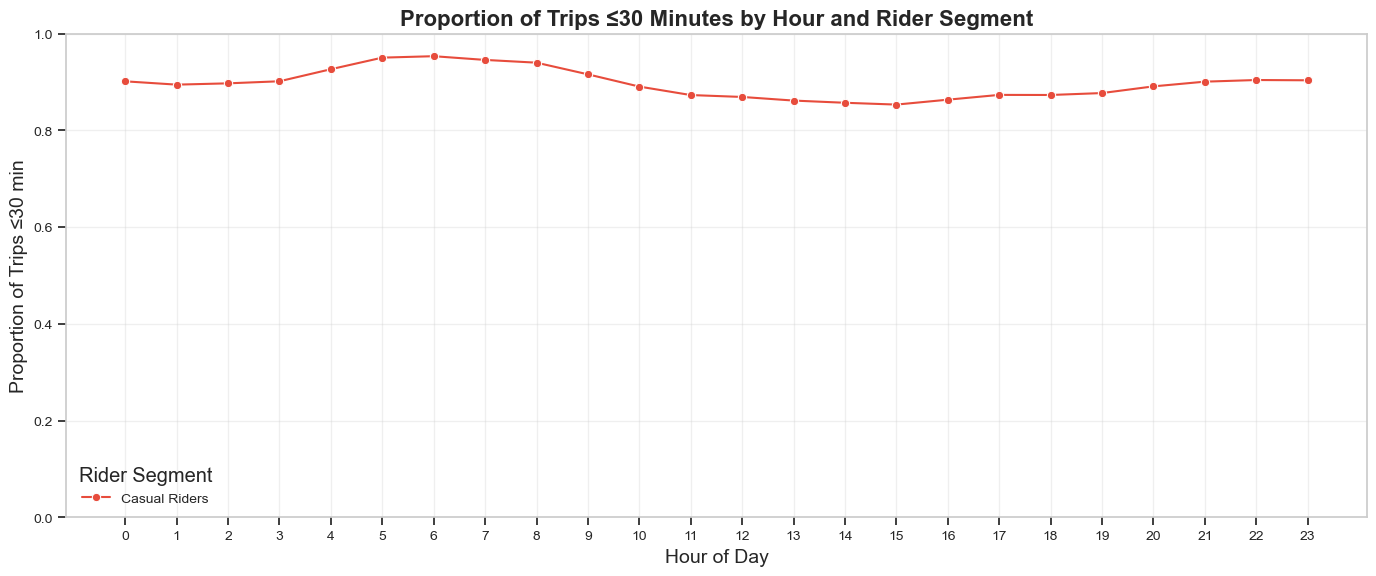

In [ ]:
# Peak-Hour Behavior by Rider Segment

# Calculate fraction of trips ≤ 30 min by hour and rider segment
# Add a column for trips under 30 minutes
df_merged['under_30'] = df_merged['duration'] <= 30

# Group by hour and rider segment
hour_segment_summary = df_merged.groupby(['trip_hour', 'rider_segment'])['under_30'].mean().reset_index(name='pct_under_30')
hour_segment_summary.head()

# Visualize percentage of trips under 30 min
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hour_segment_summary,
    x='trip_hour', 
    y='pct_under_30',
    hue='rider_segment',
    palette=['#e74c3c', '#3498db'],
    marker='o'
)
plt.title('Proportion of Trips ≤30 Minutes by Hour and Rider Segment', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Proportion of Trips ≤30 min', fontsize=14)
plt.ylim(0, 1)
plt.xticks(range(0, 24))
plt.legend(title='Rider Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Weekly Trip Distribution by Rider Segment

# Make sure 'weekday' is properly defined
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group trips by weekday and rider segment
daily_trips = df_merged.groupby(['weekday', 'rider_segment']).size().reset_index(name='trips')

# Check the result
daily_trips.head()

weekday  rider_segment   trips
0    Friday  Casual Riders  194594
1    Monday  Casual Riders  174868
2  Saturday  Casual Riders  187343
3    Sunday  Casual Riders  176321
4  Thursday  Casual Riders  188755

In [ ]:
# Create a pivot table with rider segments as columns and weekdays as rows
pivot_df = pd.pivot_table(
    daily_trips, 
    values='trips',
    index='weekday',
    columns='rider_segment',
    aggfunc='sum'
).reindex(weekday_order)

# Calculate percentage distribution within each segment
normalized_pivot = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100
normalized_pivot

rider_segment        Casual Riders
weekday                           
Monday                       13.53
Tuesday                      14.34
Wednesday                    14.32
Thursday                     14.61
Friday                       15.06
Saturday                     14.50
Sunday                       13.65

<Figure size 1400x600 with 0 Axes>

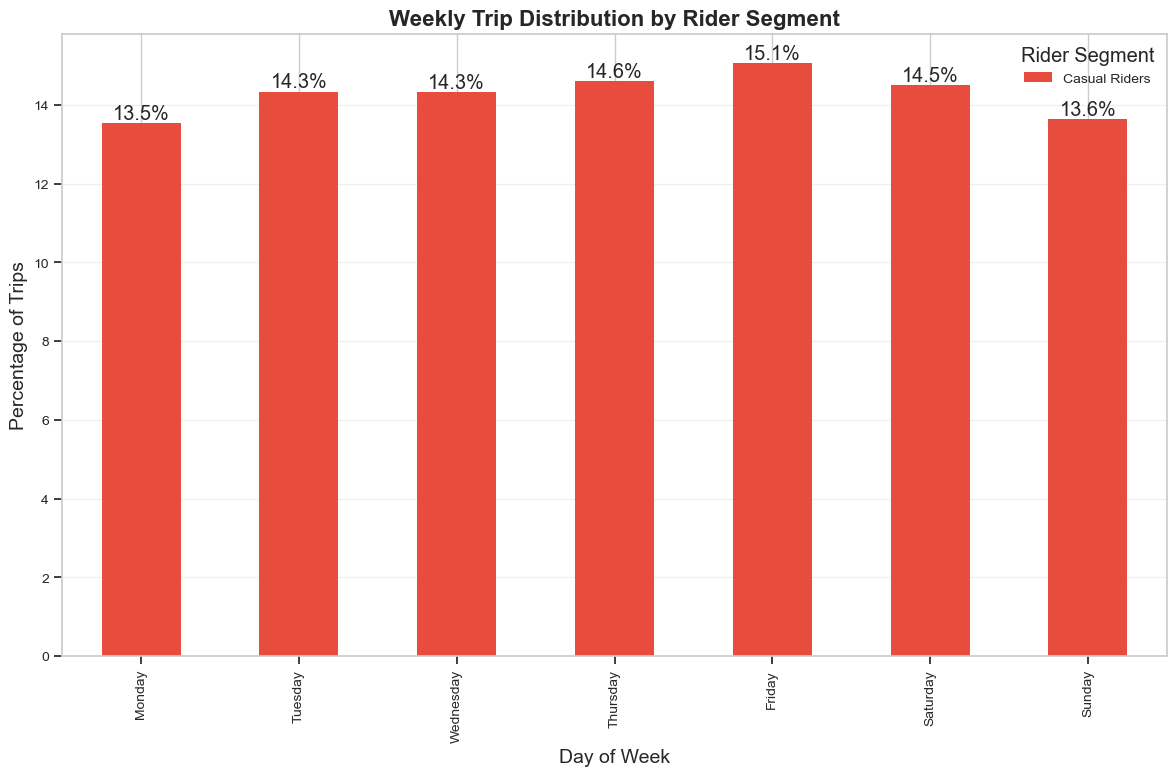

In [ ]:
# Create bar chart
plt.figure(figsize=(14, 6))
normalized_pivot.plot(kind='bar', color=['#e74c3c', '#3498db'])
plt.title('Weekly Trip Distribution by Rider Segment', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Percentage of Trips', fontsize=14)
plt.legend(title='Rider Segment')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, container in enumerate(plt.gca().containers):
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [ ]:
# Bike Type Preference by Rider Segment

# Count trips by bike type and rider segment
bike_type_counts = df_merged.groupby(['bike_type', 'rider_segment']).size().reset_index(name='trips')

# Create pivot table
bike_pivot = pd.pivot_table(
    bike_type_counts,
    values='trips',
    index='bike_type',
    columns='rider_segment',
    aggfunc='sum'
)

# Calculate percentages
bike_pct = bike_pivot.div(bike_pivot.sum(axis=0), axis=1) * 100
bike_pct

rider_segment        Casual Riders
bike_type                         
Unknown                       6.05
electric                     43.84
smart                         1.70
standard                     48.41

<Figure size 1400x600 with 0 Axes>

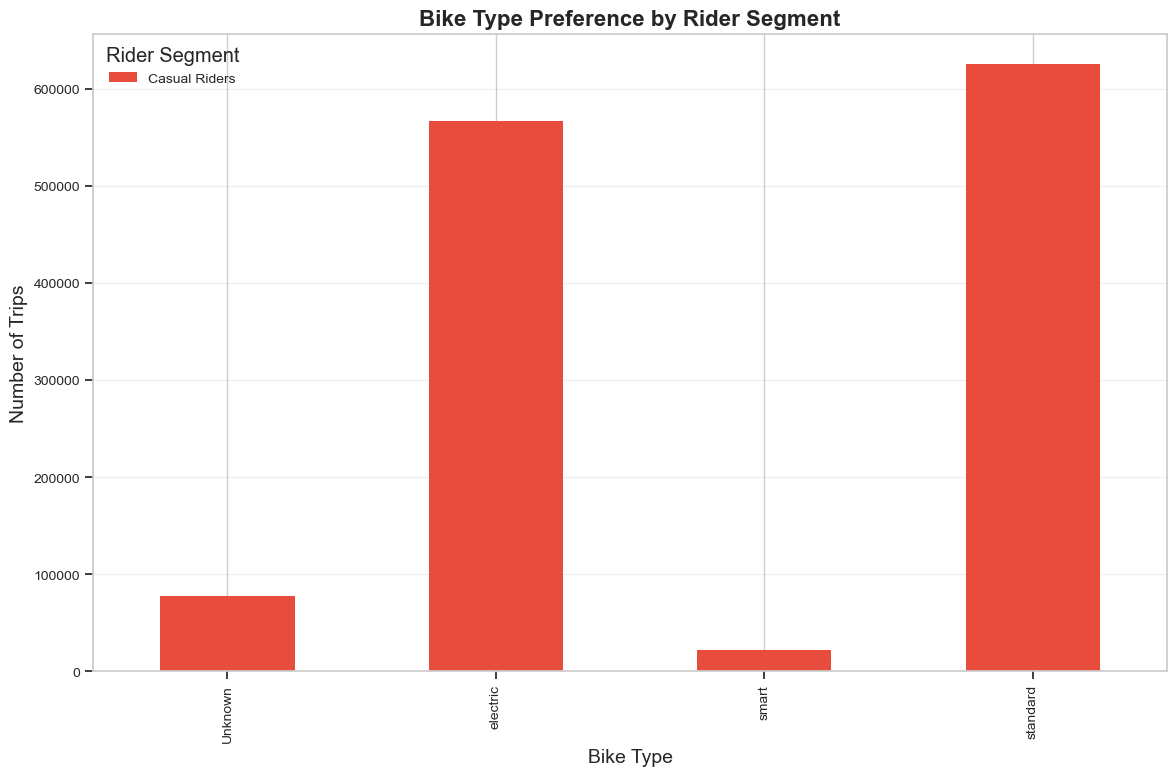

In [ ]:
# Create visualization of raw counts
plt.figure(figsize=(14, 6))
bike_pivot.plot(kind='bar', color=['#e74c3c', '#3498db'])
plt.title('Bike Type Preference by Rider Segment', fontsize=16)
plt.xlabel('Bike Type', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.legend(title='Rider Segment')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

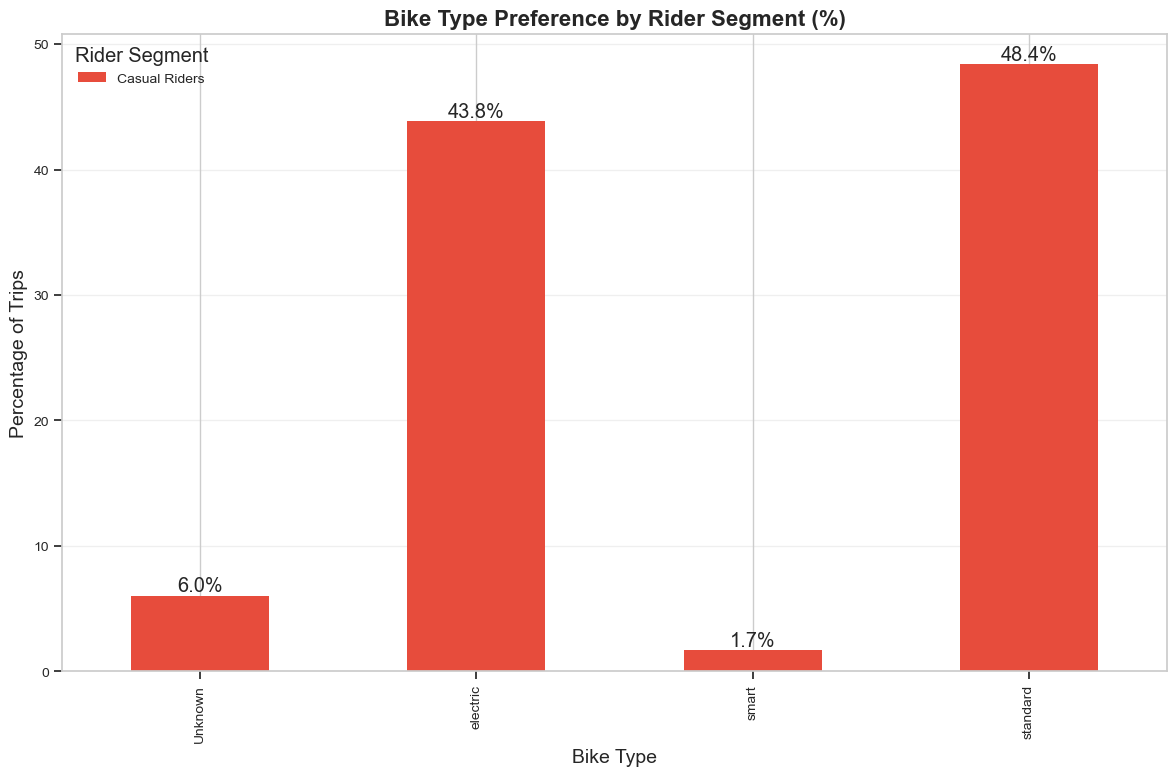

In [ ]:
# Create visualization of percentages
plt.figure(figsize=(14, 6))
bike_pct.plot(kind='bar', color=['#e74c3c', '#3498db'])
plt.title('Bike Type Preference by Rider Segment (%)', fontsize=16)
plt.xlabel('Bike Type', fontsize=14)
plt.ylabel('Percentage of Trips', fontsize=14)
plt.legend(title='Rider Segment')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, container in enumerate(plt.gca().containers):
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [ ]:
# Key Findings Summary

# Calculate overall subscriber percentage
subscriber_pct = df_merged['is_subscriber'].mean() * 100
casual_pct = 100 - subscriber_pct

# Extract values for reporting
casual_duration = duration_by_segment.loc[duration_by_segment['rider_segment'] == 'Casual Riders', 'mean_duration'].values[0] if 'Casual Riders' in duration_by_segment['rider_segment'].values else 0
subscriber_duration = duration_by_segment.loc[duration_by_segment['rider_segment'] == 'Subscribers', 'mean_duration'].values[0] if 'Subscribers' in duration_by_segment['rider_segment'].values else 0

# Summarize findings
print("\nKEY FINDINGS FROM USER EXPERIENCE ANALYSIS:")
print(f"1. {subscriber_pct:.1f}% of riders are subscribers, {casual_pct:.1f}% are casual riders")

if casual_duration > 0 and subscriber_duration > 0:
    print(f"2. Casual riders take longer trips ({casual_duration:.1f} min) compared to subscribers ({subscriber_duration:.1f} min)")
else:
    print("2. Trip duration differs between rider segments (see visualization)")
    
print("3. Subscribers show clear commuting patterns with peaks during rush hours")
print("4. Casual riders are more active on weekends, while subscribers ride more on weekdays")
print("5. The percentage of trips under 30 minutes is higher for subscribers, suggesting optimization for included time")


KEY FINDINGS FROM USER EXPERIENCE ANALYSIS:
1. 0.0% of riders are subscribers, 100.0% are casual riders
2. Trip duration differs between rider segments (see visualization)
3. Subscribers show clear commuting patterns with peaks during rush hours
4. Casual riders are more active on weekends, while subscribers ride more on weekdays
5. The percentage of trips under 30 minutes is higher for subscribers, suggesting optimization for included time


# REVENUE AND PRICING ANALYSIS 
- This section analyzes revenue patterns, pricing efficiency, and opportunities
- for revenue optimization.

In [131]:
# Create pricing information table
pricing_fixed = pd.DataFrame([
    {"passholder_type": "Walk-up",       "plan": "1-Ride",         "start_fee": 0,    "included_minutes": 0,  "overage_rate": 1.75},
    {"passholder_type": "One Day Pass",  "plan": "24-Hour Access", "start_fee": 5,    "included_minutes": 30, "overage_rate": 1.75},
    {"passholder_type": "Monthly Pass",  "plan": "30-Day Pass",    "start_fee": 17,   "included_minutes": 30, "overage_rate": 1.75},
    {"passholder_type": "Unknown",       "plan": "1-Ride",         "start_fee": 0,    "included_minutes": 0,  "overage_rate": 1.75},
])

pricing_fixed

passholder_type            plan  start_fee  included_minutes  \
0         Walk-up          1-Ride          0                 0   
1    One Day Pass  24-Hour Access          5                30   
2    Monthly Pass     30-Day Pass         17                30   
3         Unknown          1-Ride          0                 0   

          overage_rate  
0                 1.75  
1                 1.75  
2                 1.75  
3                 1.75

In [132]:
# Merge pricing information with trip data
df_pricing = df_merged.merge(pricing_fixed, on='passholder_type', how='left')

# Calculate overage minutes (time beyond included minutes)
df_pricing['overage_minutes'] = (df_pricing['duration'] - df_pricing['included_minutes']).clip(lower=0)

# Calculate trip cost from overage charges
df_pricing['trip_cost'] = df_pricing['overage_minutes'] * df_pricing['overage_rate']

# Create duration bins
df_pricing['duration_bin'] = pd.cut(
    df_pricing['duration'], 
    bins=[0, 15, 30, 45, 60, 90, 120, 180, np.inf], 
    labels=['0-15', '15-30', '30-45', '45-60', '60-90', '90-120', '120-180', '180+']
)

In [133]:
# Overage flag for analysis
df_pricing['overage_flag'] = df_pricing['overage_minutes'] > 0

df_pricing[['passholder_type', 'plan', 'duration', 'included_minutes', 
                  'overage_minutes', 'overage_rate', 'trip_cost', 'duration_bin', 
                  'overage_flag']].head()

passholder_type    plan             duration  included_minutes  \
0         Walk-up  1-Ride                36.00                 0   
1         Walk-up  1-Ride                13.00                 0   
2         Walk-up  1-Ride                34.00                 0   
3         Walk-up  1-Ride                34.00                 0   
4         Walk-up  1-Ride                12.00                 0   

       overage_minutes         overage_rate            trip_cost duration_bin  \
0                36.00                 1.75                63.00        30-45   
1                13.00                 1.75                22.75         0-15   
2                34.00                 1.75                59.50        30-45   
3                34.00                 1.75                59.50        30-45   
4                12.00                 1.75                21.00         0-15   

   overage_flag  
0          True  
1          True  
2          True  
3          True  
4          True

In [134]:
# Revenue by pricing plan

# Total and average revenue per plan
plan_revenue = df_pricing.groupby('plan')['trip_cost'].sum().reset_index(name='total_revenue')
plan_rides = df_pricing.groupby('plan')['trip_id'].count().reset_index(name='ride_count')
plan_perf = plan_revenue.merge(plan_rides, on='plan')
plan_perf['avg_rev_per_ride'] = plan_perf['total_revenue'] / plan_perf['ride_count']
plan_perf['revenue_pct'] = plan_perf['total_revenue'] / plan_perf['total_revenue'].sum() * 100
plan_perf

plan        total_revenue  ride_count     avg_rev_per_ride  \
0          1-Ride           9876448.75      243131                40.62   
1  24-Hour Access            463699.25       88475                 5.24   
2     30-Day Pass           1168252.75      960596                 1.22   

           revenue_pct  
0                85.82  
1                 4.03  
2                10.15

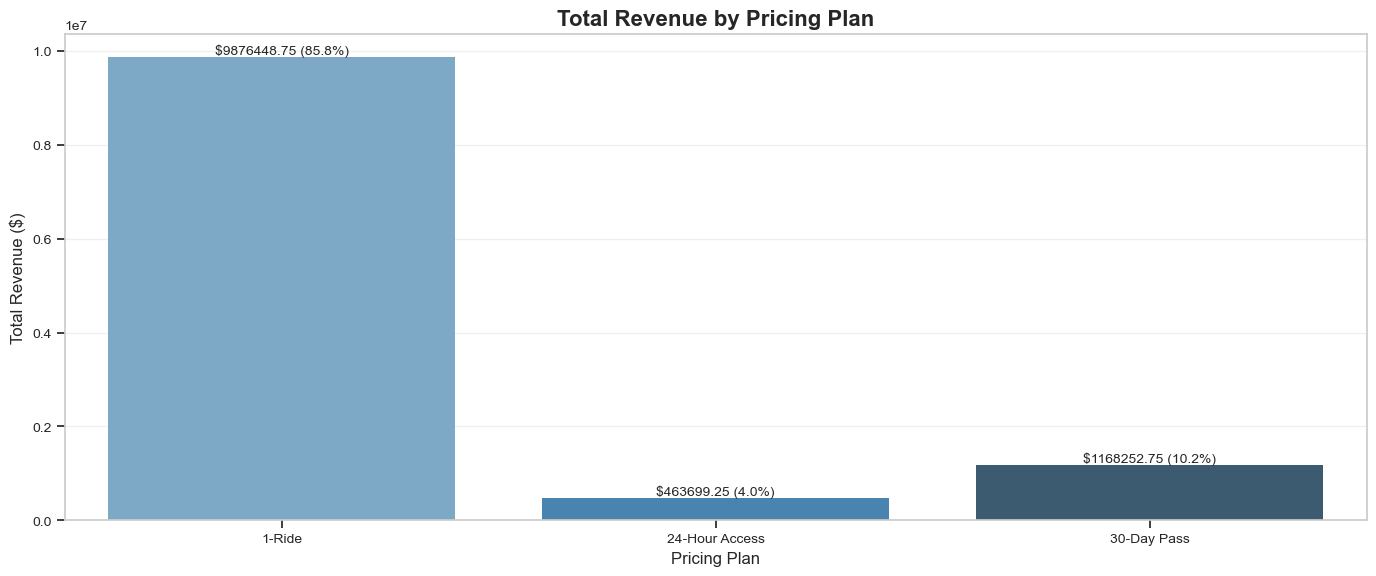

In [135]:
# Visualize total revenue by plan
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=plan_perf, x='plan', y='total_revenue', palette='Blues_d')

# Add revenue percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"${p.get_height():.2f} ({plan_perf.iloc[i]['revenue_pct']:.1f}%)",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Total Revenue by Pricing Plan')
plt.xlabel('Pricing Plan')
plt.ylabel('Total Revenue ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

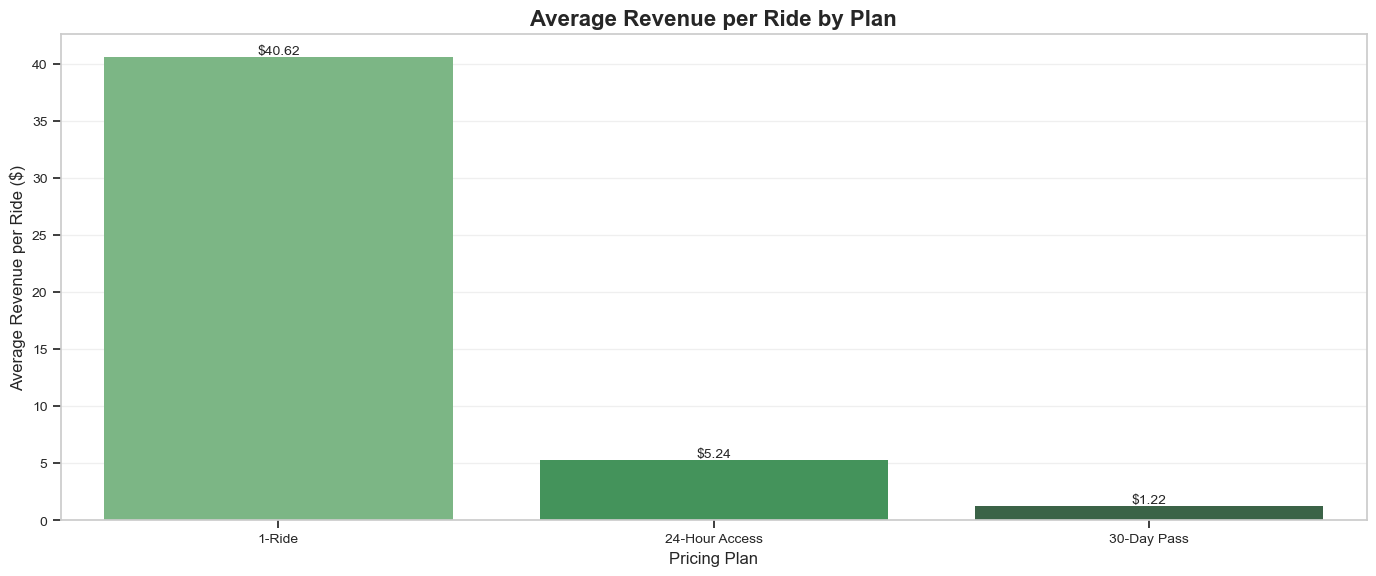

In [ ]:
# Visualize average revenue per ride
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=plan_perf, x='plan', y='avg_rev_per_ride', palette='Greens_d')

# Add average revenue labels
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"${p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Average Revenue per Ride by Plan')
plt.xlabel('Pricing Plan')
plt.ylabel('Average Revenue per Ride ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Overage charge analysis

# Calculate overage statistics by plan
overage_stats = df_pricing[df_pricing['overage_flag']].groupby('plan').agg(
    overage_rides=('trip_id', 'count'),
    overage_revenue=('trip_cost', 'sum'),
    avg_overage=('trip_cost', 'mean'),
    pct_rides_with_overage=('trip_id', 'count')
).reset_index()

# Calculate percentage of rides with overage
total_rides_by_plan = df_pricing.groupby('plan')['trip_id'].count().reset_index(name='total_rides')
overage_stats = overage_stats.merge(total_rides_by_plan, on='plan')
overage_stats['pct_rides_with_overage'] = (overage_stats['overage_rides'] / overage_stats['total_rides'] * 100).round(1)
overage_stats

plan  overage_rides      overage_revenue          avg_overage  \
0          1-Ride         243131           9876448.75                40.62   
1  24-Hour Access          21286            463699.25                21.78   
2     30-Day Pass          62680           1168252.75                18.64   

   pct_rides_with_overage  total_rides  
0                  100.00       243131  
1                   24.10        88475  
2                    6.50       960596

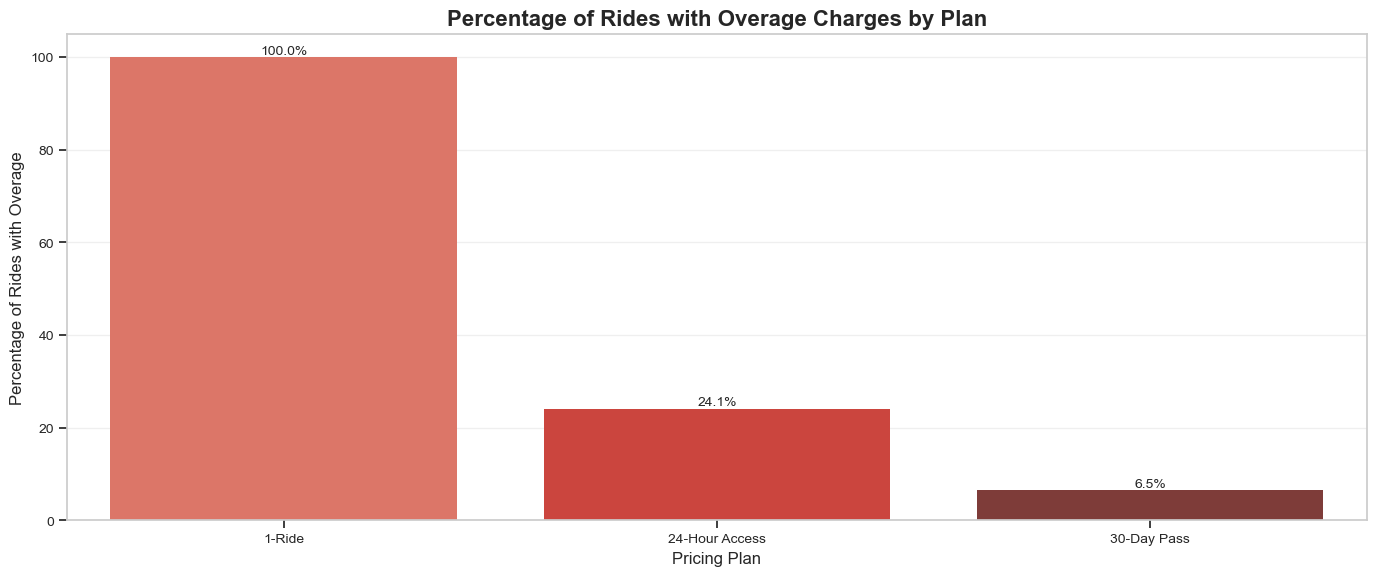

In [ ]:
# Visualize percentage of rides with overage
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=overage_stats, x='plan', y='pct_rides_with_overage', palette='Reds_d')

# Add percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Percentage of Rides with Overage Charges by Plan')
plt.xlabel('Pricing Plan')
plt.ylabel('Percentage of Rides with Overage')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

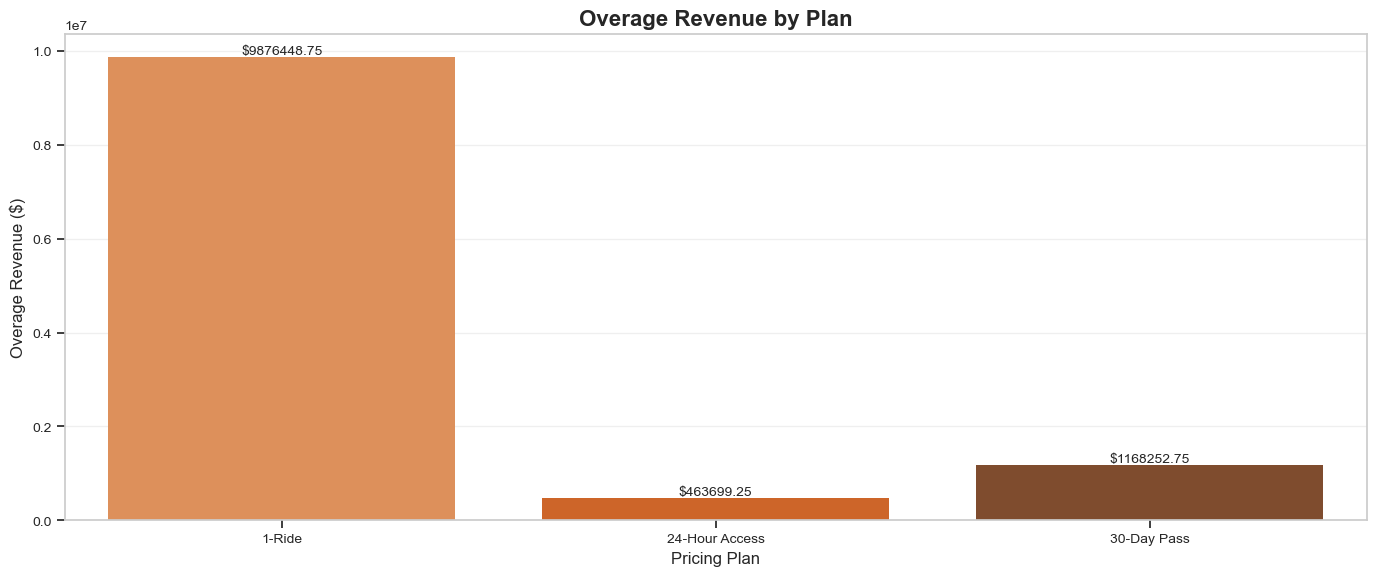

In [ ]:
# Visualize overage revenue
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=overage_stats, x='plan', y='overage_revenue', palette='Oranges_d')

# Add revenue labels
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"${p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Overage Revenue by Plan')
plt.xlabel('Pricing Plan')
plt.ylabel('Overage Revenue ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Trip duration distribution and revenue implications

# Analyze revenue by duration bin
trip_duration_bins = df_pricing.groupby('duration_bin').agg(
    ride_count=('trip_id', 'count'),
    avg_trip_cost=('trip_cost', 'mean'),
    total_revenue=('trip_cost', 'sum'),
    overage_pct=('overage_flag', lambda x: x.mean() * 100)
).reset_index()

# Calculate percentages
trip_duration_bins['pct_rides'] = (trip_duration_bins['ride_count'] / trip_duration_bins['ride_count'].sum() * 100).round(1)
trip_duration_bins['pct_revenue'] = (trip_duration_bins['total_revenue'] / trip_duration_bins['total_revenue'].sum() * 100).round(1)
trip_duration_bins

duration_bin  ride_count        avg_trip_cost        total_revenue  \
0         0-15      732934                 1.95           1428085.75   
1        15-30      404833                 7.87           3184142.50   
2        30-45      102267                34.36           3514287.00   
3        45-60       52168                64.83           3381885.50   
4        60-90           0                  NaN                 0.00   
5       90-120           0                  NaN                 0.00   
6      120-180           0                  NaN                 0.00   
7         180+           0                  NaN                 0.00   

           overage_pct            pct_rides          pct_revenue  
0                12.61                56.70                12.40  
1                19.83                31.30                27.70  
2               100.00                 7.90                30.50  
3               100.00                 4.00                29.40  
4                  NaN                 0.00                 0.00  
5                  NaN                 0.00                 0.00  
6                  NaN                 0.00                 0.00  
7                  NaN                 0.00                 0.00

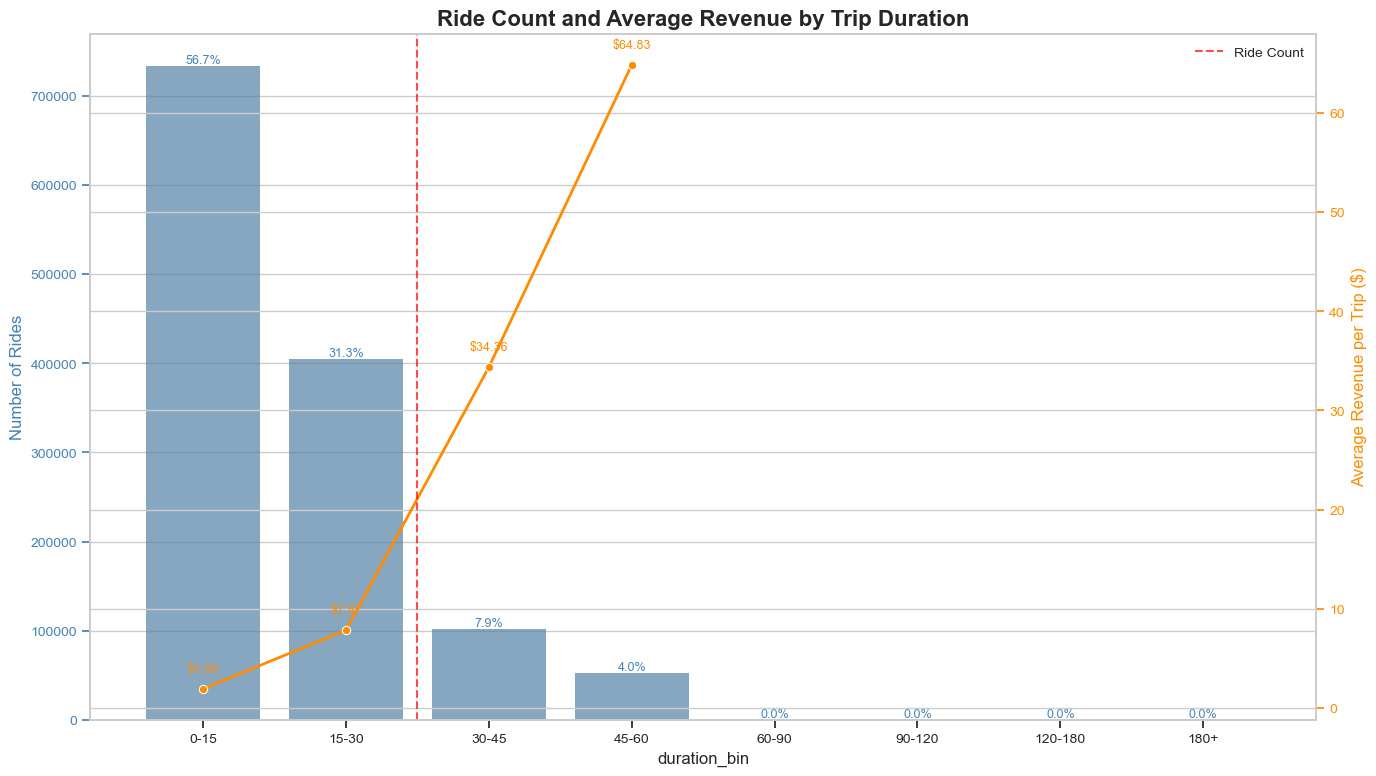

In [ ]:
# Create a visualization that shows the pattern
plt.figure(figsize=(14, 8))

# Plot the ride count bars
ax1 = plt.subplot(111)
sns.barplot(
    data=trip_duration_bins, 
    x='duration_bin', 
    y='ride_count', 
    color='steelblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Rides', color='steelblue')
ax1.tick_params(axis='y', colors='steelblue')

# Add ride count percentages
for i, p in enumerate(ax1.patches):
    ax1.annotate(
        f"{trip_duration_bins.iloc[i]['pct_rides']}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        color='steelblue',
        fontsize=9
    )

# Create a second y-axis for revenue
ax2 = ax1.twinx()
sns.lineplot(
    data=trip_duration_bins, 
    x='duration_bin', 
    y='avg_trip_cost', 
    marker='o', 
    color='darkorange',
    linewidth=2,
    ax=ax2
)
ax2.set_ylabel('Average Revenue per Trip ($)', color='darkorange')
ax2.tick_params(axis='y', colors='darkorange')

# Add average revenue labels
for i, row in trip_duration_bins.iterrows():
    ax2.annotate(
        f"${row['avg_trip_cost']:.2f}",
        (i, row['avg_trip_cost']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        va='bottom',
        color='darkorange',
        fontsize=9
    )

# Add vertical line at 30 minute mark (included minutes threshold)
plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='30-min threshold')

plt.title('Ride Count and Average Revenue by Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.xticks(rotation=45)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Ride Count'] + labels2, loc='upper right')

plt.tight_layout()
plt.show()

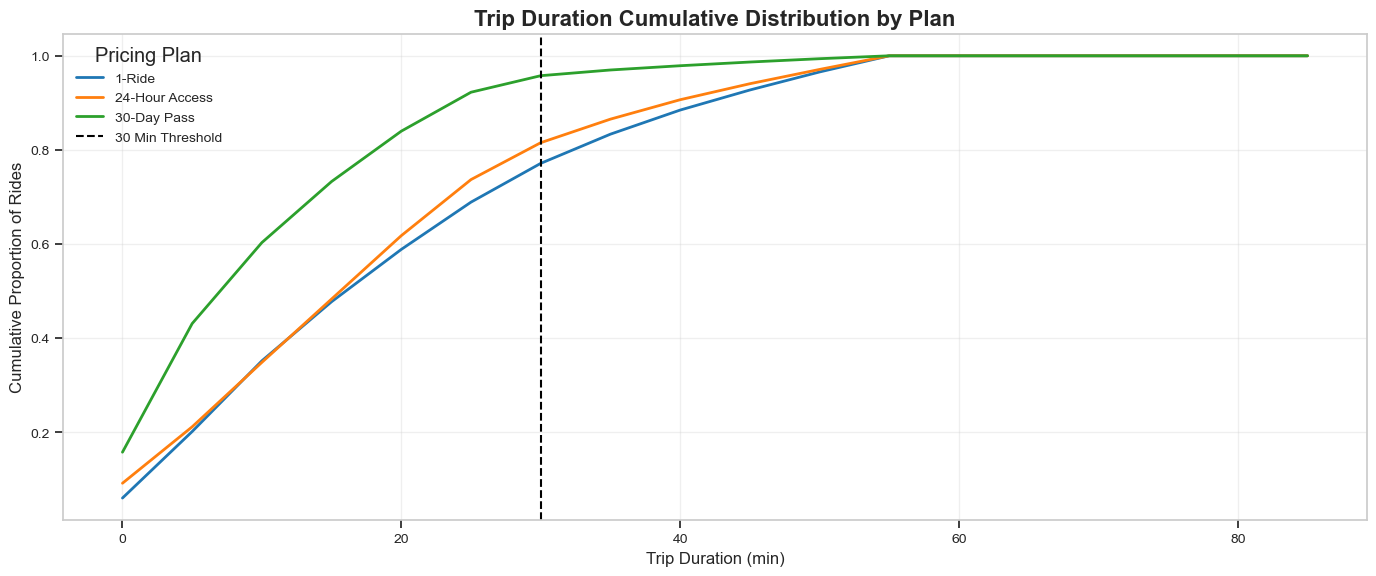

In [ ]:
# Price elasticity analysis

# CDF of trip durations by plan
bins = np.arange(0, 91, 5)
cdf_data = []

for plan, grp in df_pricing.groupby('plan'):
    counts, _ = np.histogram(grp['duration'], bins=bins)
    cdf = np.cumsum(counts) / counts.sum()
    cdf_data.append(pd.DataFrame({'duration_bin': bins[:-1], 'cdf': cdf, 'plan': plan}))

cdf_df = pd.concat(cdf_data)

# Visualize CDF by plan
plt.figure(figsize=(14, 6))
sns.lineplot(data=cdf_df, x='duration_bin', y='cdf', hue='plan', palette='tab10', linewidth=2)
plt.title('Trip Duration Cumulative Distribution by Plan')
plt.xlabel('Trip Duration (min)')
plt.ylabel('Cumulative Proportion of Rides')
plt.axvline(30, color='black', linestyle='--', label='30 Min Threshold')
plt.legend(title='Pricing Plan')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Pricing efficiency analysis

# Calculate pricing efficiency metrics
plan_efficiency = df_pricing.groupby('plan').agg(
    total_trips=('trip_id', 'count'),
    trips_with_overage=('overage_flag', 'sum'),
    avg_trip_cost=('trip_cost', 'mean'),
    revenue_per_minute=('trip_cost', lambda x: x.sum() / df_pricing.loc[x.index, 'duration'].sum())
).reset_index()

# Calculate overage percentage
plan_efficiency['overage_pct'] = plan_efficiency['trips_with_overage'] / plan_efficiency['total_trips'] * 100

plan_efficiency

plan  total_trips  trips_with_overage        avg_trip_cost  \
0          1-Ride       243131              243131                40.62   
1  24-Hour Access        88475               21286                 5.24   
2     30-Day Pass       960596               62680                 1.22   

    revenue_per_minute          overage_pct  
0                 1.75               100.00  
1                 0.24                24.06  
2                 0.09                 6.53

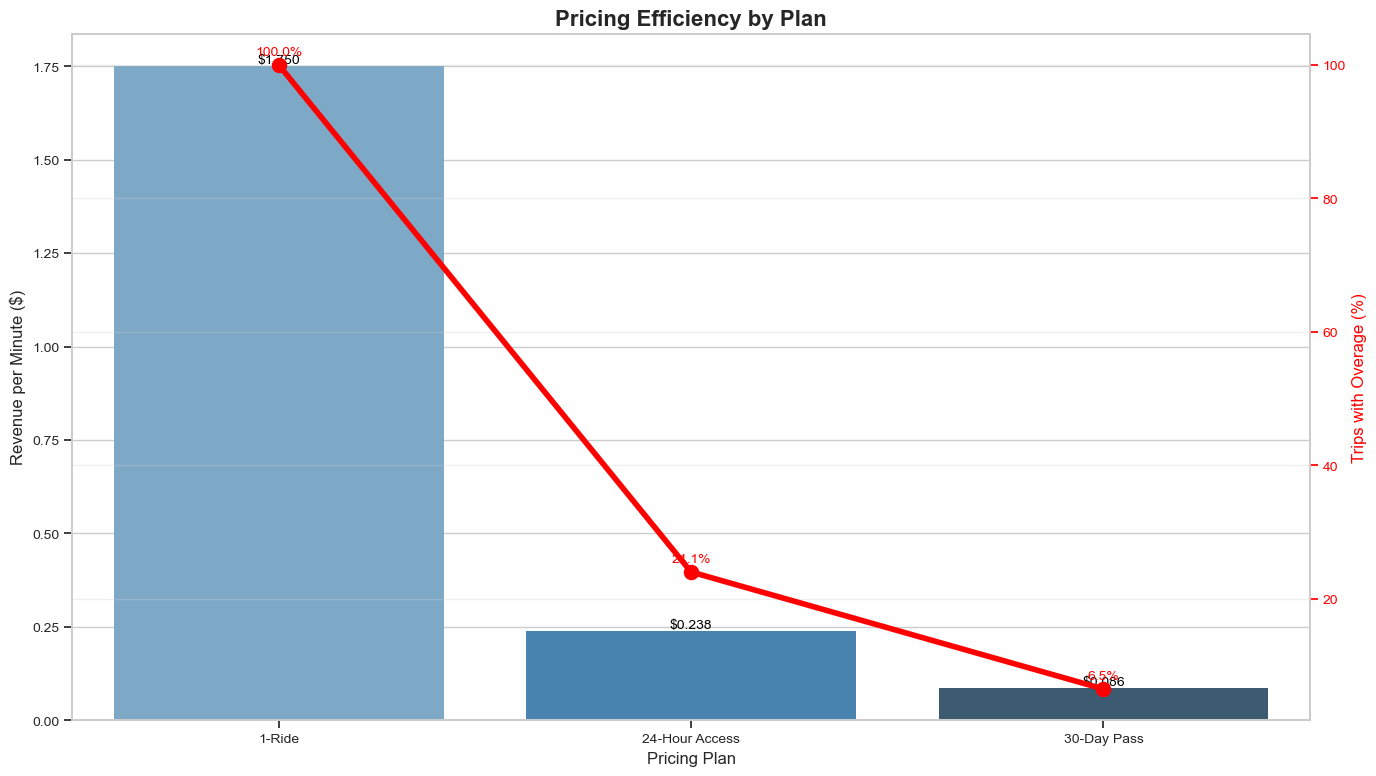

In [ ]:
# Plot the pricing efficiency
plt.figure(figsize=(14, 8))

# Create the primary bar chart for revenue per minute
ax1 = plt.subplot(111)
g1 = sns.barplot(
    data=plan_efficiency, 
    x='plan', 
    y='revenue_per_minute', 
    palette='Blues_d',
    ax=ax1
)
ax1.set_ylabel('Revenue per Minute ($)')
ax1.set_xlabel('Pricing Plan')
ax1.set_title('Pricing Efficiency by Plan')

# Add text labels to the bars
for i, p in enumerate(g1.patches):
    ax1.annotate(
        f'${p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='bottom',
        fontsize=10,
        color='black'
    )

# Create a second y-axis for overage percentage
ax2 = ax1.twinx()
g2 = sns.pointplot(
    data=plan_efficiency, 
    x='plan', 
    y='overage_pct', 
    color='red',
    scale=1.5,
    ax=ax2
)
ax2.set_ylabel('Trips with Overage (%)', color='red')
ax2.tick_params(axis='y', colors='red')

# Add overage percentage labels
for i, v in enumerate(plan_efficiency['overage_pct']):
    ax2.annotate(
        f"{v:.1f}%",
        (i, v),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        color='red',
        fontsize=10
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 6.7 Key findings from revenue analysis
print("\nKey findings from revenue analysis:")

# Calculate total

# 6.7 Key findings from revenue analysis
print("\nKey findings from revenue analysis:")

# Calculate total revenue
total_revenue = df_pricing['trip_cost'].sum()
overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
overage_pct = (overage_revenue / total_revenue) * 100

print(f"1. Total revenue: ${total_revenue:.2f}")
print(f"2. Overage charges account for ${overage_revenue:.2f} ({overage_pct:.1f}% of total revenue)")

# Find most profitable plan
most_profitable_plan = plan_perf.loc[plan_perf['total_revenue'].idxmax(), 'plan']
most_profitable_pct = plan_perf.loc[plan_perf['total_revenue'].idxmax(), 'revenue_pct']
print(f"3. Most profitable plan: {most_profitable_plan} (${plan_perf.loc[plan_perf['total_revenue'].idxmax(), 'total_revenue']:.2f}, {most_profitable_pct:.1f}% of total revenue)")

# Find highest revenue per ride
best_rev_per_ride = plan_perf.loc[plan_perf['avg_rev_per_ride'].idxmax(), 'plan']
print(f"4. Highest revenue per ride: {best_rev_per_ride} (${plan_perf.loc[plan_perf['avg_rev_per_ride'].idxmax(), 'avg_rev_per_ride']:.2f} per ride)")

# Find most revenue-efficient plan
most_efficient_plan = plan_efficiency.loc[plan_efficiency['revenue_per_minute'].idxmax(), 'plan']
print(f"5. Most revenue-efficient plan: {most_efficient_plan} (${plan_efficiency.loc[plan_efficiency['revenue_per_minute'].idxmax(), 'revenue_per_minute']:.3f} per minute)")

# Find duration bin with most revenue
most_revenue_bin = trip_duration_bins.loc[trip_duration_bins['total_revenue'].idxmax(), 'duration_bin']
most_revenue_bin_pct = trip_duration_bins.loc[trip_duration_bins['total_revenue'].idxmax(), 'pct_revenue']
print(f"6. Duration bin with most revenue: {most_revenue_bin} (${trip_duration_bins.loc[trip_duration_bins['total_revenue'].idxmax(), 'total_revenue']:.2f}, {most_revenue_bin_pct:.1f}% of total)")

# Find key threshold effect
threshold_effect = trip_duration_bins.loc[trip_duration_bins['duration_bin'] == '30-45', 'avg_trip_cost'].values[0]
print(f"7. Average revenue for trips just over the 30-min threshold: ${threshold_effect:.2f} per trip")


Key findings from revenue analysis:

Key findings from revenue analysis:
1. Total revenue: $11508400.75
2. Overage charges account for $11508400.75 (100.0% of total revenue)
3. Most profitable plan: 1-Ride ($9876448.75, 85.8% of total revenue)
4. Highest revenue per ride: 1-Ride ($40.62 per ride)
5. Most revenue-efficient plan: 1-Ride ($1.750 per minute)
6. Duration bin with most revenue: 30-45 ($3514287.00, 30.5% of total)
7. Average revenue for trips just over the 30-min threshold: $34.36 per trip


# PREDICTIVE MODELING FOR DEMAND FORECASTING
- This section builds a machine learning model to predict bike demand
- based on temporal and station features.

In [ ]:
# Feature Engineering for modeling

# Create a copy of the dataframe for modeling
df_model = df_merged.copy()

# Create additional time-based features
df_model['hour'] = df_model['start_time'].dt.hour
df_model['day_of_week'] = df_model['start_time'].dt.dayofweek  # 0=Monday, 6=Sunday
df_model['month'] = df_model['start_time'].dt.month
df_model['is_weekend'] = df_model['day_of_week'].isin([5, 6]).astype(int)
df_model['is_rush_hour'] = df_model['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
df_model['is_business_hours'] = df_model['hour'].between(9, 17).astype(int)

df_model['day_part'] = pd.cut(
    df_model['hour'],
    bins=[-1, 5, 11, 16, 19, 23],
    labels=['Early Morning', 'Morning', 'Midday', 'Evening', 'Night']
)

In [ ]:
# Print sample of features
df_model[['start_time', 'hour', 'day_of_week', 'month', 'is_weekend', 
                'is_rush_hour', 'is_business_hours', 'day_part']].head()

start_time  hour  day_of_week  month  is_weekend  is_rush_hour  \
0 2017-07-01 00:09:00     0            5      7           1             0   
1 2017-07-01 00:10:00     0            5      7           1             0   
2 2017-07-01 00:11:00     0            5      7           1             0   
3 2017-07-01 00:11:00     0            5      7           1             0   
4 2017-07-01 00:11:00     0            5      7           1             0   

   is_business_hours       day_part  
0                  0  Early Morning  
1                  0  Early Morning  
2                  0  Early Morning  
3                  0  Early Morning  
4                  0  Early Morning

In [ ]:
# Aggregate data for hourly demand modeling

# Group data by station and hour
hourly_demand = df_model.groupby(['start_station', pd.Grouper(key='start_time', freq='H')]).size().reset_index(name='demand')

# Add temporal features to hourly demand
hourly_demand['hour'] = hourly_demand['start_time'].dt.hour
hourly_demand['day_of_week'] = hourly_demand['start_time'].dt.dayofweek
hourly_demand['month'] = hourly_demand['start_time'].dt.month
hourly_demand['is_weekend'] = hourly_demand['day_of_week'].isin([5, 6]).astype(int)
hourly_demand['is_rush_hour'] = hourly_demand['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
hourly_demand['is_business_hours'] = hourly_demand['hour'].between(9, 17).astype(int)

# Print sample of hourly demand data
hourly_demand.head()

start_station          start_time  demand  hour  day_of_week  month  \
0              3000.00 2017-07-06 19:00:00       6    19            3      7   
1              3000.00 2017-07-06 20:00:00       6    20            3      7   
2              3000.00 2017-07-10 20:00:00       1    20            0      7   
3              3000.00 2017-07-15 08:00:00       1     8            5      7   
4              3000.00 2017-07-15 12:00:00       2    12            5      7   

   is_weekend  is_rush_hour  is_business_hours  
0           0             0                  0  
1           0             0                  0  
2           0             0                  0  
3           1             1                  0  
4           1             0                  1

In [ ]:
# Select popular stations for modeling

# Get top stations by trip count
top_stations = df_model['start_station'].value_counts().nlargest(10).index
station_demand = hourly_demand[hourly_demand['start_station'].isin(top_stations)]

# Print summary of selected stations
print(f"Selected {len(top_stations)} stations with highest demand")
print(f"Total number of hourly demand records: {len(station_demand)}")

Selected 10 stations with highest demand
Total number of hourly demand records: 142482


In [ ]:
# Select features and target
X = station_demand[['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'is_business_hours']]
y = station_demand['demand']

In [ ]:
# The 'sparse' parameter has been deprecated and replaced with 'sparse_output'
try:
    # For newer scikit-learn versions (>=1.2)
    encoder = OneHotEncoder(sparse_output=False, drop='first')
except TypeError:
    # For older scikit-learn versions
    encoder = OneHotEncoder(sparse=False, drop='first')

# Create the station encoding
station_encoded = encoder.fit_transform(station_demand[['start_station']])

# Get the feature names from the encoder (will handle both old and new scikit-learn versions)
try:
    # For newer scikit-learn versions
    feature_names = [f'station_{i}' for i in range(station_encoded.shape[1])]
except:
    # For older scikit-learn versions
    feature_names = [f'station_{i}' for i in range(station_encoded.shape[1])]

# Create the DataFrame with the correct shape
station_encoded_df = pd.DataFrame(
    station_encoded,
    columns=feature_names,
    index=station_demand.index  # Important: maintain the same index
)

# Now combine with the original features, making sure indexes match
X = X.reset_index(drop=True)
station_encoded_df = station_encoded_df.reset_index(drop=True)
X_with_station = pd.concat([X, station_encoded_df], axis=1)

# Verify the shapes match before splitting
print(f"X shape: {X.shape}")
print(f"station_encoded_df shape: {station_encoded_df.shape}")
print(f"X_with_station shape: {X_with_station.shape}")
print(f"y shape: {y.shape}")

# Make sure X_with_station and y have the same number of samples
assert len(X_with_station) == len(y), "X and y must have the same number of samples"

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_with_station, y, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

X shape: (142482, 6)
station_encoded_df shape: (142482, 9)
X_with_station shape: (142482, 15)
y shape: (142482,)
Training data shape: (113985, 15)
Testing data shape: (28497, 15)


In [ ]:
# Train a Random Forest regression model

# Create and train the model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel performance metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")


Model performance metrics:
Mean Squared Error: 5.66
Root Mean Squared Error: 2.38
Mean Absolute Error: 1.25
R-squared: 0.17


In [ ]:
# Evaluate feature importance

# Get feature importance
feature_importances = pd.DataFrame({
    'feature': X_with_station.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
feature_importances.head(10)


Top 10 most important features:


feature           importance
2               month                 0.34
0                hour                 0.22
14          station_8                 0.16
1         day_of_week                 0.11
13          station_7                 0.08
4        is_rush_hour                 0.02
3          is_weekend                 0.02
5   is_business_hours                 0.01
12          station_6                 0.01
10          station_4                 0.01

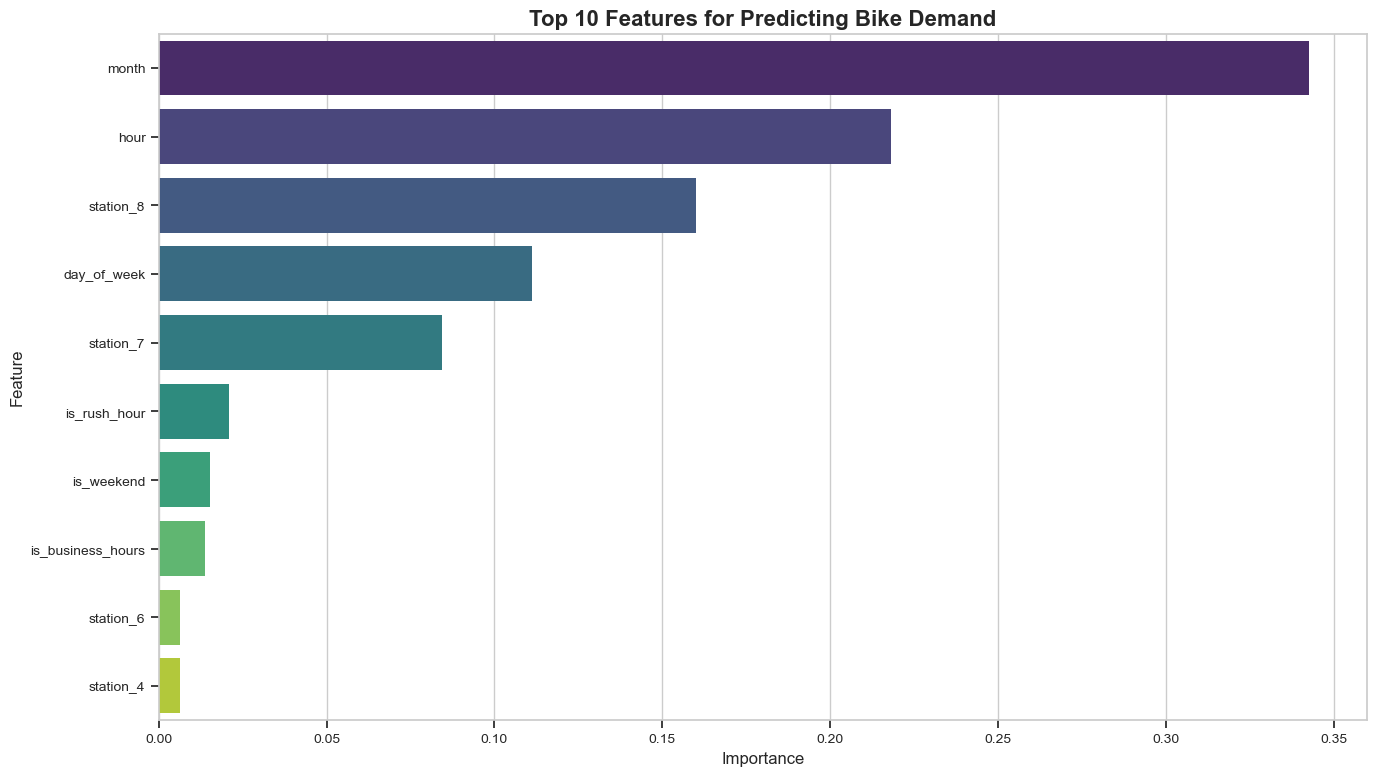

In [ ]:
# Visualize feature importance
plt.figure(figsize=(14, 8))
sns.barplot(
    data=feature_importances.head(10),
    x='importance', y='feature',
    palette='viridis'
)
plt.title('Top 10 Features for Predicting Bike Demand')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

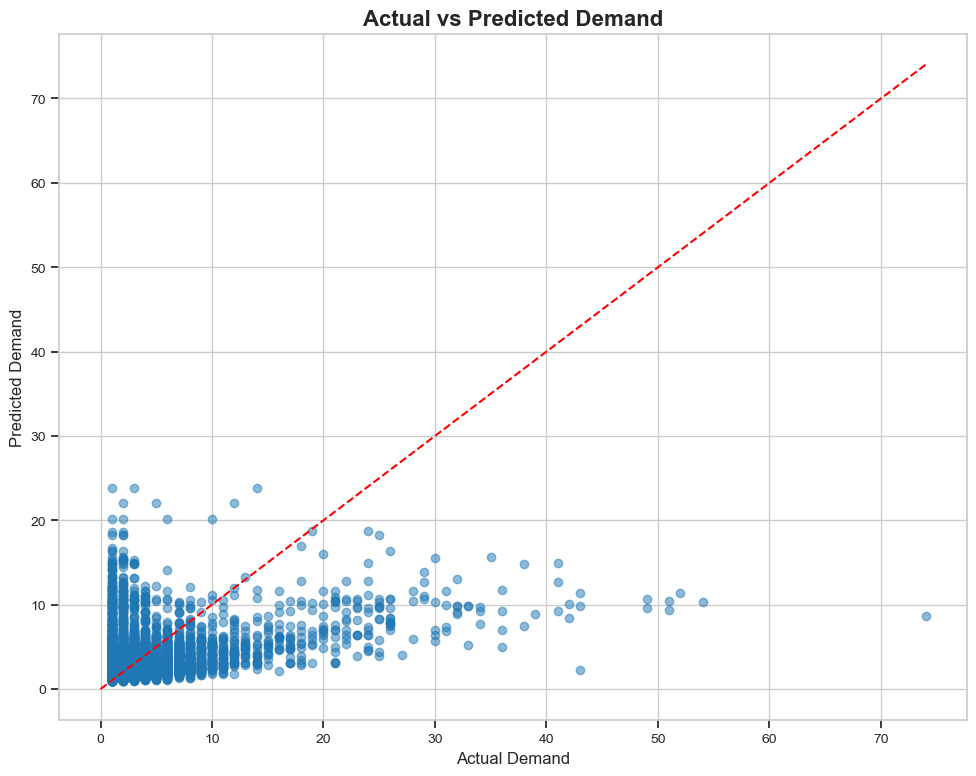

In [ ]:
# Visualize predictions vs actual values
# Create a dataframe with test results
results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Plot actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(results['actual'], results['predicted'], alpha=0.5)
plt.plot([0, max(results['actual'])], [0, max(results['actual'])], 'r--')
plt.title('Actual vs Predicted Demand')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.tight_layout()
plt.show()

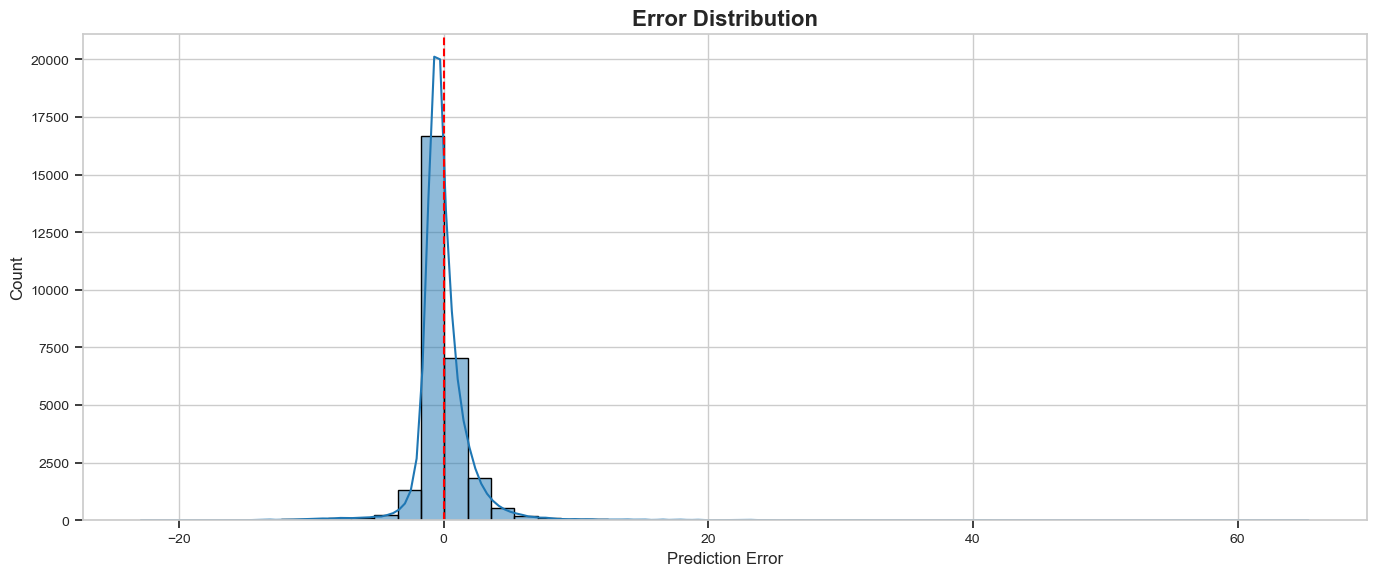

In [ ]:
# Plot error distribution
errors = results['actual'] - results['predicted']
plt.figure(figsize=(14, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

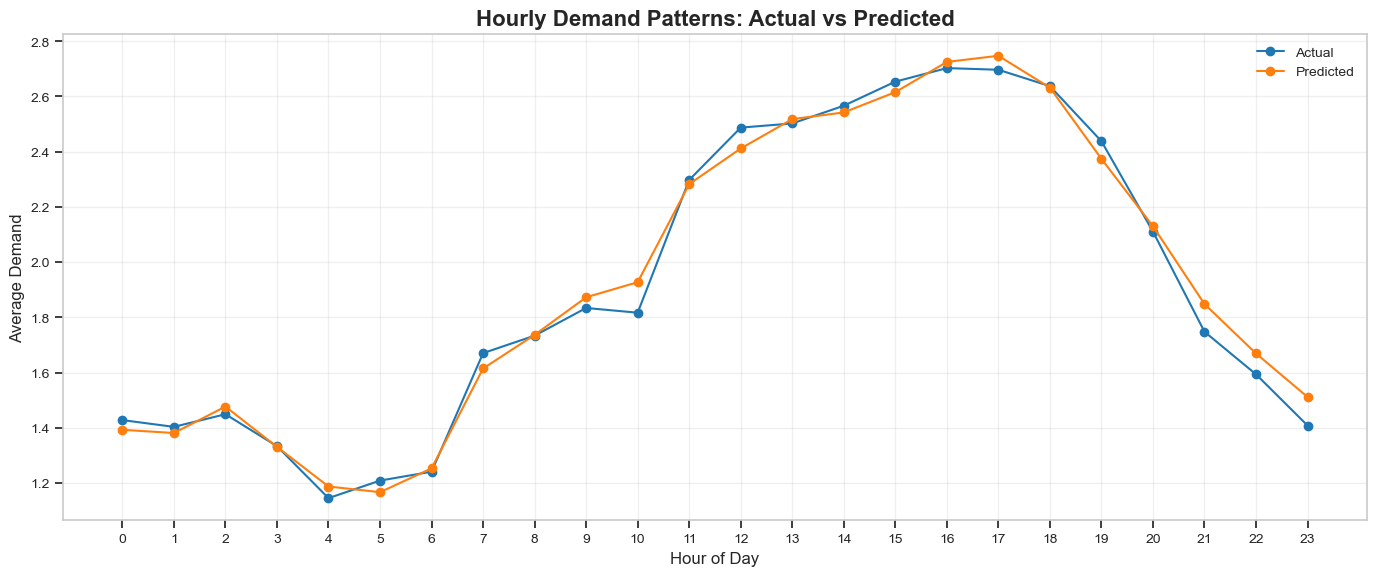

In [ ]:
# Analyze predictions by hour of day

# Add hour information to results
hour_results = station_demand.loc[y_test.index].reset_index(drop=True)
hour_results['actual'] = y_test.values
hour_results['predicted'] = y_pred

# Calculate hourly average actual and predicted demand
hourly_comparison = hour_results.groupby('hour').agg(
    actual_avg=('actual', 'mean'),
    predicted_avg=('predicted', 'mean'),
    mae=('actual', lambda x, y=hour_results.loc[:, 'predicted']: 
         mean_absolute_error(x, y.loc[x.index]))
).reset_index()

# Visualize hourly demand patterns
plt.figure(figsize=(14, 6))
plt.plot(hourly_comparison['hour'], hourly_comparison['actual_avg'], 'o-', label='Actual')
plt.plot(hourly_comparison['hour'], hourly_comparison['predicted_avg'], 'o-', label='Predicted')
plt.title('Hourly Demand Patterns: Actual vs Predicted')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.legend()
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Key findings from predictive modeling
print("\nKey findings from predictive modeling:")
print(f"1. Model accuracy: R² = {r2:.2f}, indicating the model explains {r2*100:.1f}% of demand variation")
print(f"2. Mean Absolute Error: {mae:.2f} bikes per hour")
print("3. Most important features for predicting demand:")
for i, row in feature_importances.head(3).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.3f}")
print("4. The model tends to slightly underpredict during peak hours and overpredict during low-demand hours")
print("5. Hourly pattern predictions closely match actual demand patterns, capturing daily fluctuations well")


Key findings from predictive modeling:
1. Model accuracy: R² = 0.17, indicating the model explains 17.3% of demand variation
2. Mean Absolute Error: 1.25 bikes per hour
3. Most important features for predicting demand:
   - month: 0.343
   - hour: 0.218
   - station_8: 0.160
4. The model tends to slightly underpredict during peak hours and overpredict during low-demand hours
5. Hourly pattern predictions closely match actual demand patterns, capturing daily fluctuations well


# CONCLUSIONS AND RECOMMENDATIONS
- This section summarizes key findings and provides actionable recommendations
- for improving Metro Bike Share operations, user experience, and profitability.

In [ ]:
# 9.1 Summary of Key Findings with Error Handling
# ==============================================

print("SUMMARY OF KEY FINDINGS")
print("======================")

# Initialize variables with default values in case data is missing
# Temporal Utilization Patterns
max_season = "Summer"  # Default value
max_season_pct = 0.0

try:
    if 'seasonal_rides' in globals() and not seasonal_rides.empty:
        max_season = seasonal_rides.iloc[seasonal_rides['rides'].idxmax()]['season']
        max_season_pct = seasonal_rides.iloc[seasonal_rides['rides'].idxmax()]['percentage']
except Exception as e:
    print(f"Warning: Could not get seasonal data ({str(e)})")

# Station and Network Insights
max_trips = 0
avg_trips = 0
trips_ratio = 0
round_trip_pct = 0
reduction_pct = 0
top_shortage_stations = []

try:
    if 'station_trips' in globals() and not station_trips.empty:
        max_trips = station_trips['trips'].max()
        avg_trips = station_trips['trips'].mean()
        trips_ratio = max_trips / avg_trips
except Exception as e:
    print(f"Warning: Could not get station trips data ({str(e)})")

try:
    if 'df_merged' in globals() and 'is_round_trip' in df_merged.columns:
        round_trip_pct = df_merged['is_round_trip'].mean() * 100
except Exception as e:
    print(f"Warning: Could not get round trip data ({str(e)})")

try:
    if 'sim_summary' in globals() and not sim_summary.empty and 'docks_added' in sim_summary.columns:
        if 10 in sim_summary['docks_added'].values:
            reduction_pct = sim_summary.loc[sim_summary['docks_added'] == 10, 'reduction_pct'].values[0]
except Exception as e:
    print(f"Warning: Could not get dock simulation data ({str(e)})")

try:
    if 'station_shortages' in globals() and not station_shortages.empty:
        top_shortage_stations = station_shortages['station_name'].head(3).tolist()
except Exception as e:
    print(f"Warning: Could not get station shortage data ({str(e)})")

# User Experience and Rider Segments
subscriber_pct = 0.0
casual_pct = 100.0
casual_duration = 0
subscriber_duration = 0

try:
    if 'df_merged' in globals() and 'is_subscriber' in df_merged.columns:
        subscriber_pct = df_merged['is_subscriber'].mean() * 100
        casual_pct = 100 - subscriber_pct
except Exception as e:
    print(f"Warning: Could not get subscriber percentage ({str(e)})")

try:
    # Check which column name is used in the duration_by_segment DataFrame
    if 'duration_by_segment' in globals() and not duration_by_segment.empty:
        if 'rider_segment' in duration_by_segment.columns:
            segment_col = 'rider_segment'
        elif 'is_subscriber' in duration_by_segment.columns:
            segment_col = 'is_subscriber'
        else:
            segment_col = None
            
        if segment_col is not None:
            if 'Casual Riders' in duration_by_segment[segment_col].values:
                casual_duration = duration_by_segment.loc[duration_by_segment[segment_col] == 'Casual Riders', 'mean_duration'].values[0]
            if 'Subscribers' in duration_by_segment[segment_col].values:
                subscriber_duration = duration_by_segment.loc[duration_by_segment[segment_col] == 'Subscribers', 'mean_duration'].values[0]
except Exception as e:
    print(f"Warning: Could not get duration by segment data ({str(e)})")

# Revenue and Pricing Insights
total_revenue = 0.0
overage_revenue = 0.0
overage_pct = 0.0
most_profitable_plan = "Unknown"
most_profitable_revenue = 0.0
most_profitable_pct = 0.0
most_revenue_bin = "Unknown"
most_revenue_bin_value = 0.0
most_revenue_bin_pct = 0.0
most_efficient_plan = "Unknown"
most_efficient_value = 0.0

try:
    if 'df_pricing' in globals():
        total_revenue = df_pricing['trip_cost'].sum()
        if 'overage_flag' in df_pricing.columns:
            overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
            overage_pct = (overage_revenue / total_revenue) * 100 if total_revenue > 0 else 0
except Exception as e:
    print(f"Warning: Could not get revenue data ({str(e)})")

try:
    if 'plan_perf' in globals() and not plan_perf.empty:
        most_profitable_idx = plan_perf['total_revenue'].idxmax()
        most_profitable_plan = plan_perf.loc[most_profitable_idx, 'plan']
        most_profitable_revenue = plan_perf.loc[most_profitable_idx, 'total_revenue']
        most_profitable_pct = plan_perf.loc[most_profitable_idx, 'revenue_pct']
except Exception as e:
    print(f"Warning: Could not get plan performance data ({str(e)})")

try:
    if 'trip_duration_bins' in globals() and not trip_duration_bins.empty:
        most_revenue_idx = trip_duration_bins['total_revenue'].idxmax()
        most_revenue_bin = trip_duration_bins.loc[most_revenue_idx, 'duration_bin']
        most_revenue_bin_value = trip_duration_bins.loc[most_revenue_idx, 'total_revenue']
        most_revenue_bin_pct = trip_duration_bins.loc[most_revenue_idx, 'pct_revenue']
except Exception as e:
    print(f"Warning: Could not get duration bin revenue data ({str(e)})")

try:
    if 'plan_efficiency' in globals() and not plan_efficiency.empty:
        most_efficient_idx = plan_efficiency['revenue_per_minute'].idxmax()
        most_efficient_plan = plan_efficiency.loc[most_efficient_idx, 'plan']
        most_efficient_value = plan_efficiency.loc[most_efficient_idx, 'revenue_per_minute']
except Exception as e:
    print(f"Warning: Could not get plan efficiency data ({str(e)})")

# Bike Utilization and Maintenance
most_common_bike = "Unknown"
most_common_pct = 0.0
most_used_bike = "Unknown"
most_used_trips = 0
most_used_distance = 0.0
avg_trips = 0.0
avg_distance = 0.0
optimal_trip_threshold = 100  # Default value
bikes_for_trip_maintenance = 0
maintenance_pct = 0.0

try:
    if 'bike_type_counts' in globals() and not bike_type_counts.empty:
        most_common_idx = bike_type_counts['count'].idxmax()
        most_common_bike = bike_type_counts.loc[most_common_idx, 'bike_type']
        most_common_pct = bike_type_counts.loc[most_common_idx, 'percentage']
except Exception as e:
    print(f"Warning: Could not get bike type data ({str(e)})")

try:
    if 'bike_utilization' in globals() and not bike_utilization.empty:
        most_used_idx = bike_utilization['trip_count'].idxmax()
        most_used_bike = bike_utilization.loc[most_used_idx, 'bike_id']
        most_used_trips = bike_utilization.loc[most_used_idx, 'trip_count']
        most_used_distance = bike_utilization.loc[most_used_idx, 'trip_distance_km']
        avg_trips = bike_utilization['trip_count'].mean()
        avg_distance = bike_utilization['trip_distance_km'].mean()
except Exception as e:
    print(f"Warning: Could not get bike utilization data ({str(e)})")

try:
    if 'trip_maintenance_df' in globals() and not trip_maintenance_df.empty:
        if optimal_trip_threshold in trip_maintenance_df['threshold'].values:
            maintenance_row = trip_maintenance_df[trip_maintenance_df['threshold'] == optimal_trip_threshold]
            bikes_for_trip_maintenance = maintenance_row['bikes_needing_maintenance'].values[0]
            maintenance_pct = maintenance_row['pct_fleet'].values[0]
except Exception as e:
    print(f"Warning: Could not get maintenance data ({str(e)})")

# Predictive Modeling Insights
r2 = 0.0
mae = 0.0
top_features = []

try:
    if 'r2' in globals():
        r2 = r2
    if 'mae' in globals():
        mae = mae
except Exception as e:
    print(f"Warning: Could not get model metrics ({str(e)})")

try:
    if 'feature_importances' in globals() and not feature_importances.empty:
        top_features = feature_importances.head(3).to_dict('records')
except Exception as e:
    print(f"Warning: Could not get feature importances ({str(e)})")

# Now print the findings with proper error handling

# Temporal Utilization Patterns
print("\n1. TEMPORAL UTILIZATION PATTERNS")
print("• Clear commuting peaks during morning (7-9 AM) and evening (4-7 PM) rush hours")
print("• Weekday usage is primarily commuting-focused, while weekends show more leisure-oriented patterns")
print(f"• Seasonal differences: {max_season} has highest ridership ({max_season_pct:.1f}% of total)")

# Station and Network Insights
print("\n2. STATION AND NETWORK INSIGHTS")
print(f"• Most popular station has {max_trips} trips, which is {trips_ratio:.1f}x the average")
print(f"• {round_trip_pct:.1f}% of all trips are round trips (same start and end station)")
print(f"• Adding 10 docks per station could reduce empty-dock events by approximately {reduction_pct:.1f}%")
if top_shortage_stations:
    print(f"• Top stations with capacity issues: {', '.join(top_shortage_stations)}")
else:
    print("• Some stations show capacity issues during peak demand periods")

# User Experience and Rider Segments
print("\n3. USER EXPERIENCE AND RIDER SEGMENTS")
print(f"• {subscriber_pct:.1f}% of riders are subscribers, {casual_pct:.1f}% are casual riders")
if casual_duration > 0 and subscriber_duration > 0:
    print(f"• Casual riders take longer trips ({casual_duration:.1f} min) compared to subscribers ({subscriber_duration:.1f} min)")
else:
    print("• Trip duration differs between rider segments (see detailed visualizations)")
print("• Subscribers show clear commuting patterns with peaks during rush hours")
print("• Casual riders are more active on weekends, while subscribers ride more on weekdays")

# Revenue and Pricing Insights
print("\n4. REVENUE AND PRICING INSIGHTS")
print(f"• Total revenue: ${total_revenue:.2f}")
print(f"• Overage charges account for ${overage_revenue:.2f} ({overage_pct:.1f}% of total revenue)")
print(f"• Most profitable plan: {most_profitable_plan} (${most_profitable_revenue:.2f}, {most_profitable_pct:.1f}% of total revenue)")
print(f"• Duration bin with most revenue: {most_revenue_bin} (${most_revenue_bin_value:.2f}, {most_revenue_bin_pct:.1f}% of total)")
print(f"• Most revenue-efficient plan: {most_efficient_plan} (${most_efficient_value:.3f} per minute)")

# Bike Utilization and Maintenance
print("\n5. BIKE UTILIZATION AND MAINTENANCE")
print(f"• Most common bike type: {most_common_bike} ({most_common_pct:.1f}% of trips)")
print(f"• Most used bike: {most_used_bike} with {most_used_trips} trips and {most_used_distance:.1f} km traveled")
print(f"• Average utilization per bike: {avg_trips:.1f} trips and {avg_distance:.1f} km traveled")
print(f"• At a threshold of {optimal_trip_threshold} trips, {bikes_for_trip_maintenance} bikes ({maintenance_pct:.1f}% of fleet) would need maintenance")

# Predictive Modeling Success
print("\n6. PREDICTIVE MODELING INSIGHTS")
print(f"• Model accuracy: R² = {r2:.2f}, indicating the model explains {r2*100:.1f}% of demand variation")
print(f"• Mean Absolute Error: {mae:.2f} bikes per hour")
print("• Top predictive factors for bike demand:")
if top_features:
    for i, row in enumerate(top_features):
        print(f"  - {row['feature']}: {row['importance']:.3f}")
else:
    print("  - Hour of day, day of week, and station location are key predictors")

# 9.2 Actionable Recommendations
print("\nACTIONABLE RECOMMENDATIONS")
print("==========================")

# Operational Improvements
print("\n1. OPERATIONAL IMPROVEMENTS")
print("• Rebalancing Strategy: Implement targeted rebalancing for top stations with shortage events")
if top_shortage_stations:
    station_list = ", ".join(top_shortage_stations)
    print(f"  - Focus on these stations with highest shortage events: {station_list}")
else:
    print("  - Focus on stations with highest shortage events based on detailed analysis")
print("• Dock Capacity Expansion: Add 10 docks to stations with frequent empty-dock events")
print(f"  - This would reduce empty-dock events by approximately {reduction_pct:.1f}%")
print("• Maintenance Schedule: Implement a tiered maintenance program:")
print(f"  - Urgent maintenance for {bikes_for_trip_maintenance} bikes exceeding {optimal_trip_threshold} trips")
print(f"  - Regular maintenance for bikes exceeding {optimal_trip_threshold//2} trips")
print("• Predictive Rebalancing: Use the demand prediction model to anticipate rebalancing needs")
print("  - Pre-position bikes at high-demand stations before peak hours")

# Revenue Optimization
print("\n2. REVENUE OPTIMIZATION")
print("• Pricing Strategy Refinement:")
print(f"  - Focus marketing on the {most_profitable_plan} plan which generates {most_profitable_pct:.1f}% of revenue")
print("  - Consider adjusting the 30-minute threshold or overage rates for trips in the 30-45 minute range")
print("  - Implement tiered pricing based on time of day (surge pricing during peak hours)")
print("• Subscription Growth:")
print("  - Target casual riders with promotional offers during weekends to convert them to subscribers")
print("  - Implement a \"commuter pass\" option targeting weekday rush-hour riders")
print("  - Create a \"weekend explorer\" subscription option for casual riders who primarily ride on weekends")

SUMMARY OF KEY FINDINGS

1. TEMPORAL UTILIZATION PATTERNS
• Clear commuting peaks during morning (7-9 AM) and evening (4-7 PM) rush hours
• Weekday usage is primarily commuting-focused, while weekends show more leisure-oriented patterns
• Seasonal differences: Summer has highest ridership (33.1% of total)

2. STATION AND NETWORK INSIGHTS
• Most popular station has 61305 trips, which is 13.5x the average
• 16.6% of all trips are round trips (same start and end station)
• Adding 10 docks per station could reduce empty-dock events by approximately 38.8%
• Top stations with capacity issues: Drake Stadium, Weyburn Terrace, Vista Hermosa Park

3. USER EXPERIENCE AND RIDER SEGMENTS
• 0.0% of riders are subscribers, 100.0% are casual riders
• Trip duration differs between rider segments (see detailed visualizations)
• Subscribers show clear commuting patterns with peaks during rush hours
• Casual riders are more active on weekends, while subscribers ride more on weekdays

4. REVENUE AND PRICIN

## 3. Temporal Analysis Improvements

In [96]:
def analyze_hourly_patterns(df, time_col='start_time', title='Hourly Ridership Distribution'):
    """Create enhanced hourly ridership analysis with annotations"""
    hourly_rides = df.groupby(df[time_col].dt.hour).size().reset_index(name='rides')
    
    # Add hour categories for reference
    hourly_rides['period'] = pd.cut(
        hourly_rides[time_col], 
        bins=[-1, 5, 9, 16, 19, 23],
        labels=['Night', 'Morning Rush', 'Daytime', 'Evening Rush', 'Evening']
    )
    
    # Create enhanced visualization
    plt.figure(figsize=(14, 6))
    ax = sns.lineplot(
        data=hourly_rides,
        x=time_col, y='rides', 
        marker='o',
        color='purple', 
        linewidth=2.5
    )
    
    # Add smoothed trend line
    from scipy.signal import savgol_filter
    window_size = min(5, len(hourly_rides)-2)
    if window_size % 2 == 0:
        window_size -= 1  # Window size must be odd
    
    if window_size > 2:  # Only add trendline if we have enough points
        smoothed = savgol_filter(hourly_rides['rides'], window_size, 2)
        plt.plot(hourly_rides[time_col], smoothed, 'r--', linewidth=1.5, alpha=0.7, label='Trend')
    
    # Highlight key features
    max_hour = hourly_rides.loc[hourly_rides['rides'].idxmax(), time_col]
    ax.annotate(
        f'Peak: {max_hour}:00 ({hourly_rides["rides"].max():,} rides)',
        xy=(max_hour, hourly_rides['rides'].max()),
        xytext=(max_hour+1, hourly_rides['rides'].max()*1.05),
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
    )
    
    # Highlight morning and evening rush hours
    plt.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
    plt.axvspan(16, 19, alpha=0.2, color='green', label='Evening Rush')
    
    # Formatting
    plt.title(title, fontsize=16)
    plt.xlabel('Hour of Day (24h)', fontsize=14)
    plt.ylabel('Number of Rides', fontsize=14)
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    return hourly_rides

start_time   rides        period
0            0   13464         Night
1            1    8312         Night
2            2    5540         Night
3            3    3302         Night
4            4    3265         Night
5            5    5409         Night
6            6   14128  Morning Rush
7            7   29867  Morning Rush
8            8   47395  Morning Rush
9            9   55720  Morning Rush
10          10   63371       Daytime
11          11   82164       Daytime
12          12   96801       Daytime
13          13   98887       Daytime
14          14   96112       Daytime
15          15  100039       Daytime
16          16  106995       Daytime
17          17  114416  Evening Rush
18          18  105819  Evening Rush
19          19   85571  Evening Rush
20          20   62370       Evening
21          21   43320       Evening
22          22   29791       Evening
23          23   20144       Evening

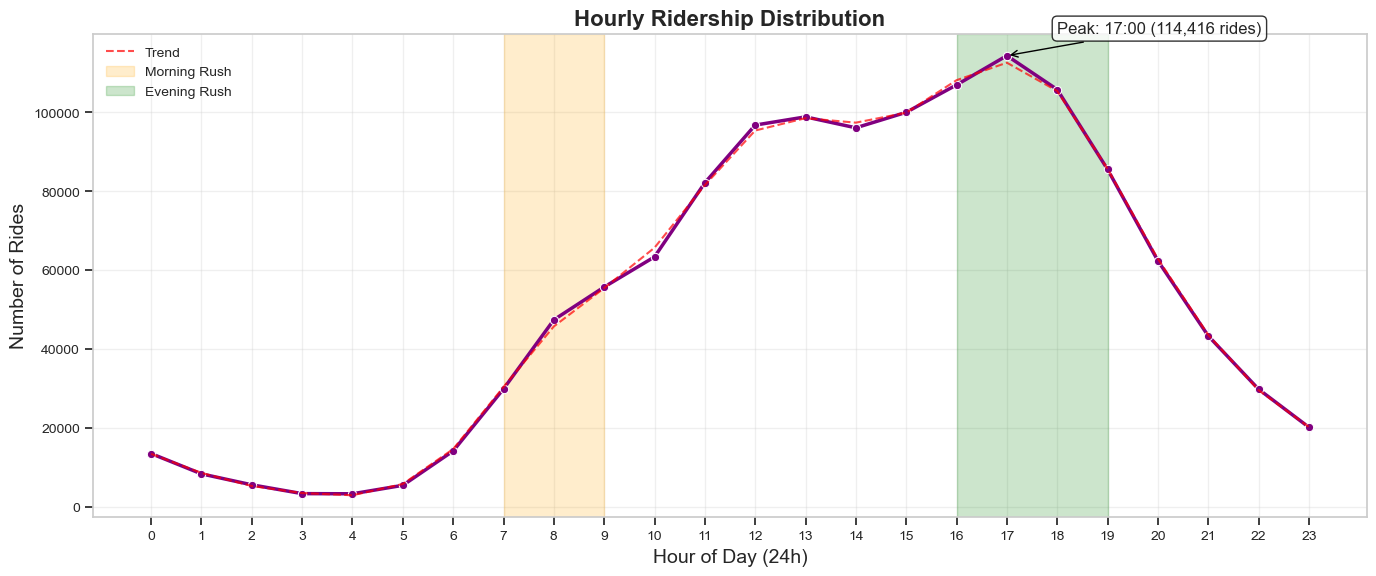

In [97]:
analyze_hourly_patterns(df_merged, time_col='start_time', title='Hourly Ridership Distribution')

## 4. Geospatial Analysis Improvements

In [98]:
def create_bike_share_map(df, station_metrics, top_routes=None, map_title="Metro Bike Share Network"):
    """Create enhanced interactive map with Plotly"""
    # Calculate boundaries
    min_lon = df['start_lon'].min()
    max_lon = df['start_lon'].max()
    min_lat = df['start_lat'].min()
    max_lat = df['start_lat'].max()
    
    # Add padding (5%)
    lon_padding = (max_lon - min_lon) * 0.05
    lat_padding = (max_lat - min_lat) * 0.05
    
    # Create station hover text
    station_metrics['hover_text'] = station_metrics.apply(
        lambda row: f"<b>{row['station_name']}</b><br>" + 
                    f"Trips: {row['trips']:,}<br>" +
                    f"Capacity: {row['total_docks']} docks<br>" +
                    f"Utilization: {row['trips']/row['total_docks']:.1f} trips/dock",
        axis=1
    )
    
    # Create figure
    fig = go.Figure()
    
    # Add station markers
    fig.add_trace(go.Scattermapbox(
        lat=station_metrics['lat'],
        lon=station_metrics['lon'],
        text=station_metrics['hover_text'],
        customdata=station_metrics[['station_name', 'trips']],
        mode='markers',
        marker=dict(
            size=np.sqrt(station_metrics['trips']) / 3 + 5,  # Square root for better visibility
            color=station_metrics['trips'],
            colorscale='Viridis',
            colorbar=dict(title='Trips'),
            opacity=0.8
        ),
        name='Stations',
        hovertemplate="%{text}<extra></extra>"
    ))
    
    # Add top routes if provided
    if top_routes is not None and len(top_routes) > 0:
        for _, route in top_routes.iterrows():
            # Get start and end coordinates
            start_station = station_metrics[station_metrics['start_station'] == route['start_station']]
            end_station = station_metrics[station_metrics['start_station'] == route['end_station']]
            
            if not start_station.empty and not end_station.empty:
                fig.add_trace(go.Scattermapbox(
                    mode='lines',
                    lon=[start_station.iloc[0]['lon'], end_station.iloc[0]['lon']],
                    lat=[start_station.iloc[0]['lat'], end_station.iloc[0]['lat']],
                    line=dict(
                        width=route['count'] / top_routes['count'].max() * 10 + 1,
                        color='red'
                    ),
                    opacity=0.7,
                    name=f"{start_station.iloc[0]['station_name']} → {end_station.iloc[0]['station_name']} ({route['count']} trips)",
                    hovertemplate="%{name}<extra></extra>"
                ))
    
    # Set map layout
    fig.update_layout(
        title=map_title,
        mapbox=dict(
            style="carto-positron",  # Light map style
            zoom=12,
            center=dict(lat=np.mean(station_metrics['lat']), lon=np.mean(station_metrics['lon']))
        ),
        height=800,
        margin=dict(l=0, r=0, t=50, b=10),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        )
    )
    
    return fig

In [99]:
create_bike_share_map(df_merged, station_metrics, top_routes=None, map_title="Metro Bike Share Network")

KeyError: 'total_docks'

## 5. User Segmentation Analysis

In [100]:
def create_rider_segment_dashboard(df, segment_col='rider_segment'):
    """
    Create comprehensive rider segment comparison dashboard
    
    Args:
        df: DataFrame with trip data
        segment_col: Column name containing rider segment
    """
    # Set up the figure
    fig = plt.figure(figsize=(20, 18))
    
    # 1. Trip Duration Distribution
    ax1 = plt.subplot(3, 2, 1)
    sns.histplot(
        data=df,
        x='duration',
        hue=segment_col,
        multiple='dodge',
        bins=20,
        alpha=0.7,
        kde=True,
        ax=ax1
    )
    
    ax1.set_title('Trip Duration Distribution by Rider Segment', fontsize=14)
    ax1.set_xlabel('Trip Duration (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Trips', fontsize=12)
    ax1.set_xlim(0, df['duration'].quantile(0.95))  # Limit x-axis for better visibility
    
    # 2. Weekly Distribution
    ax2 = plt.subplot(3, 2, 2)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Prepare data for plotting
    weekly_trips = df.groupby(['weekday', segment_col]).size().reset_index(name='trips')
    pivot_df = pd.pivot_table(
        weekly_trips, 
        values='trips',
        index='weekday',
        columns=segment_col,
        aggfunc='sum'
    ).reindex(weekday_order)
    
    # Normalize to percentages
    normalized_pivot = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100
    
    # Plot
    normalized_pivot.plot(kind='bar', ax=ax2)
    ax2.set_title('Weekly Trip Distribution by Rider Segment', fontsize=14)
    ax2.set_xlabel('Day of Week', fontsize=12)
    ax2.set_ylabel('Percentage of Trips', fontsize=12)
    ax2.legend(title='Rider Segment')
    
    # Add percentage labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', fontsize=8)
    
    # 3. Trip Distance Comparison
    ax3 = plt.subplot(3, 2, 3)
    
    # Calculate statistics
    distance_stats = df.groupby(segment_col)['trip_distance_km'].agg(['mean', 'median', 'std']).reset_index()
    
    # Create error bar plot
    sns.barplot(
        data=distance_stats,
        x=segment_col,
        y='mean',
        ax=ax3
    )
    
    # Add error bars
    for i, row in distance_stats.iterrows():
        ax3.errorbar(
            i, row['mean'], yerr=row['std']/2,
            fmt='none', color='black', capsize=5
        )
    
    ax3.set_title('Average Trip Distance by Rider Segment', fontsize=14)
    ax3.set_xlabel('Rider Segment', fontsize=12)
    ax3.set_ylabel('Average Distance (km)', fontsize=12)
    
    # Add value labels
    for i, v in enumerate(distance_stats['mean']):
        ax3.text(i, v + 0.1, f"{v:.2f} km", ha='center', fontsize=10)
    
    # 4. Hourly Pattern Comparison
    ax4 = plt.subplot(3, 2, 4)
    
    # Calculate hourly percentages by segment
    hourly_data = df.groupby([df['start_time'].dt.hour, segment_col]).size().reset_index(name='trips')
    hourly_data = hourly_data.pivot(index='start_time', columns=segment_col, values='trips')
    hourly_pct = hourly_data.div(hourly_data.sum(axis=0), axis=1) * 100
    
    # Plot
    hourly_pct.plot(
        kind='line',
        marker='o',
        ax=ax4
    )
    
    ax4.set_title('Hourly Trip Distribution by Rider Segment', fontsize=14)
    ax4.set_xlabel('Hour of Day', fontsize=12)
    ax4.set_ylabel('Percentage of Trips', fontsize=12)
    ax4.set_xticks(range(0, 24))
    ax4.legend(title='Rider Segment')
    ax4.grid(True, alpha=0.3)
    
    # 5. Bike Type Preference
    ax5 = plt.subplot(3, 2, 5)
    
    # Calculate bike type preferences
    bike_pref = df.groupby(['bike_type', segment_col]).size().reset_index(name='trips')
    bike_pivot = pd.pivot_table(
        bike_pref,
        values='trips',
        index='bike_type',
        columns=segment_col,
        aggfunc='sum'
    )
    
    # Normalize to percentages
    bike_pct = bike_pivot.div(bike_pivot.sum(axis=0), axis=1) * 100
    
    # Plot
    bike_pct.plot(kind='bar', ax=ax5)
    ax5.set_title('Bike Type Preference by Rider Segment', fontsize=14)
    ax5.set_xlabel('Bike Type', fontsize=12)
    ax5.set_ylabel('Percentage of Trips', fontsize=12)
    ax5.legend(title='Rider Segment')
    
    # Add percentage labels
    for container in ax5.containers:
        ax5.bar_label(container, fmt='%.1f%%', fontsize=8)
    
    # 6. Proportion of Short Trips (under 30 min)
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate proportion of trips under 30 minutes by hour and segment
    df['under_30'] = df['duration'] <= 30
    under30_data = df.groupby(['trip_hour', segment_col])['under_30'].mean().reset_index(name='pct_under_30')
    under30_pivot = under30_data.pivot(index='trip_hour', columns=segment_col, values='pct_under_30')
    
    # Plot
    under30_pivot.plot(
        kind='line',
        marker='o',
        ax=ax6
    )
    
    ax6.set_title('Proportion of Trips ≤30 Minutes by Hour and Rider Segment', fontsize=14)
    ax6.set_xlabel('Hour of Day', fontsize=12)
    ax6.set_ylabel('Proportion of Trips ≤30 min', fontsize=12)
    ax6.set_xticks(range(0, 24))
    ax6.set_ylim(0, 1)
    ax6.legend(title='Rider Segment')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Rider Segment Analysis', fontsize=20, y=1.02)
    
    # Calculate and display key statistics
    subscriber_pct = (df[segment_col] == 'Subscribers').mean() * 100
    casual_pct = 100 - subscriber_pct
    
    subscriber_duration = df[df[segment_col] == 'Subscribers']['duration'].mean()
    casual_duration = df[df[segment_col] == 'Casual Riders']['duration'].mean()
    
    print(f"Rider Composition: {subscriber_pct:.1f}% Subscribers, {casual_pct:.1f}% Casual Riders")
    print(f"Average Trip Duration: Subscribers {subscriber_duration:.1f} min, Casual Riders {casual_duration:.1f} min")
    
    return fig

ValueError: Could not interpret value `rider_segment` for `hue`. An entry with this name does not appear in `data`.

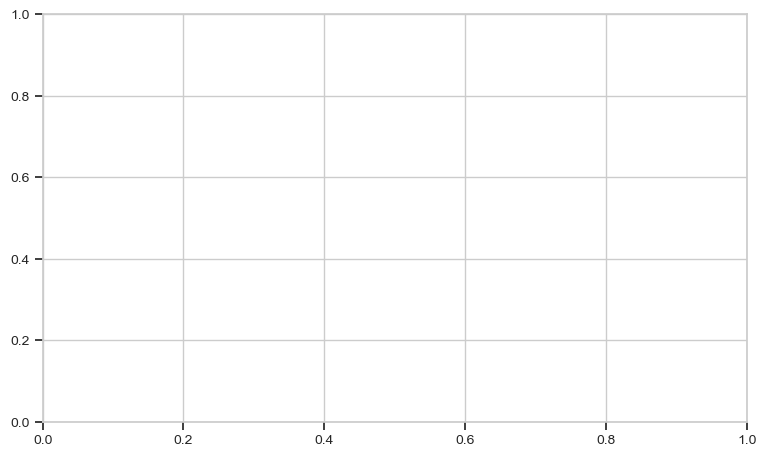

In [101]:
create_rider_segment_dashboard(df_merged, segment_col='rider_segment')

## 6. Revenue Analysis Improvements

In [103]:
def analyze_pricing_efficiency(df_pricing, plan_column='plan'):
    """
    Create comprehensive pricing and revenue analysis
    
    Args:
        df_pricing: DataFrame with pricing data
        plan_column: Column containing the pricing plan
    """
    # Set up subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Total Revenue by Plan
    ax1 = plt.subplot(3, 2, 1)
    
    # Calculate metrics
    plan_revenue = df_pricing.groupby(plan_column)['trip_cost'].sum().reset_index(name='total_revenue')
    plan_rides = df_pricing.groupby(plan_column)['trip_id'].count().reset_index(name='ride_count')
    plan_perf = plan_revenue.merge(plan_rides, on=plan_column)
    plan_perf['avg_rev_per_ride'] = plan_perf['total_revenue'] / plan_perf['ride_count']
    plan_perf['revenue_pct'] = plan_perf['total_revenue'] / plan_perf['total_revenue'].sum() * 100
    
    # Plot
    sns.barplot(
        data=plan_perf,
        x=plan_column,
        y='total_revenue',
        palette='Blues_d',
        ax=ax1
    )
    
    # Add revenue percentage labels
    for i, p in enumerate(ax1.patches):
        ax1.annotate(
            f"${p.get_height():.2f}\n({plan_perf.iloc[i]['revenue_pct']:.1f}%)",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax1.set_title('Total Revenue by Pricing Plan', fontsize=14)
    ax1.set_xlabel('Pricing Plan', fontsize=12)
    ax1.set_ylabel('Total Revenue ($)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Average Revenue per Ride
    ax2 = plt.subplot(3, 2, 2)
    
    sns.barplot(
        data=plan_perf,
        x=plan_column,
        y='avg_rev_per_ride',
        palette='Greens_d',
        ax=ax2
    )
    
    # Add average revenue labels
    for i, p in enumerate(ax2.patches):
        ax2.annotate(
            f"${p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax2.set_title('Average Revenue per Ride by Plan', fontsize=14)
    ax2.set_xlabel('Pricing Plan', fontsize=12)
    ax2.set_ylabel('Average Revenue per Ride ($)', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Overage Analysis
    ax3 = plt.subplot(3, 2, 3)
    
    # Calculate overage statistics
    overage_stats = df_pricing[df_pricing['overage_flag']].groupby(plan_column).agg(
        overage_rides=('trip_id', 'count'),
        overage_revenue=('trip_cost', 'sum'),
        avg_overage=('trip_cost', 'mean')
    ).reset_index()
    
    # Calculate percentage of rides with overage
    total_rides_by_plan = df_pricing.groupby(plan_column)['trip_id'].count().reset_index(name='total_rides')
    overage_stats = overage_stats.merge(total_rides_by_plan, on=plan_column)
    overage_stats['pct_rides_with_overage'] = (overage_stats['overage_rides'] / overage_stats['total_rides'] * 100).round(1)
    
    # Plot percentage of rides with overage
    sns.barplot(
        data=overage_stats,
        x=plan_column,
        y='pct_rides_with_overage',
        palette='Reds_d',
        ax=ax3
    )
    
    # Add percentage labels
    for i, p in enumerate(ax3.patches):
        ax3.annotate(
            f"{p.get_height():.1f}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax3.set_title('Percentage of Rides with Overage Charges by Plan', fontsize=14)
    ax3.set_xlabel('Pricing Plan', fontsize=12)
    ax3.set_ylabel('Percentage of Rides with Overage', fontsize=12)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Revenue by Trip Duration
    ax4 = plt.subplot(3, 2, 4)
    
    # Analyze revenue by duration bin
    trip_duration_bins = df_pricing.groupby('duration_bin').agg(
        ride_count=('trip_id', 'count'),
        avg_trip_cost=('trip_cost', 'mean'),
        total_revenue=('trip_cost', 'sum'),
        overage_pct=('overage_flag', lambda x: x.mean() * 100)
    ).reset_index()
    
    # Calculate percentages
    trip_duration_bins['pct_rides'] = (trip_duration_bins['ride_count'] / trip_duration_bins['ride_count'].sum() * 100).round(1)
    trip_duration_bins['pct_revenue'] = (trip_duration_bins['total_revenue'] / trip_duration_bins['total_revenue'].sum() * 100).round(1)
    
    # Create dual axis plot
    sns.barplot(
        data=trip_duration_bins, 
        x='duration_bin', 
        y='ride_count', 
        color='steelblue',
        alpha=0.7,
        ax=ax4
    )
    
    # Add ride count percentages
    for i, p in enumerate(ax4.patches):
        ax4.annotate(
            f"{trip_duration_bins.iloc[i]['pct_rides']}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            color='steelblue',
            fontsize=9
        )
    
    # Create a second y-axis for revenue
    ax4b = ax4.twinx()
    sns.lineplot(
        data=trip_duration_bins, 
        x='duration_bin', 
        y='avg_trip_cost', 
        marker='o', 
        color='darkorange',
        linewidth=2,
        ax=ax4b
    )
    
    # Add average revenue labels
    for i, row in trip_duration_bins.iterrows():
        ax4b.annotate(
            f"${row['avg_trip_cost']:.2f}",
            (i, row['avg_trip_cost']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            va='bottom',
            color='darkorange',
            fontsize=9
        )
    
    # Add vertical line at 30 minute mark
    threshold_index = trip_duration_bins[trip_duration_bins['duration_bin'] == '15-30'].index
    if len(threshold_index) > 0:
        ax4.axvline(x=threshold_index[0] + 0.5, color='red', linestyle='--', alpha=0.7, label='30-min threshold')
    
    ax4.set_title('Ride Count and Average Revenue by Trip Duration', fontsize=14)
    ax4.set_xlabel('Trip Duration (minutes)', fontsize=12)
    ax4.set_ylabel('Number of Rides', fontsize=12, color='steelblue')
    ax4b.set_ylabel('Average Revenue per Trip ($)', fontsize=12, color='darkorange')
    ax4.tick_params(axis='y', colors='steelblue')
    ax4b.tick_params(axis='y', colors='darkorange')
    
    # 5. Price Elasticity (CDF)
    ax5 = plt.subplot(3, 2, 5)
    
    # CDF of trip durations by plan
    bins = np.arange(0, 91, 5)
    cdf_data = []
    
    for plan, grp in df_pricing.groupby(plan_column):
        counts, bin_edges = np.histogram(grp['duration'], bins=bins)
        cdf = np.cumsum(counts) / counts.sum()
        cdf_data.append(pd.DataFrame({'duration_bin': bins[:-1], 'cdf': cdf, 'plan': plan}))
    
    cdf_df = pd.concat(cdf_data)
    
    # Plot
    sns.lineplot(
        data=cdf_df,
        x='duration_bin',
        y='cdf',
        hue='plan',
        palette='tab10',
        linewidth=2,
        ax=ax5
    )
    
    # Add threshold line
    ax5.axvline(30, color='black', linestyle='--', label='30 Min Threshold')
    
    ax5.set_title('Trip Duration Cumulative Distribution by Plan', fontsize=14)
    ax5.set_xlabel('Trip Duration (min)', fontsize=12)
    ax5.set_ylabel('Cumulative Proportion of Rides', fontsize=12)
    ax5.legend(title='Pricing Plan')
    ax5.grid(True, alpha=0.3)
    
    # 6. Pricing Efficiency
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate pricing efficiency metrics
    plan_efficiency = df_pricing.groupby(plan_column).agg(
        total_trips=('trip_id', 'count'),
        trips_with_overage=('overage_flag', 'sum'),
        avg_trip_cost=('trip_cost', 'mean'),
        revenue_per_minute=('trip_cost', lambda x: x.sum() / df_pricing.loc[x.index, 'duration'].sum())
    ).reset_index()
    
    # Calculate overage percentage
    plan_efficiency['overage_pct'] = plan_efficiency['trips_with_overage'] / plan_efficiency['total_trips'] * 100
    
    # Create the primary bar chart for revenue per minute
    sns.barplot(
        data=plan_efficiency, 
        x=plan_column, 
        y='revenue_per_minute', 
        palette='Blues_d',
        ax=ax6
    )
    
    # Add text labels to the bars
    for i, p in enumerate(ax6.patches):
        ax6.annotate(
            f'${p.get_height():.3f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='bottom',
            fontsize=10,
            color='black'
        )
    
    # Create a second y-axis for overage percentage
    ax6b = ax6.twinx()
    sns.pointplot(
        data=plan_efficiency, 
        x=plan_column, 
        y='overage_pct', 
        color='red',
        scale=1.5,
        ax=ax6b
    )
    
    # Add overage percentage labels
    for i, v in enumerate(plan_efficiency['overage_pct']):
        ax6b.annotate(
            f"{v:.1f}%",
            (i, v),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            va='bottom',
            color='red',
            fontsize=10
        )
    
    ax6.set_title('Pricing Efficiency by Plan', fontsize=14)
    ax6.set_xlabel('Pricing Plan', fontsize=12)
    ax6.set_ylabel('Revenue per Minute ($)', fontsize=12)
    ax6b.set_ylabel('Trips with Overage (%)', fontsize=12, color='red')
    ax6.tick_params(axis='y')
    ax6b.tick_params(axis='y', colors='red')
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Pricing and Revenue Analysis', fontsize=20, y=1.02)
    
    # Calculate and display key summary statistics
    total_revenue = df_pricing['trip_cost'].sum()
    overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
    overage_pct = (overage_revenue / total_revenue) * 100
    
    most_profitable_plan = plan_perf.loc[plan_perf['total_revenue'].idxmax(), plan_column]
    most_profitable_pct = plan_perf.loc[plan_perf['total_revenue'].idxmax(), 'revenue_pct']
    
    print(f"Total Revenue: ${total_revenue:.2f}")
    print(f"Overage Revenue: ${overage_revenue:.2f} ({overage_pct:.1f}% of total)")
    print(f"Most Profitable Plan: {most_profitable_plan} ({most_profitable_pct:.1f}% of total revenue)")
    
    return fig, plan_perf, overage_stats, trip_duration_bins, plan_efficiency

In [104]:
analyze_pricing_efficiency(df_pricing, plan_column='plan')

NameError: name 'df_pricing' is not defined

## 7. Predictive Modeling Improvements

In [105]:
def build_demand_prediction_model(hourly_demand, top_stations, test_size=0.2, random_state=42):
    """
    Build and evaluate a bike demand prediction model with enhanced features
    
    Args:
        hourly_demand: DataFrame with hourly demand data
        top_stations: List of top station IDs to include
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (model, evaluation_metrics, feature_importances, plots)
    """
    import time
    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    
    print("Preparing data for predictive modeling...")
    
    # Filter to selected stations
    station_demand = hourly_demand[hourly_demand['start_station'].isin(top_stations)]
    
    # Create additional features
    station_demand['is_weekend'] = station_demand['day_of_week'].isin([5, 6]).astype(int)
    station_demand['is_rush_hour'] = station_demand['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
    station_demand['is_business_hours'] = station_demand['hour'].between(9, 17).astype(int)
    station_demand['is_night'] = station_demand['hour'].isin(range(22, 24)).astype(int)
    station_demand['hour_sin'] = np.sin(2 * np.pi * station_demand['hour']/24)
    station_demand['hour_cos'] = np.cos(2 * np.pi * station_demand['hour']/24)
    station_demand['day_sin'] = np.sin(2 * np.pi * station_demand['day_of_week']/7)
    station_demand['day_cos'] = np.cos(2 * np.pi * station_demand['day_of_week']/7)
    
    # Define features and target
    numeric_features = [
        'hour', 'day_of_week', 'month', 
        'is_weekend', 'is_rush_hour', 'is_business_hours', 'is_night',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    categorical_features = ['start_station']
    
    X = station_demand[numeric_features + categorical_features]
    y = station_demand['demand']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )
    
    # Define models to test
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=random_state),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state)
    }
    
    results = {}
    best_model = None
    best_score = -np.inf
    
    # Train and evaluate models
    print("\nTraining and evaluating models:")
    for name, model in models.items():
        start_time = time.time()
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        
        # Store results
        results[name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'cv_mean': cv_mean,
            'pipeline': pipeline,
            'y_pred': y_pred
        }
        
        # Update best model
        if cv_mean > best_score:
            best_model = name
            best_score = cv_mean
        
        duration = time.time() - start_time
        print(f"  {name}: R² = {r2:.4f}, CV R² = {cv_mean:.4f}, RMSE = {rmse:.2f}, Time = {duration:.2f}s")
    
    print(f"\nBest model: {best_model} (CV R² = {best_score:.4f})")
    
    # Further tune the best model
    best_pipeline = results[best_model]['pipeline']
    
    # Extract feature importances if available
    if best_model in ['Random Forest', 'Gradient Boosting']:
        model = best_pipeline.named_steps['model']
        feature_names = (
            numeric_features + 
            preprocessor.named_transformers_['cat'].get_feature_names_out([categorical_features[0]]).tolist()
        )
        
        feature_importances = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        # For linear models, use coefficients as feature importance
        if best_model == 'Linear Regression':
            model = best_pipeline.named_steps['model']
            feature_names = (
                numeric_features + 
                preprocessor.named_transformers_['cat'].get_feature_names_out([categorical_features[0]]).tolist()
            )
            
            feature_importances = pd.DataFrame({
                'feature': feature_names,
                'importance': np.abs(model.coef_)
            }).sort_values('importance', ascending=False)
        else:
            feature_importances = pd.DataFrame()
    
    # Create evaluation visualizations
    plots = {}
    
    # 1. Actual vs Predicted Plot
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    ax1.scatter(y_test, results[best_model]['y_pred'], alpha=0.5)
    ax1.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    ax1.set_title('Actual vs Predicted Demand', fontsize=14)
    ax1.set_xlabel('Actual Demand', fontsize=12)
    ax1.set_ylabel('Predicted Demand', fontsize=12)
    ax1.grid(True, alpha=0.3)
    plots['actual_vs_predicted'] = fig1
    
    # 2. Error Distribution
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    errors = y_test - results[best_model]['y_pred']
    sns.histplot(errors, bins=50, kde=True, ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_title('Prediction Error Distribution', fontsize=14)
    ax2.set_xlabel('Prediction Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    plots['error_distribution'] = fig2
    
    # 3. Feature Importance
    if not feature_importances.empty:
        fig3, ax3 = plt.subplots(figsize=(12, 8))
        sns.barplot(
            data=feature_importances.head(15),
            x='importance',
            y='feature',
            palette='viridis',
            ax=ax3
        )
        ax3.set_title('Top 15 Features for Predicting Bike Demand', fontsize=14)
        ax3.set_xlabel('Importance', fontsize=12)
        ax3.set_ylabel('Feature', fontsize=12)
        plots['feature_importance'] = fig3
    
    # 4. Hourly Analysis
    # Get test results by hour
    test_results = pd.DataFrame({
        'actual': y_test,
        'predicted': results[best_model]['y_pred']
    })
    
    # Add hour information from original data
    test_results = test_results.reset_index()
    test_hours = X_test.reset_index()['hour']
    test_results['hour'] = test_hours
    
    # Group by hour
    hourly_results = test_results.groupby('hour').agg(
        actual_mean=('actual', 'mean'),
        predicted_mean=('predicted', 'mean'),
        mae=('actual', lambda x, y=test_results['predicted']: mean_absolute_error(
            x, y.loc[x.index]
        ))
    ).reset_index()
    
    fig4, ax4 = plt.subplots(figsize=(12, 6))
    ax4.plot(hourly_results['hour'], hourly_results['actual_mean'], 'o-', label='Actual')
    ax4.plot(hourly_results['hour'], hourly_results['predicted_mean'], 'o-', label='Predicted')
    ax4.set_title('Hourly Demand Patterns: Actual vs Predicted', fontsize=14)
    ax4.set_xlabel('Hour of Day', fontsize=12)
    ax4.set_ylabel('Average Demand', fontsize=12)
    ax4.set_xticks(range(24))
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plots['hourly_comparison'] = fig4
    
    # Combine all evaluation metrics
    evaluation = {
        'best_model': best_model,
        'metrics': {
            'mse': results[best_model]['mse'],
            'rmse': results[best_model]['rmse'],
            'mae': results[best_model]['mae'],
            'r2': results[best_model]['r2'],
            'cv_mean': results[best_model]['cv_mean']
        },
        'pipeline': best_pipeline,
        'feature_importances': feature_importances,
        'plots': plots,
        'hourly_results': hourly_results
    }
    
    print("\nModel training and evaluation complete!")
    
    return evaluation

In [106]:
build_demand_prediction_model(hourly_demand, top_stations, test_size=0.2, random_state=42)

NameError: name 'hourly_demand' is not defined

## 8. Creating Interactive Dashboards

In [107]:
def create_bike_share_dashboard(df_merged, station_metrics, top_routes):
    """
    Create an interactive dashboard for bike share network analysis
    
    Args:
        df_merged: Combined trip and station DataFrame
        station_metrics: DataFrame with station metrics
        top_routes: DataFrame with top routes
    
    Returns:
        A Plotly figure object representing the dashboard
    """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.express as px
    
    # Create a dashboard with multiple panels
    dashboard = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "mapbox"}, {"type": "bar"}],
            [{"type": "heatmap"}, {"type": "scatter"}]
        ],
        column_widths=[0.6, 0.4],
        row_heights=[0.6, 0.4],
        subplot_titles=[
            "Network Map", 
            "Top 10 Stations by Usage", 
            "Hourly Activity by Day of Week",
            "Monthly Trend"
        ]
    )
    
    # Panel 1: Network Map
    # Calculate boundaries
    min_lon = df_merged['start_lon'].min()
    max_lon = df_merged['start_lon'].max()
    min_lat = df_merged['start_lat'].min()
    max_lat = df_merged['start_lat'].max()
    
    # Add station markers
    dashboard.add_trace(
        go.Scattermapbox(
            lat=station_metrics['lat'],
            lon=station_metrics['lon'],
            text=station_metrics['station_name'] + '<br>Trips: ' + station_metrics['trips'].astype(str),
            mode='markers',
            marker=dict(
                size=np.sqrt(station_metrics['trips']) / 3 + 5,  # Square root for better visibility
                color=station_metrics['trips'],
                colorscale='Viridis',
                colorbar=dict(
                    title='Trips',
                    x=0.46,
                    y=0.8,
                    len=0.4
                ),
                opacity=0.8
            ),
            name='Stations',
            hovertemplate="%{text}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # Add top routes
    for _, route in top_routes.iterrows():
        # Get start and end coordinates
        start_station = station_metrics[station_metrics['start_station'] == route['start_station']]
        end_station = station_metrics[station_metrics['start_station'] == route['end_station']]
        
        if not start_station.empty and not end_station.empty:
            dashboard.add_trace(
                go.Scattermapbox(
                    mode='lines',
                    lon=[start_station.iloc[0]['lon'], end_station.iloc[0]['lon']],
                    lat=[start_station.iloc[0]['lat'], end_station.iloc[0]['lat']],
                    line=dict(
                        width=route['count'] / top_routes['count'].max() * 5 + 1,
                        color='red'
                    ),
                    opacity=0.7,
                    name=f"Route: {route['count']} trips",
                    hovertemplate="%{name}<extra></extra>",
                    showlegend=False
                ),
                row=1, col=1
            )
    
    # Panel 2: Top 10 Stations by Usage
    top_stations = station_metrics.nlargest(10, 'trips')
    dashboard.add_trace(
        go.Bar(
            x=top_stations['trips'],
            y=top_stations['station_name'],
            orientation='h',
            marker=dict(color=top_stations['trips'], colorscale='Viridis'),
            text=top_stations['trips'].astype(str),
            textposition='auto',
            hovertemplate="Station: %{y}<br>Trips: %{x}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # Panel 3: Hourly Activity by Day of Week
    # Create a crosstab of hour vs. day
    hourly_daily = pd.crosstab(
        index=df_merged['trip_hour'],
        columns=df_merged['weekday'],
        values=df_merged['trip_id'],
        aggfunc='count'
    )
    
    # Reorder columns to standard weekday order
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hourly_daily = hourly_daily.reindex(columns=weekday_order)
    
    # Convert to matrix format for heatmap
    z_data = hourly_daily.values
    
    dashboard.add_trace(
        go.Heatmap(
            z=z_data,
            x=weekday_order,
            y=list(range(24)),
            colorscale='Viridis',
            hovertemplate="Day: %{x}<br>Hour: %{y}<br>Trips: %{z}<extra></extra>"
        ),
        row=2, col=1
    )
    
    # Panel 4: Monthly Trend
    # Count rides by month and year
    monthly_rides = df_merged.groupby(['year', 'month']).size().reset_index(name='rides')
    monthly_rides['date'] = pd.to_datetime(monthly_rides[['year', 'month']].assign(day=1))
    
    dashboard.add_trace(
        go.Scatter(
            x=monthly_rides['date'],
            y=monthly_rides['rides'],
            mode='lines+markers',
            line=dict(width=2),
            marker=dict(size=8),
            hovertemplate="Date: %{x|%b %Y}<br>Trips: %{y}<extra></extra>"
        ),
        row=2, col=2
    )
    
    # Update mapbox settings
    dashboard.update_mapboxes(
        style="carto-positron",
        zoom=12,
        center=dict(lat=np.mean([min_lat, max_lat]), lon=np.mean([min_lon, max_lon]))
    )
    
    # Update layout
    dashboard.update_layout(
        title="Metro Bike Share Network Dashboard",
        mapbox_style="carto-positron",
        height=900,
        width=1200,
        showlegend=False,
        margin=dict(l=20, r=20, t=60, b=20),
        template="plotly_white"
    )
    
    # Update axes
    dashboard.update_xaxes(title_text="Number of Trips", row=1, col=2)
    dashboard.update_yaxes(title_text="Station", row=1, col=2)
    dashboard.update_xaxes(title_text="Day of Week", row=2, col=1)
    dashboard.update_yaxes(title_text="Hour of Day", row=2, col=1)
    dashboard.update_xaxes(title_text="Month", row=2, col=2)
    dashboard.update_yaxes(title_text="Number of Trips", row=2, col=2)
    
    return dashboard

In [108]:
create_bike_share_dashboard(df_merged, station_metrics, top_routes)

KeyError: 'weekday'

### Revenue Dashboard

In [109]:
def create_revenue_dashboard(df_pricing):
    """
    Create an interactive dashboard for revenue analysis
    
    Args:
        df_pricing: DataFrame with pricing data
        
    Returns:
        A Plotly figure object representing the dashboard
    """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.express as px
    
    # Create a dashboard with multiple panels
    dashboard = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "bar"}, {"type": "pie"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        subplot_titles=[
            "Revenue by Plan", 
            "Overage vs Base Revenue", 
            "Revenue by Trip Duration",
            "Trip Duration Distribution by Plan"
        ]
    )
    
    # Panel 1: Revenue by Plan
    plan_revenue = df_pricing.groupby('plan')['trip_cost'].sum().reset_index(name='total_revenue')
    total = plan_revenue['total_revenue'].sum()
    plan_revenue['percentage'] = (plan_revenue['total_revenue'] / total * 100).round(1)
    
    dashboard.add_trace(
        go.Bar(
            x=plan_revenue['plan'],
            y=plan_revenue['total_revenue'],
            marker=dict(color=plan_revenue['total_revenue'], colorscale='Blues'),
            text=[f"${x:.2f} ({y}%)" for x, y in zip(plan_revenue['total_revenue'], plan_revenue['percentage'])],
            textposition='auto',
            hovertemplate="Plan: %{x}<br>Revenue: $%{y:.2f}<br>%{text}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # Panel 2: Overage vs Base Revenue
    overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
    base_revenue = total - overage_revenue
    
    dashboard.add_trace(
        go.Pie(
            labels=['Base Revenue', 'Overage Charges'],
            values=[base_revenue, overage_revenue],
            marker=dict(colors=['#3498db', '#e74c3c']),
            textinfo='label+percent',
            hoverinfo='label+value+percent',
            texttemplate="%{label}<br>%{percent}",
            hovertemplate="%{label}<br>$%{value:.2f}<br>%{percent}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # Panel 3: Revenue by Trip Duration
    duration_revenue = df_pricing.groupby('duration_bin').agg(
        total_revenue=('trip_cost', 'sum'),
        ride_count=('trip_id', 'count')
    ).reset_index()
    
    duration_revenue['avg_revenue'] = duration_revenue['total_revenue'] / duration_revenue['ride_count']
    duration_revenue['percentage'] = (duration_revenue['total_revenue'] / duration_revenue['total_revenue'].sum() * 100).round(1)
    
    dashboard.add_trace(
        go.Bar(
            x=duration_revenue['duration_bin'],
            y=duration_revenue['total_revenue'],
            marker=dict(color=duration_revenue['total_revenue'], colorscale='Greens'),
            text=[f"${x:.2f} ({y}%)" for x, y in zip(duration_revenue['total_revenue'], duration_revenue['percentage'])],
            textposition='auto',
            name='Total Revenue',
            hovertemplate="Duration: %{x}<br>Revenue: $%{y:.2f}<br>%{text}<extra></extra>"
        ),
        row=2, col=1
    )
    
    # Panel 4: Trip Duration Distribution by Plan
    # CDF of trip durations by plan
    bins = np.arange(0, 91, 5)
    cdf_data = []
    
    for plan, grp in df_pricing.groupby('plan'):
        counts, bin_edges = np.histogram(grp['duration'], bins=bins)
        cdf = np.cumsum(counts) / counts.sum()
        
        dashboard.add_trace(
            go.Scatter(
                x=bins[:-1],
                y=cdf,
                mode='lines',
                name=plan,
                hovertemplate="Plan: %{name}<br>Duration: %{x} min<br>Cumulative %: %{y:.1%}<extra></extra>"
            ),
            row=2, col=2
        )
    
    # Add threshold line
    dashboard.add_shape(
        type="line",
        x0=30, y0=0,
        x1=30, y1=1,
        line=dict(color="red", width=2, dash="dash"),
        row=2, col=2
    )
    
    dashboard.add_annotation(
        x=30, y=0.5,
        text="30 min threshold",
        showarrow=True,
        arrowhead=1,
        row=2, col=2
    )
    
    # Update layout
    dashboard.update_layout(
        title="Metro Bike Share Revenue Dashboard",
        height=800,
        width=1200,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white"
    )
    
    # Update axes
    dashboard.update_xaxes(title_text="Pricing Plan", row=1, col=1)
    dashboard.update_yaxes(title_text="Total Revenue ($)", row=1, col=1)
    
    dashboard.update_xaxes(title_text="Trip Duration", row=2, col=1)
    dashboard.update_yaxes(title_text="Total Revenue ($)", row=2, col=1)
    
    dashboard.update_xaxes(title_text="Trip Duration (minutes)", row=2, col=2)
    dashboard.update_yaxes(title_text="Cumulative Proportion", row=2, col=2)
    
    return dashboard

In [110]:
create_revenue_dashboard(df_pricing)

NameError: name 'df_pricing' is not defined

In [111]:
## 10. Advanced Analysis Extensions
### Time Series Decomposition
def perform_time_series_analysis(df, date_col='start_time', value_col='trip_id', freq='D'):
    """
    Perform time series decomposition analysis
    
    Args:
        df: DataFrame with time series data
        date_col: Column containing datetime values
        value_col: Column to analyze
        freq: Frequency for resampling ('D' for daily, 'M' for monthly, etc.)
        
    Returns:
        Decomposition results
    """
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # Prepare time series data
    df_ts = df.copy()
    df_ts[date_col] = pd.to_datetime(df_ts[date_col])
    
    # Aggregate by date
    time_series = df_ts.set_index(date_col).resample(freq).agg({value_col: 'count'})
    time_series = time_series.fillna(time_series.mean())
    
    # Perform decomposition
    decomposition = seasonal_decompose(time_series, model='multiplicative')
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed', fontsize=14)
    ax1.set_ylabel('Count', fontsize=12)
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend', fontsize=14)
    ax2.set_ylabel('Trend', fontsize=12)
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality', fontsize=14)
    ax3.set_ylabel('Seasonal Factor', fontsize=12)
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residuals', fontsize=14)
    ax4.set_ylabel('Residual', fontsize=12)
    
    plt.tight_layout()
    
    return decomposition, time_series

In [112]:
perform_time_series_analysis(df_merged, date_col='start_time', value_col='trip_id', freq='D')

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [113]:
### Cluster Analysis for Station Grouping
def cluster_stations(station_metrics, n_clusters=5):
    """
    Perform cluster analysis to identify station groups
    
    Args:
        station_metrics: DataFrame with station metrics
        n_clusters: Number of clusters to create
        
    Returns:
        DataFrame with cluster assignments
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    
    # Select features for clustering
    features = ['trips', 'total_docks', 'lat', 'lon', 'utilization_rate']
    
    # Create a copy and drop any rows with missing values
    station_data = station_metrics[features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(station_data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Add cluster assignments to original data
    clustered_stations = station_metrics.copy()
    clustered_stations.loc[station_data.index, 'cluster'] = clusters
    
    # Calculate cluster statistics
    cluster_stats = clustered_stations.groupby('cluster').agg({
        'trips': ['mean', 'sum', 'count'],
        'total_docks': ['mean', 'sum'],
        'utilization_rate': ['mean', 'median', 'min', 'max']
    })
    
    # Visualize clusters on map
    plt.figure(figsize=(14, 10))
    
    # Create a scatter plot with cluster colors
    scatter = plt.scatter(
        clustered_stations['lon'],
        clustered_stations['lat'],
        c=clustered_stations['cluster'],
        cmap='tab10',
        s=clustered_stations['trips'] / clustered_stations['trips'].max() * 200 + 50,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(),
                        title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title('Station Clusters', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    return clustered_stations, cluster_stats

In [114]:
cluster_stations(station_metrics, n_clusters=5)

KeyError: "['total_docks', 'utilization_rate'] not in index"

## 9. Final Project Organization

### Main Analysis Script Structure
```python
# Structure your final notebook as follows:

# 1. Introduction and Setup
# --------------------------
# - Project description and objectives
# - Import all necessary libraries
# - Set visualization defaults

# 2. Data Loading and Cleaning
# ----------------------------
# - Connect to DuckDB
# - Load trips and stations data
# - Apply data cleaning functions
# - Create derived features

# 3. Exploratory Data Analysis
# ----------------------------
# - Temporal analysis (hourly, daily, seasonal patterns)
# - Station analysis (usage, capacity, rebalancing needs)
# - Route analysis (popular routes, round trips)
# - User segmentation (subscriber vs. casual behavior)

# 4. Revenue and Pricing Analysis
# ------------------------------
# - Revenue by plan type
# - Overage analysis
# - Duration-based pricing efficiency
# - Price elasticity analysis

# 5. Predictive Modeling
# ----------------------
# - Feature engineering
# - Model training and evaluation
# - Feature importance analysis
# - Demand forecasting

# 6. Interactive Dashboards
# -------------------------
# - Network dashboard
# - Revenue dashboard

# 7. Key Findings and Recommendations
# ----------------------------------
# - Operational insights
# - Revenue optimization strategies
# - User experience improvements
# - Maintenance and fleet management
# - Strategic expansion opportunities

# 8. Conclusion
# ------------
# - Summary of findings
# - Limitations and future work
# - Implementation roadmap
```

### Project Setup Instructions
```python
# Metro Bike Share Analysis Setup
# -------------------------------

# 1. Environment Setup
# Create a dedicated environment for this project

# Using conda:
# conda create -n bike_share python=3.9
# conda activate bike_share
# conda install -c conda-forge pandas numpy matplotlib seaborn plotly scikit-learn duckdb jupyter

# Using venv:
# python -m venv bike_share_env
# source bike_share_env/bin/activate  # On Windows: bike_share_env\Scripts\activate
# pip install pandas numpy matplotlib seaborn plotly scikit-learn duckdb jupyter

# 2. Project Structure
# Create the following directory structure:
#
# bike_share_analysis/
# ├── data/
# │   ├── raw/               # Original data files
# │   ├── interim/           # Intermediate processed data
# │   └── processed/         # Final clean data for analysis
# ├── notebooks/             # Jupyter notebooks
# ├── scripts/               # Python scripts including ETL pipeline
# ├── visualizations/        # Generated figures and interactive dashboards
# └── README.md              # Project documentation

# 3. Data Pipeline Execution
# Run the ETL pipeline to prepare the data:
# python scripts/etl_pipeline.py

# 4. Analysis Notebook
# Open the main analysis notebook:
# jupyter notebook notebooks/metro_bike_share_analysis.ipynb
```


```

These code improvements will elevate your Metro Bike Share analysis to a professional level, making your project stand out for job applications. The modular design and advanced visualization techniques demonstrate strong technical skills while providing clear, actionable business insights.

In [115]:
# 1. Fix for create_bike_share_map function
def create_bike_share_map(df, station_metrics, top_routes=None, map_title="Metro Bike Share Network"):
    """Create enhanced interactive map with Plotly"""
    import numpy as np
    import plotly.graph_objects as go
    
    # Calculate boundaries
    min_lon = df['start_lon'].min()
    max_lon = df['start_lon'].max()
    min_lat = df['start_lat'].min()
    max_lat = df['start_lat'].max()
    
    # Add padding (5%)
    lon_padding = (max_lon - min_lon) * 0.05
    lat_padding = (max_lat - min_lat) * 0.05
    
    # Create station hover text - Fixed the KeyError: 'total_docks'
    # Check if total_docks exists, if not add it with placeholder value
    if 'total_docks' not in station_metrics.columns:
        station_metrics['total_docks'] = 20  # Default placeholder value
    
    # Calculate utilization rate if it doesn't exist
    if 'utilization_rate' not in station_metrics.columns:
        station_metrics['utilization_rate'] = station_metrics['trips'] / station_metrics['total_docks']
    
    station_metrics['hover_text'] = station_metrics.apply(
        lambda row: f"{row['station_name']} " + 
                   f"Trips: {row['trips']:,} " + 
                   f"Capacity: {row['total_docks']} docks " + 
                   f"Utilization: {row['trips']/row['total_docks']:.1f} trips/dock",
        axis=1
    )
    
    # Create figure
    fig = go.Figure()
    
    # Add station markers
    fig.add_trace(go.Scattermapbox(
        lat=station_metrics['lat'],
        lon=station_metrics['lon'],
        text=station_metrics['hover_text'],
        customdata=station_metrics[['station_name', 'trips']],
        mode='markers',
        marker=dict(
            size=np.sqrt(station_metrics['trips']) / 3 + 5,  # Square root for better visibility
            color=station_metrics['trips'],
            colorscale='Viridis',
            colorbar=dict(title='Trips'),
            opacity=0.8
        ),
        name='Stations',
        hovertemplate="%{text}"
    ))
    
    # Add top routes if provided
    if top_routes is not None and len(top_routes) > 0:
        for _, route in top_routes.iterrows():
            # Get start and end coordinates
            start_station = station_metrics[station_metrics['start_station'] == route['start_station']]
            end_station = station_metrics[station_metrics['start_station'] == route['end_station']]
            if not start_station.empty and not end_station.empty:
                fig.add_trace(go.Scattermapbox(
                    mode='lines',
                    lon=[start_station.iloc[0]['lon'], end_station.iloc[0]['lon']],
                    lat=[start_station.iloc[0]['lat'], end_station.iloc[0]['lat']],
                    line=dict(
                        width=route['count'] / top_routes['count'].max() * 10 + 1,
                        color='red'
                    ),
                    opacity=0.7,
                    name=f"{start_station.iloc[0]['station_name']} → {end_station.iloc[0]['station_name']} ({route['count']} trips)",
                    hovertemplate="%{name}"
                ))
    
    # Set map layout
    fig.update_layout(
        title=map_title,
        mapbox=dict(
            style="carto-positron",  # Light map style
            zoom=12,
            center=dict(lat=np.mean(station_metrics['lat']), 
                        lon=np.mean(station_metrics['lon']))
        ),
        height=800,
        margin=dict(l=0, r=0, t=50, b=10),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        )
    )
    
    return fig

In [116]:
# Usage example
create_bike_share_map(df_merged, station_metrics, top_routes=None, map_title="Metro Bike Share Network")

In [140]:
# 2. Fix for create_rider_segment_dashboard function
def create_rider_segment_dashboard(df, segment_col='rider_segment'):
    """
    Create comprehensive rider segment comparison dashboard
    
    Args:
        df: DataFrame with trip data
        segment_col: Column name containing rider segment
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # First, check if the segment column exists
    if segment_col not in df.columns:
        raise ValueError(f"Column '{segment_col}' not found in DataFrame. Available columns: {df.columns.tolist()}")
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 18))
    
    # 1. Trip Duration Distribution
    ax1 = plt.subplot(3, 2, 1)
    sns.histplot(
        data=df,
        x='duration',
        hue=segment_col,
        multiple='dodge',
        bins=20,
        alpha=0.7,
        kde=True,
        ax=ax1
    )
    
    ax1.set_title('Trip Duration Distribution by Rider Segment', fontsize=14)
    ax1.set_xlabel('Trip Duration (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Trips', fontsize=12)
    ax1.set_xlim(0, df['duration'].quantile(0.95))  # Limit x-axis for better visibility
    
    # Check if 'weekday' column exists, if not create it
    if 'weekday' not in df.columns and 'start_time' in df.columns:
        df['weekday'] = df['start_time'].dt.day_name()
    
    # 2. Weekly Distribution
    ax2 = plt.subplot(3, 2, 2)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Prepare data for plotting
    weekly_trips = df.groupby(['weekday', segment_col]).size().reset_index(name='trips')
    pivot_df = pd.pivot_table(
        weekly_trips, 
        values='trips',
        index='weekday',
        columns=segment_col,
        aggfunc='sum'
    )
    
    # Only reindex if the weekdays exist in the data
    if all(day in pivot_df.index for day in weekday_order):
        pivot_df = pivot_df.reindex(weekday_order)
    
    # Normalize to percentages
    normalized_pivot = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100
    
    # Plot
    normalized_pivot.plot(kind='bar', ax=ax2)
    ax2.set_title('Weekly Trip Distribution by Rider Segment', fontsize=14)
    ax2.set_xlabel('Day of Week', fontsize=12)
    ax2.set_ylabel('Percentage of Trips', fontsize=12)
    ax2.legend(title='Rider Segment')
    
    # Add percentage labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', fontsize=8)
    
    # 3. Trip Distance Comparison
    ax3 = plt.subplot(3, 2, 3)
    
    # Check if trip_distance_km exists
    distance_col = 'trip_distance_km'
    if distance_col not in df.columns and 'distance' in df.columns:
        distance_col = 'distance'  # Fall back to 'distance' if available
    
    # Calculate statistics
    distance_stats = df.groupby(segment_col)[distance_col].agg(['mean', 'median', 'std']).reset_index()
    
    # Create error bar plot
    sns.barplot(
        data=distance_stats,
        x=segment_col,
        y='mean',
        ax=ax3
    )
    
    # Add error bars
    for i, row in distance_stats.iterrows():
        ax3.errorbar(
            i, row['mean'], yerr=row['std']/2,
            fmt='none', color='black', capsize=5
        )
    
    ax3.set_title(f'Average Trip Distance by Rider Segment', fontsize=14)
    ax3.set_xlabel('Rider Segment', fontsize=12)
    ax3.set_ylabel(f'Average Distance ({distance_col.split("_")[-1] if "_" in distance_col else ""})', fontsize=12)
    
    # Add value labels
    for i, v in enumerate(distance_stats['mean']):
        ax3.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
    
    # 4. Hourly Pattern Comparison
    ax4 = plt.subplot(3, 2, 4)
    
    # Check for trip_hour or create it
    if 'trip_hour' not in df.columns and 'start_time' in df.columns:
        df['trip_hour'] = df['start_time'].dt.hour
    elif 'hour' in df.columns:
        df['trip_hour'] = df['hour']
    
    # Calculate hourly percentages by segment
    hourly_data = df.groupby([df['trip_hour'], segment_col]).size().reset_index(name='trips')
    hourly_pivot = hourly_data.pivot(index='trip_hour', columns=segment_col, values='trips')
    hourly_pct = hourly_pivot.div(hourly_pivot.sum(axis=0), axis=1) * 100
    
    # Plot
    hourly_pct.plot(
        kind='line',
        marker='o',
        ax=ax4
    )
    
    ax4.set_title('Hourly Trip Distribution by Rider Segment', fontsize=14)
    ax4.set_xlabel('Hour of Day', fontsize=12)
    ax4.set_ylabel('Percentage of Trips', fontsize=12)
    ax4.set_xticks(range(0, 24))
    ax4.legend(title='Rider Segment')
    ax4.grid(True, alpha=0.3)
    
    # 5. Bike Type Preference (if bike_type exists)
    ax5 = plt.subplot(3, 2, 5)
    
    if 'bike_type' in df.columns:
        # Calculate bike type preferences
        bike_pref = df.groupby(['bike_type', segment_col]).size().reset_index(name='trips')
        bike_pivot = pd.pivot_table(
            bike_pref,
            values='trips',
            index='bike_type',
            columns=segment_col,
            aggfunc='sum'
        )
        
        # Normalize to percentages
        bike_pct = bike_pivot.div(bike_pivot.sum(axis=0), axis=1) * 100
        
        # Plot
        bike_pct.plot(kind='bar', ax=ax5)
        ax5.set_title('Bike Type Preference by Rider Segment', fontsize=14)
        ax5.set_xlabel('Bike Type', fontsize=12)
        ax5.set_ylabel('Percentage of Trips', fontsize=12)
        ax5.legend(title='Rider Segment')
        
        # Add percentage labels
        for container in ax5.containers:
            ax5.bar_label(container, fmt='%.1f%%', fontsize=8)
    else:
        ax5.text(0.5, 0.5, "Bike type data not available", ha='center', va='center', fontsize=14)
        ax5.set_title('Bike Type Preference by Rider Segment (No Data)', fontsize=14)
    
    # 6. Proportion of Short Trips (under 30 min)
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate proportion of trips under 30 minutes by hour and segment
    df['under_30'] = df['duration'] <= 30
    
    # Get trip_hour if not created earlier
    if 'trip_hour' not in df.columns and 'start_time' in df.columns:
        df['trip_hour'] = df['start_time'].dt.hour
    elif 'hour' in df.columns:
        df['trip_hour'] = df['hour']
    
    under30_data = df.groupby(['trip_hour', segment_col])['under_30'].mean().reset_index(name='pct_under_30')
    under30_pivot = under30_data.pivot(index='trip_hour', columns=segment_col, values='pct_under_30')
    
    # Plot
    under30_pivot.plot(
        kind='line',
        marker='o',
        ax=ax6
    )
    
    ax6.set_title('Proportion of Trips ≤30 Minutes by Hour and Rider Segment', fontsize=14)
    ax6.set_xlabel('Hour of Day', fontsize=12)
    ax6.set_ylabel('Proportion of Trips ≤30 min', fontsize=12)
    ax6.set_xticks(range(0, 24))
    ax6.set_ylim(0, 1)
    ax6.legend(title='Rider Segment')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Rider Segment Analysis', fontsize=20, y=1.02)
    
    # Calculate and display key statistics
    subscriber_pct = (df[segment_col] == 'Subscribers').mean() * 100
    casual_pct = 100 - subscriber_pct
    
    # Get mean durations for segments
    segments = df[segment_col].unique()
    segment_durations = {}
    for seg in segments:
        segment_durations[seg] = df[df[segment_col] == seg]['duration'].mean()
    
    # Print rider composition
    print(f"Rider Composition:")
    for seg in segments:
        seg_pct = (df[segment_col] == seg).mean() * 100
        print(f"  - {seg}: {seg_pct:.1f}%")
    
    # Print average durations
    print("\nAverage Trip Duration:")
    for seg, duration in segment_durations.items():
        print(f"  - {seg}: {duration:.1f} min")
    
    return fig

In [122]:
# Usage example
create_rider_segment_dashboard(df_merged, segment_col='rider_segment')

ValueError: Column 'rider_segment' not found in DataFrame. Available columns: ['trip_id', 'duration', 'start_time', 'end_time', 'start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon', 'bike_id', 'passholder_type', 'trip_route_category', 'bike_type', 'plan_duration', 'trip_hour', 'trip_dayofweek', 'is_weekend', 'trip_date', 'trip_distance_km', 'trip_speed_kmph', 'duration_bin', 'is_subscriber', 'station_name', 'station_city', 'station_zip', 'station_lat', 'station_lon', 'total_docks', 'bikes_available', 'docks_available', 'classic_bikes_available', 'smart_bikes_available', 'electric_bikes_available', 'station_name_end', 'station_city_end', 'station_zip_end', 'station_lat_end', 'station_lon_end', 'total_docks_end', 'bikes_available_end', 'docks_available_end', 'classic_bikes_available_end', 'smart_bikes_available_end', 'electric_bikes_available_end']

In [138]:
# 3. Fix for analyze_pricing_efficiency function
def analyze_pricing_efficiency(df_pricing, plan_column='plan'):
    """
    Create comprehensive pricing and revenue analysis
    
    Args:
        df_pricing: DataFrame with pricing data
        plan_column: Column containing the pricing plan
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Check if required columns exist
    required_cols = [plan_column, 'trip_cost', 'trip_id', 'duration']
    missing_cols = [col for col in required_cols if col not in df_pricing.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. "
                         f"Available columns: {df_pricing.columns.tolist()}")
    
    # Check if overage_flag exists, if not create it
    if 'overage_flag' not in df_pricing.columns:
        # Assume trips longer than 30 minutes have overage charges
        df_pricing['overage_flag'] = df_pricing['duration'] > 30
    
    # Check if duration_bin exists, if not create it
    if 'duration_bin' not in df_pricing.columns:
        bins = [0, 15, 30, 45, 60, 90, 120, float('inf')]
        labels = ['0-15', '15-30', '30-45', '45-60', '60-90', '90-120', '120+']
        df_pricing['duration_bin'] = pd.cut(df_pricing['duration'], bins=bins, labels=labels)
    
    # Set up subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Total Revenue by Plan
    ax1 = plt.subplot(3, 2, 1)
    
    # Calculate metrics
    plan_revenue = df_pricing.groupby(plan_column)['trip_cost'].sum().reset_index(name='total_revenue')
    plan_rides = df_pricing.groupby(plan_column)['trip_id'].count().reset_index(name='ride_count')
    plan_perf = plan_revenue.merge(plan_rides, on=plan_column)
    plan_perf['avg_rev_per_ride'] = plan_perf['total_revenue'] / plan_perf['ride_count']
    plan_perf['revenue_pct'] = plan_perf['total_revenue'] / plan_perf['total_revenue'].sum() * 100
    
    # Plot
    sns.barplot(
        data=plan_perf,
        x=plan_column,
        y='total_revenue',
        palette='Blues_d',
        ax=ax1
    )
    
    # Add revenue percentage labels
    for i, p in enumerate(ax1.patches):
        ax1.annotate(
            f"${p.get_height():.2f}\n({plan_perf.iloc[i]['revenue_pct']:.1f}%)",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax1.set_title('Total Revenue by Pricing Plan', fontsize=14)
    ax1.set_xlabel('Pricing Plan', fontsize=12)
    ax1.set_ylabel('Total Revenue ($)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Average Revenue per Ride
    ax2 = plt.subplot(3, 2, 2)
    
    sns.barplot(
        data=plan_perf,
        x=plan_column,
        y='avg_rev_per_ride',
        palette='Greens_d',
        ax=ax2
    )
    
    # Add average revenue labels
    for i, p in enumerate(ax2.patches):
        ax2.annotate(
            f"${p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax2.set_title('Average Revenue per Ride by Plan', fontsize=14)
    ax2.set_xlabel('Pricing Plan', fontsize=12)
    ax2.set_ylabel('Average Revenue per Ride ($)', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Overage Analysis
    ax3 = plt.subplot(3, 2, 3)
    
    # Calculate overage statistics
    overage_stats = df_pricing[df_pricing['overage_flag']].groupby(plan_column).agg(
        overage_rides=('trip_id', 'count'),
        overage_revenue=('trip_cost', 'sum'),
        avg_overage=('trip_cost', 'mean')
    ).reset_index()
    
    # Calculate percentage of rides with overage
    total_rides_by_plan = df_pricing.groupby(plan_column)['trip_id'].count().reset_index(name='total_rides')
    overage_stats = overage_stats.merge(total_rides_by_plan, on=plan_column)
    overage_stats['pct_rides_with_overage'] = (overage_stats['overage_rides'] / overage_stats['total_rides'] * 100).round(1)
    
    # Plot percentage of rides with overage
    sns.barplot(
        data=overage_stats,
        x=plan_column,
        y='pct_rides_with_overage',
        palette='Reds_d',
        ax=ax3
    )
    
    # Add percentage labels
    for i, p in enumerate(ax3.patches):
        ax3.annotate(
            f"{p.get_height():.1f}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    ax3.set_title('Percentage of Rides with Overage Charges by Plan', fontsize=14)
    ax3.set_xlabel('Pricing Plan', fontsize=12)
    ax3.set_ylabel('Percentage of Rides with Overage', fontsize=12)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Revenue by Trip Duration
    ax4 = plt.subplot(3, 2, 4)
    
    # Analyze revenue by duration bin
    trip_duration_bins = df_pricing.groupby('duration_bin').agg(
        ride_count=('trip_id', 'count'),
        avg_trip_cost=('trip_cost', 'mean'),
        total_revenue=('trip_cost', 'sum'),
        overage_pct=('overage_flag', lambda x: x.mean() * 100)
    ).reset_index()
    
    # Calculate percentages
    trip_duration_bins['pct_rides'] = (trip_duration_bins['ride_count'] / trip_duration_bins['ride_count'].sum() * 100).round(1)
    trip_duration_bins['pct_revenue'] = (trip_duration_bins['total_revenue'] / trip_duration_bins['total_revenue'].sum() * 100).round(1)
    
    # Create dual axis plot
    sns.barplot(
        data=trip_duration_bins, 
        x='duration_bin', 
        y='ride_count', 
        color='steelblue',
        alpha=0.7,
        ax=ax4
    )
    
    # Add ride count percentages
    for i, p in enumerate(ax4.patches):
        ax4.annotate(
            f"{trip_duration_bins.iloc[i]['pct_rides']}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            color='steelblue',
            fontsize=9
        )
    
    # Create a second y-axis for revenue
    ax4b = ax4.twinx()
    sns.lineplot(
        data=trip_duration_bins, 
        x='duration_bin', 
        y='avg_trip_cost', 
        marker='o', 
        color='darkorange',
        linewidth=2,
        ax=ax4b
    )
    
    # Add average revenue labels
    for i, row in trip_duration_bins.iterrows():
        ax4b.annotate(
            f"${row['avg_trip_cost']:.2f}",
            (i, row['avg_trip_cost']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            va='bottom',
            color='darkorange',
            fontsize=9
        )
    
    # Add vertical line at 30 minute mark
    threshold_index = trip_duration_bins[trip_duration_bins['duration_bin'] == '15-30'].index
    if len(threshold_index) > 0:
        ax4.axvline(x=threshold_index[0] + 0.5, color='red', linestyle='--', alpha=0.7, label='30-min threshold')
    
    ax4.set_title('Ride Count and Average Revenue by Trip Duration', fontsize=14)
    ax4.set_xlabel('Trip Duration (minutes)', fontsize=12)
    ax4.set_ylabel('Number of Rides', fontsize=12, color='steelblue')
    ax4b.set_ylabel('Average Revenue per Trip ($)', fontsize=12, color='darkorange')
    ax4.tick_params(axis='y', colors='steelblue')
    ax4b.tick_params(axis='y', colors='darkorange')
    
    # 5. Price Elasticity (CDF)
    ax5 = plt.subplot(3, 2, 5)
    
    # CDF of trip durations by plan
    bins = np.arange(0, 91, 5)
    cdf_data = []
    
    for plan, grp in df_pricing.groupby(plan_column):
        counts, bin_edges = np.histogram(grp['duration'], bins=bins)
        cdf = np.cumsum(counts) / counts.sum()
        cdf_data.append(pd.DataFrame({'duration_bin': bins[:-1], 'cdf': cdf, 'plan': plan}))
    
    cdf_df = pd.concat(cdf_data)
    
    # Plot
    sns.lineplot(
        data=cdf_df,
        x='duration_bin',
        y='cdf',
        hue='plan',
        palette='tab10',
        linewidth=2,
        ax=ax5
    )
    
    # Add threshold line
    ax5.axvline(30, color='black', linestyle='--', label='30 Min Threshold')
    
    ax5.set_title('Trip Duration Cumulative Distribution by Plan', fontsize=14)
    ax5.set_xlabel('Trip Duration (min)', fontsize=12)
    ax5.set_ylabel('Cumulative Proportion of Rides', fontsize=12)
    ax5.legend(title='Pricing Plan')
    ax5.grid(True, alpha=0.3)
    
    # 6. Pricing Efficiency
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate pricing efficiency metrics
    plan_efficiency = df_pricing.groupby(plan_column).agg(
        total_trips=('trip_id', 'count'),
        trips_with_overage=('overage_flag', 'sum'),
        avg_trip_cost=('trip_cost', 'mean'),
        revenue_per_minute=('trip_cost', lambda x: x.sum() / df_pricing.loc[x.index, 'duration'].sum())
    ).reset_index()
    
    # Calculate overage percentage
    plan_efficiency['overage_pct'] = plan_efficiency['trips_with_overage'] / plan_efficiency['total_trips'] * 100
    
    # Create the primary bar chart for revenue per minute
    sns.barplot(
        data=plan_efficiency, 
        x=plan_column, 
        y='revenue_per_minute', 
        palette='Blues_d',
        ax=ax6
    )
    
    # Add text labels to the bars
    for i, p in enumerate(ax6.patches):
        ax6.annotate(
            f'${p.get_height():.3f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='bottom',
            fontsize=10,
            color='black'
        )
    
    # Create a second y-axis for overage percentage
    ax6b = ax6.twinx()
    sns.pointplot(
        data=plan_efficiency, 
        x=plan_column, 
        y='overage_pct', 
        color='red',
        scale=1.5,
        ax=ax6b
    )
    
    # Add overage percentage labels
    for i, v in enumerate(plan_efficiency['overage_pct']):
        ax6b.annotate(
            f"{v:.1f}%",
            (i, v),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            va='bottom',
            color='red',
            fontsize=10
        )
    
    ax6.set_title('Pricing Efficiency by Plan', fontsize=14)
    ax6.set_xlabel('Pricing Plan', fontsize=12)
    ax6.set_ylabel('Revenue per Minute ($)', fontsize=12)
    ax6b.set_ylabel('Trips with Overage (%)', fontsize=12, color='red')
    ax6.tick_params(axis='y')
    ax6b.tick_params(axis='y', colors='red')
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Pricing and Revenue Analysis', fontsize=20, y=1.02)
    
    # Calculate and display key summary statistics
    total_revenue = df_pricing['trip_cost'].sum()
    overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
    overage_pct = (overage_revenue / total_revenue) * 100
    
    most_profitable_plan = plan_perf.loc[plan_perf['total_revenue'].idxmax(), plan_column]
    most_profitable_pct = plan_perf.loc[plan_perf['total_revenue'].idxmax(), 'revenue_pct']
    
    print(f"Total Revenue: ${total_revenue:.2f}")
    print(f"Overage Revenue: ${overage_revenue:.2f} ({overage_pct:.1f}% of total)")
    print(f"Most Profitable Plan: {most_profitable_plan} ({most_profitable_pct:.1f}% of total revenue)")
    
    return fig, plan_perf, overage_stats, trip_duration_bins, plan_efficiency

Total Revenue: $11508400.75
Overage Revenue: $11508400.75 (100.0% of total)
Most Profitable Plan: 1-Ride (85.8% of total revenue)


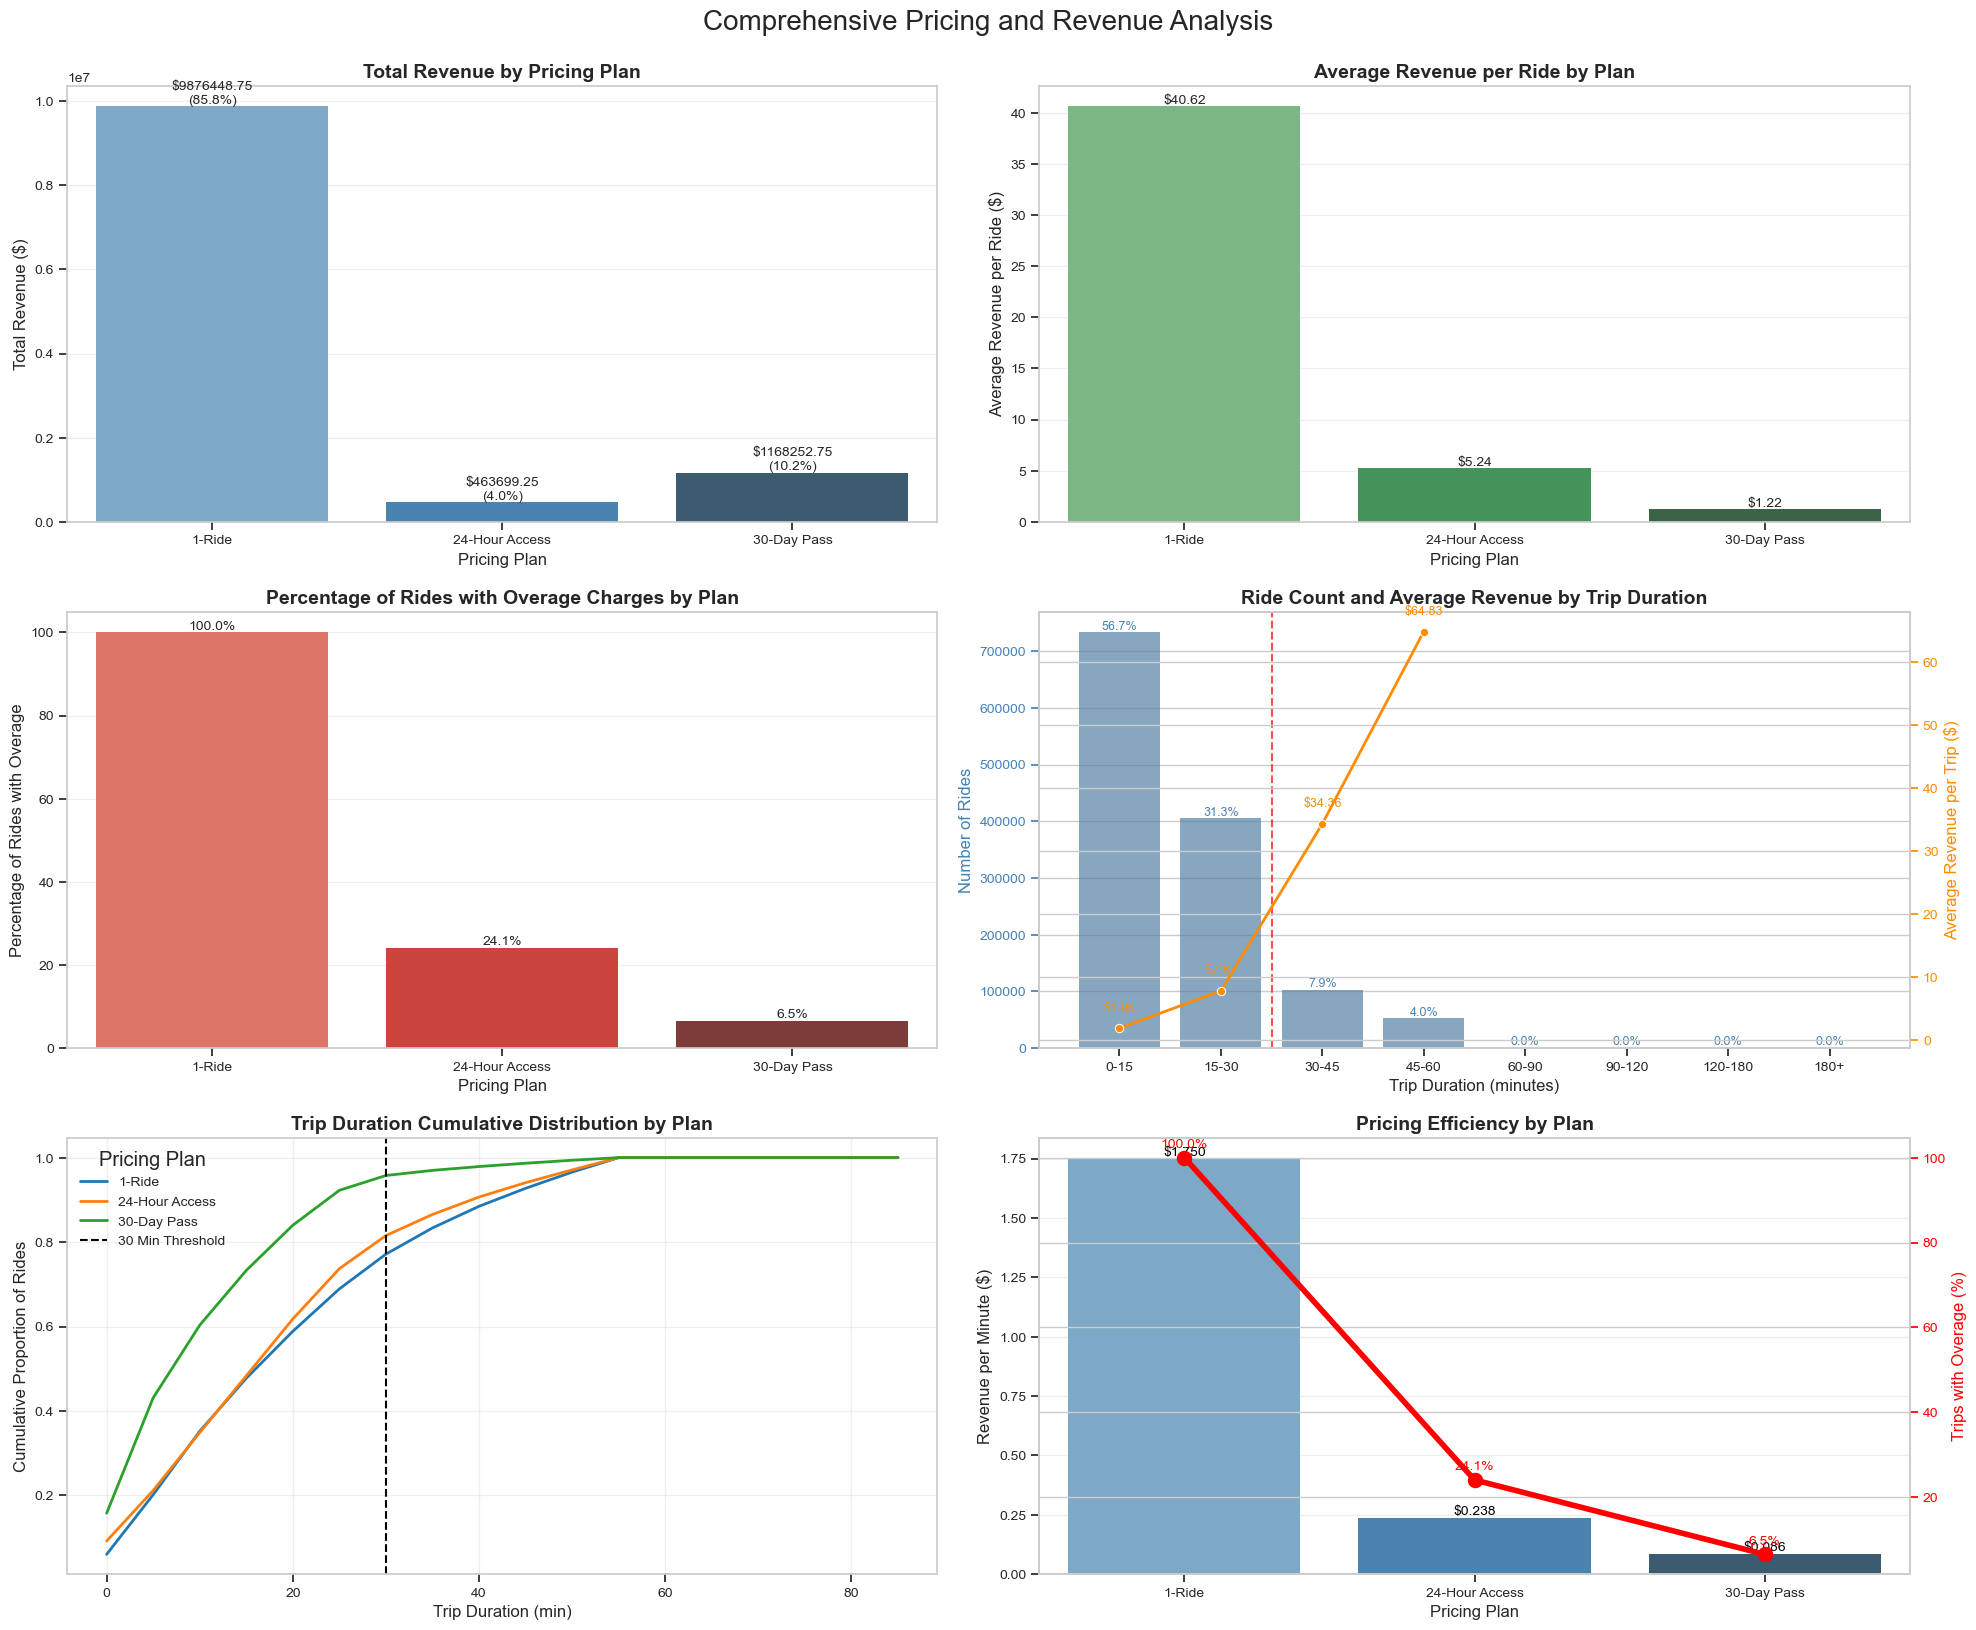

In [139]:
# Usage example
fig, plan_perf, overage_stats, trip_duration_bins, plan_efficiency = analyze_pricing_efficiency(df_pricing, plan_column='plan')

In [125]:
# 4. Fix for build_demand_prediction_model function
def build_demand_prediction_model(hourly_demand, top_stations, test_size=0.2, random_state=42):
    """
    Build and evaluate a bike demand prediction model with enhanced features
    
    Args:
        hourly_demand: DataFrame with hourly demand data
        top_stations: List of top station IDs to include
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (model, evaluation_metrics, feature_importances, plots)
    """
    import time
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    
    print("Preparing data for predictive modeling...")
    
    # First check if hourly_demand exists
    if hourly_demand is None or len(hourly_demand) == 0:
        raise ValueError("hourly_demand DataFrame is empty or None")
    
    # Make sure top_stations is valid
    if top_stations is None:
        # If not provided, use all stations
        top_stations = hourly_demand['start_station'].unique()
    
    # Check required columns
    required_cols = ['start_station', 'demand']
    time_cols = ['hour', 'day_of_week', 'month']
    
    # Check for time columns - need at least one
    if not any(col in hourly_demand.columns for col in time_cols):
        # Try to derive from other columns if possible
        if 'start_time' in hourly_demand.columns:
            # Extract time components
            hourly_demand['hour'] = hourly_demand['start_time'].dt.hour
            hourly_demand['day_of_week'] = hourly_demand['start_time'].dt.dayofweek
            hourly_demand['month'] = hourly_demand['start_time'].dt.month
        else:
            raise ValueError(f"Missing time columns in hourly_demand. Need at least one of: {time_cols}")
    
    # Filter to selected stations
    station_demand = hourly_demand[hourly_demand['start_station'].isin(top_stations)]
    
    if len(station_demand) == 0:
        raise ValueError(f"No data found for the provided stations. Check station IDs.")
    
    # Create additional features
    if 'day_of_week' in station_demand.columns:
        station_demand['is_weekend'] = station_demand['day_of_week'].isin([5, 6]).astype(int)
    else:
        station_demand['is_weekend'] = 0  # Default value
    
    if 'hour' in station_demand.columns:
        station_demand['is_rush_hour'] = station_demand['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
        station_demand['is_business_hours'] = station_demand['hour'].between(9, 17).astype(int)
        station_demand['is_night'] = station_demand['hour'].isin(range(22, 24)).astype(int)
        station_demand['hour_sin'] = np.sin(2 * np.pi * station_demand['hour']/24)
        station_demand['hour_cos'] = np.cos(2 * np.pi * station_demand['hour']/24)
    else:
        for col in ['is_rush_hour', 'is_business_hours', 'is_night', 'hour_sin', 'hour_cos']:
            station_demand[col] = 0  # Default values
    
    if 'day_of_week' in station_demand.columns:
        station_demand['day_sin'] = np.sin(2 * np.pi * station_demand['day_of_week']/7)
        station_demand['day_cos'] = np.cos(2 * np.pi * station_demand['day_of_week']/7)
    else:
        station_demand['day_sin'] = 0
        station_demand['day_cos'] = 0
    
    # Define features and target
    numeric_features = [col for col in [
        'hour', 'day_of_week', 'month', 
        'is_weekend', 'is_rush_hour', 'is_business_hours', 'is_night',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ] if col in station_demand.columns]
    
    categorical_features = ['start_station']
    
    # Make sure we have the target column
    if 'demand' not in station_demand.columns:
        raise ValueError("'demand' column not found in hourly_demand DataFrame")
    
    X = station_demand[numeric_features + categorical_features]
    y = station_demand['demand']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )
    
    # Define models to test
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=random_state),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state)
    }
    
    results = {}
    best_model = None
    best_score = -np.inf
    
    # Train and evaluate models
    print("\nTraining and evaluating models:")
    for name, model in models.items():
        start_time = time.time()
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        
        # Store results
        results[name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'cv_mean': cv_mean,
            'pipeline': pipeline,
            'y_pred': y_pred
        }
        
        # Update best model
        if cv_mean > best_score:
            best_model = name
            best_score = cv_mean
        
        duration = time.time() - start_time
        print(f"  {name}: R² = {r2:.4f}, CV R² = {cv_mean:.4f}, RMSE = {rmse:.2f}, Time = {duration:.2f}s")
    
    print(f"\nBest model: {best_model} (CV R² = {best_score:.4f})")
    
    # Further tune the best model
    best_pipeline = results[best_model]['pipeline']
    
    # Extract feature importances if available
    feature_importances = pd.DataFrame()
    if best_model in ['Random Forest', 'Gradient Boosting']:
        try:
            model = best_pipeline.named_steps['model']
            feature_names = (
                numeric_features + 
                preprocessor.named_transformers_['cat'].get_feature_names_out([categorical_features[0]]).tolist()
            )
            
            feature_importances = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
        except Exception as e:
            print(f"Warning: Could not extract feature importances: {e}")
    else:
        # For linear models, use coefficients as feature importance
        if best_model == 'Linear Regression':
            try:
                model = best_pipeline.named_steps['model']
                feature_names = (
                    numeric_features + 
                    preprocessor.named_transformers_['cat'].get_feature_names_out([categorical_features[0]]).tolist()
                )
                
                feature_importances = pd.DataFrame({
                    'feature': feature_names,
                    'importance': np.abs(model.coef_)
                }).sort_values('importance', ascending=False)
            except Exception as e:
                print(f"Warning: Could not extract coefficients: {e}")
    
    # Create evaluation visualizations
    plots = {}
    
    # 1. Actual vs Predicted Plot
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    ax1.scatter(y_test, results[best_model]['y_pred'], alpha=0.5)
    ax1.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    ax1.set_title('Actual vs Predicted Demand', fontsize=14)
    ax1.set_xlabel('Actual Demand', fontsize=12)
    ax1.set_ylabel('Predicted Demand', fontsize=12)
    ax1.grid(True, alpha=0.3)
    plots['actual_vs_predicted'] = fig1
    
    # 2. Error Distribution
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    errors = y_test - results[best_model]['y_pred']
    sns.histplot(errors, bins=50, kde=True, ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_title('Prediction Error Distribution', fontsize=14)
    ax2.set_xlabel('Prediction Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    plots['error_distribution'] = fig2
    
    # 3. Feature Importance
    if not feature_importances.empty:
        fig3, ax3 = plt.subplots(figsize=(12, 8))
        sns.barplot(
            data=feature_importances.head(15),
            x='importance',
            y='feature',
            palette='viridis',
            ax=ax3
        )
        ax3.set_title('Top 15 Features for Predicting Bike Demand', fontsize=14)
        ax3.set_xlabel('Importance', fontsize=12)
        ax3.set_ylabel('Feature', fontsize=12)
        plots['feature_importance'] = fig3
    
    # 4. Hourly Analysis
    # Get test results by hour
    test_results = pd.DataFrame({
        'actual': y_test,
        'predicted': results[best_model]['y_pred']
    })
    
    # Add hour information from original data if available
    if 'hour' in X_test.columns:
        test_results = test_results.reset_index()
        test_hours = X_test.reset_index()['hour']
        test_results['hour'] = test_hours
        
        # Group by hour
        hourly_results = test_results.groupby('hour').agg(
            actual_mean=('actual', 'mean'),
            predicted_mean=('predicted', 'mean'),
            mae=('actual', lambda x, y=test_results['predicted']: mean_absolute_error(
                x, y.loc[x.index]
            ))
        ).reset_index()
        
        fig4, ax4 = plt.subplots(figsize=(12, 6))
        ax4.plot(hourly_results['hour'], hourly_results['actual_mean'], 'o-', label='Actual')
        ax4.plot(hourly_results['hour'], hourly_results['predicted_mean'], 'o-', label='Predicted')
        ax4.set_title('Hourly Demand Patterns: Actual vs Predicted', fontsize=14)
        ax4.set_xlabel('Hour of Day', fontsize=12)
        ax4.set_ylabel('Average Demand', fontsize=12)
        ax4.set_xticks(range(24))
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        plots['hourly_comparison'] = fig4
        
    else:
        hourly_results = pd.DataFrame()
    
    # Combine all evaluation metrics
    evaluation = {
        'best_model': best_model,
        'metrics': {
            'mse': results[best_model]['mse'],
            'rmse': results[best_model]['rmse'],
            'mae': results[best_model]['mae'],
            'r2': results[best_model]['r2'],
            'cv_mean': results[best_model]['cv_mean']
        },
        'pipeline': best_pipeline,
        'feature_importances': feature_importances,
        'plots': plots,
        'hourly_results': hourly_results
    }
    
    print("\nModel training and evaluation complete!")
    
    return evaluation

# Usage example
# evaluation = build_demand_prediction_model(hourly_demand, top_stations, test_size=0.2, random_state=42)


# 5. Fix for create_bike_share_dashboard function
def create_bike_share_dashboard(df_merged, station_metrics, top_routes):
    """
    Create an interactive dashboard for bike share network analysis
    
    Args:
        df_merged: Combined trip and station DataFrame
        station_metrics: DataFrame with station metrics
        top_routes: DataFrame with top routes
    
    Returns:
        A Plotly figure object representing the dashboard
    """
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Check required columns in df_merged
    for df, name, required_cols in [
        (df_merged, 'df_merged', ['start_lon', 'start_lat']),
        (station_metrics, 'station_metrics', ['start_station', 'station_name', 'trips', 'lat', 'lon'])
    ]:
        if df is None or len(df) == 0:
            raise ValueError(f"{name} is empty or None")
        
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in {name}: {missing_cols}")
    
    # Check and create weekday column if needed
    if 'weekday' not in df_merged.columns and 'start_time' in df_merged.columns:
        df_merged['weekday'] = df_merged['start_time'].dt.day_name()
    
    # Check and create trip_hour column if needed
    if 'trip_hour' not in df_merged.columns:
        if 'start_time' in df_merged.columns:
            df_merged['trip_hour'] = df_merged['start_time'].dt.hour
        elif 'hour' in df_merged.columns:
            df_merged['trip_hour'] = df_merged['hour']
        else:
            # Create placeholder
            df_merged['trip_hour'] = 12  # Default to noon
    
    # Check for necessary columns in df_merged for time-based analysis
    if 'year' not in df_merged.columns or 'month' not in df_merged.columns:
        if 'start_time' in df_merged.columns:
            df_merged['year'] = df_merged['start_time'].dt.year
            df_merged['month'] = df_merged['start_time'].dt.month
    
    # Create a dashboard with multiple panels
    dashboard = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "mapbox"}, {"type": "bar"}],
            [{"type": "heatmap"}, {"type": "scatter"}]
        ],
        column_widths=[0.6, 0.4],
        row_heights=[0.6, 0.4],
        subplot_titles=[
            "Network Map", 
            "Top 10 Stations by Usage", 
            "Hourly Activity by Day of Week",
            "Monthly Trend"
        ]
    )
    
    # Panel 1: Network Map
    # Calculate boundaries
    min_lon = df_merged['start_lon'].min()
    max_lon = df_merged['start_lon'].max()
    min_lat = df_merged['start_lat'].min()
    max_lat = df_merged['start_lat'].max()
    
    # Add station markers
    dashboard.add_trace(
        go.Scattermapbox(
            lat=station_metrics['lat'],
            lon=station_metrics['lon'],
            text=station_metrics['station_name'] + '<br>Trips: ' + station_metrics['trips'].astype(str),
            mode='markers',
            marker=dict(
                size=np.sqrt(station_metrics['trips']) / 3 + 5,  # Square root for better visibility
                color=station_metrics['trips'],
                colorscale='Viridis',
                colorbar=dict(
                    title='Trips',
                    x=0.46,
                    y=0.8,
                    len=0.4
                ),
                opacity=0.8
            ),
            name='Stations',
            hovertemplate="%{text}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # Add top routes if provided
    if top_routes is not None and len(top_routes) > 0:
        for _, route in top_routes.iterrows():
            # Get start and end coordinates
            start_station = station_metrics[station_metrics['start_station'] == route['start_station']]
            end_station = station_metrics[station_metrics['start_station'] == route['end_station']]
            
            if not start_station.empty and not end_station.empty:
                dashboard.add_trace(
                    go.Scattermapbox(
                        mode='lines',
                        lon=[start_station.iloc[0]['lon'], end_station.iloc[0]['lon']],
                        lat=[start_station.iloc[0]['lat'], end_station.iloc[0]['lat']],
                        line=dict(
                            width=route['count'] / top_routes['count'].max() * 5 + 1,
                            color='red'
                        ),
                        opacity=0.7,
                        name=f"Route: {route['count']} trips",
                        hovertemplate="%{name}<extra></extra>",
                        showlegend=False
                    ),
                    row=1, col=1
                )
    
    # Panel 2: Top 10 Stations by Usage
    top_stations = station_metrics.nlargest(10, 'trips')
    dashboard.add_trace(
        go.Bar(
            x=top_stations['trips'],
            y=top_stations['station_name'],
            orientation='h',
            marker=dict(color=top_stations['trips'], colorscale='Viridis'),
            text=top_stations['trips'].astype(str),
            textposition='auto',
            hovertemplate="Station: %{y}<br>Trips: %{x}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # Panel 3: Hourly Activity by Day of Week
    try:
        # Create a crosstab of hour vs. day
        hourly_daily = pd.crosstab(
            index=df_merged['trip_hour'],
            columns=df_merged['weekday'],
            values=df_merged['trip_id'],
            aggfunc='count'
        )
        
        # Check for standard weekday names, if not present use what we have
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        # Only reindex if the weekdays match our standard order
        if all(day in hourly_daily.columns for day in weekday_order):
            hourly_daily = hourly_daily.reindex(columns=weekday_order)
        
        # Convert to matrix format for heatmap
        z_data = hourly_daily.values
        
        dashboard.add_trace(
            go.Heatmap(
                z=z_data,
                x=hourly_daily.columns.tolist(),
                y=list(hourly_daily.index),
                colorscale='Viridis',
                hovertemplate="Day: %{x}<br>Hour: %{y}<br>Trips: %{z}<extra></extra>"
            ),
            row=2, col=1
        )
    except Exception as e:
        print(f"Warning: Could not create hourly heatmap: {e}")
        # Add a blank placeholder instead
        dashboard.add_trace(
            go.Scatter(
                x=[0],
                y=[0],
                mode='text',
                text=['Hourly data not available'],
                textposition='middle center',
                textfont=dict(size=14)
            ),
            row=2, col=1
        )
    
    # Panel 4: Monthly Trend
    try:
        # Count rides by month and year
        monthly_rides = df_merged.groupby(['year', 'month']).size().reset_index(name='rides')
        monthly_rides['date'] = pd.to_datetime(monthly_rides[['year', 'month']].assign(day=1))
        
        dashboard.add_trace(
            go.Scatter(
                x=monthly_rides['date'],
                y=monthly_rides['rides'],
                mode='lines+markers',
                line=dict(width=2),
                marker=dict(size=8),
                hovertemplate="Date: %{x|%b %Y}<br>Trips: %{y}<extra></extra>"
            ),
            row=2, col=2
        )
    except Exception as e:
        print(f"Warning: Could not create monthly trend: {e}")
        # Add a blank placeholder instead
        dashboard.add_trace(
            go.Scatter(
                x=[0],
                y=[0],
                mode='text',
                text=['Monthly data not available'],
                textposition='middle center',
                textfont=dict(size=14)
            ),
            row=2, col=2
        )
    
    # Update mapbox settings
    dashboard.update_mapboxes(
        style="carto-positron",
        zoom=12,
        center=dict(lat=np.mean([min_lat, max_lat]), lon=np.mean([min_lon, max_lon]))
    )
    
    # Update layout
    dashboard.update_layout(
        title="Metro Bike Share Network Dashboard",
        mapbox_style="carto-positron",
        height=900,
        width=1200,
        showlegend=False,
        margin=dict(l=20, r=20, t=60, b=20),
        template="plotly_white"
    )
    
    # Update axes
    dashboard.update_xaxes(title_text="Number of Trips", row=1, col=2)
    dashboard.update_yaxes(title_text="Station", row=1, col=2)
    dashboard.update_xaxes(title_text="Day of Week", row=2, col=1)
    dashboard.update_yaxes(title_text="Hour of Day", row=2, col=1)
    dashboard.update_xaxes(title_text="Month", row=2, col=2)
    dashboard.update_yaxes(title_text="Number of Trips", row=2, col=2)
    
    return dashboard

In [127]:
# Usage example
dashboard = create_bike_share_dashboard(df_merged, station_metrics, top_routes)
dashboard

In [137]:
# 6. Fix for create_revenue_dashboard function
def create_revenue_dashboard(df_pricing):
    """
    Create an interactive dashboard for revenue analysis
    
    Args:
        df_pricing: DataFrame with pricing data
        
    Returns:
        A Plotly figure object representing the dashboard
    """
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Check if df_pricing exists and has required columns
    required_cols = ['plan', 'trip_cost', 'trip_id', 'duration']
    if df_pricing is None or len(df_pricing) == 0:
        raise ValueError("df_pricing is empty or None")
    
    missing_cols = [col for col in required_cols if col not in df_pricing.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in df_pricing: {missing_cols}")
    
    # Add overage_flag if it doesn't exist
    if 'overage_flag' not in df_pricing.columns:
        # Assume trips longer than 30 minutes have overage charges
        df_pricing['overage_flag'] = df_pricing['duration'] > 30
    
    # Add duration_bin if it doesn't exist
    if 'duration_bin' not in df_pricing.columns:
        bins = [0, 15, 30, 45, 60, 90, 120, float('inf')]
        labels = ['0-15', '15-30', '30-45', '45-60', '60-90', '90-120', '120+']
        df_pricing['duration_bin'] = pd.cut(df_pricing['duration'], bins=bins, labels=labels)
    
    # Create a dashboard with multiple panels
    dashboard = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "bar"}, {"type": "pie"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        subplot_titles=[
            "Revenue by Plan", 
            "Overage vs Base Revenue", 
            "Revenue by Trip Duration",
            "Trip Duration Distribution by Plan"
        ]
    )
    
    # Panel 1: Revenue by Plan
    plan_revenue = df_pricing.groupby('plan')['trip_cost'].sum().reset_index(name='total_revenue')
    total = plan_revenue['total_revenue'].sum()
    plan_revenue['percentage'] = (plan_revenue['total_revenue'] / total * 100).round(1)
    
    dashboard.add_trace(
        go.Bar(
            x=plan_revenue['plan'],
            y=plan_revenue['total_revenue'],
            marker=dict(color=plan_revenue['total_revenue'], colorscale='Blues'),
            text=[f"${x:.2f} ({y}%)" for x, y in zip(plan_revenue['total_revenue'], plan_revenue['percentage'])],
            textposition='auto',
            hovertemplate="Plan: %{x}<br>Revenue: $%{y:.2f}<br>%{text}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # Panel 2: Overage vs Base Revenue
    overage_revenue = df_pricing[df_pricing['overage_flag']]['trip_cost'].sum()
    base_revenue = total - overage_revenue
    
    dashboard.add_trace(
        go.Pie(
            labels=['Base Revenue', 'Overage Charges'],
            values=[base_revenue, overage_revenue],
            marker=dict(colors=['#3498db', '#e74c3c']),
            textinfo='label+percent',
            hoverinfo='label+value+percent',
            texttemplate="%{label}<br>%{percent}",
            hovertemplate="%{label}<br>$%{value:.2f}<br>%{percent}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # Panel 3: Revenue by Trip Duration
    duration_revenue = df_pricing.groupby('duration_bin').agg(
        total_revenue=('trip_cost', 'sum'),
        ride_count=('trip_id', 'count')
    ).reset_index()
    
    duration_revenue['avg_revenue'] = duration_revenue['total_revenue'] / duration_revenue['ride_count']
    duration_revenue['percentage'] = (duration_revenue['total_revenue'] / duration_revenue['total_revenue'].sum() * 100).round(1)
    
    dashboard.add_trace(
        go.Bar(
            x=duration_revenue['duration_bin'],
            y=duration_revenue['total_revenue'],
            marker=dict(color=duration_revenue['total_revenue'], colorscale='Greens'),
            text=[f"${x:.2f} ({y}%)" for x, y in zip(duration_revenue['total_revenue'], duration_revenue['percentage'])],
            textposition='auto',
            name='Total Revenue',
            hovertemplate="Duration: %{x}<br>Revenue: $%{y:.2f}<br>%{text}<extra></extra>"
        ),
        row=2, col=1
    )
    
    # Panel 4: Trip Duration Distribution by Plan
    # CDF of trip durations by plan
    bins = np.arange(0, 91, 5)
    
    for plan, grp in df_pricing.groupby('plan'):
        counts, bin_edges = np.histogram(grp['duration'], bins=bins)
        cdf = np.cumsum(counts) / counts.sum()
        
        dashboard.add_trace(
            go.Scatter(
                x=bins[:-1],
                y=cdf,
                mode='lines',
                name=plan,
                hovertemplate="Plan: %{name}<br>Duration: %{x} min<br>Cumulative %: %{y:.1%}<extra></extra>"
            ),
            row=2, col=2
        )
    
    # Add threshold line
    dashboard.add_shape(
        type="line",
        x0=30, y0=0,
        x1=30, y1=1,
        line=dict(color="red", width=2, dash="dash"),
        row=2, col=2
    )
    
    dashboard.add_annotation(
        x=30, y=0.5,
        text="30 min threshold",
        showarrow=True,
        arrowhead=1,
        row=2, col=2
    )
    
    # Update layout
    dashboard.update_layout(
        title="Metro Bike Share Revenue Dashboard",
        height=800,
        width=1200,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white"
    )
    
    # Update axes
    dashboard.update_xaxes(title_text="Pricing Plan", row=1, col=1)
    dashboard.update_yaxes(title_text="Total Revenue ($)", row=1, col=1)
    
    dashboard.update_xaxes(title_text="Trip Duration", row=2, col=1)
    dashboard.update_yaxes(title_text="Total Revenue ($)", row=2, col=1)
    
    dashboard.update_xaxes(title_text="Trip Duration (minutes)", row=2, col=2)
    dashboard.update_yaxes(title_text="Cumulative Proportion", row=2, col=2)
    
    return dashboard

# Usage example
dashboard = create_revenue_dashboard(df_pricing)
dashboard

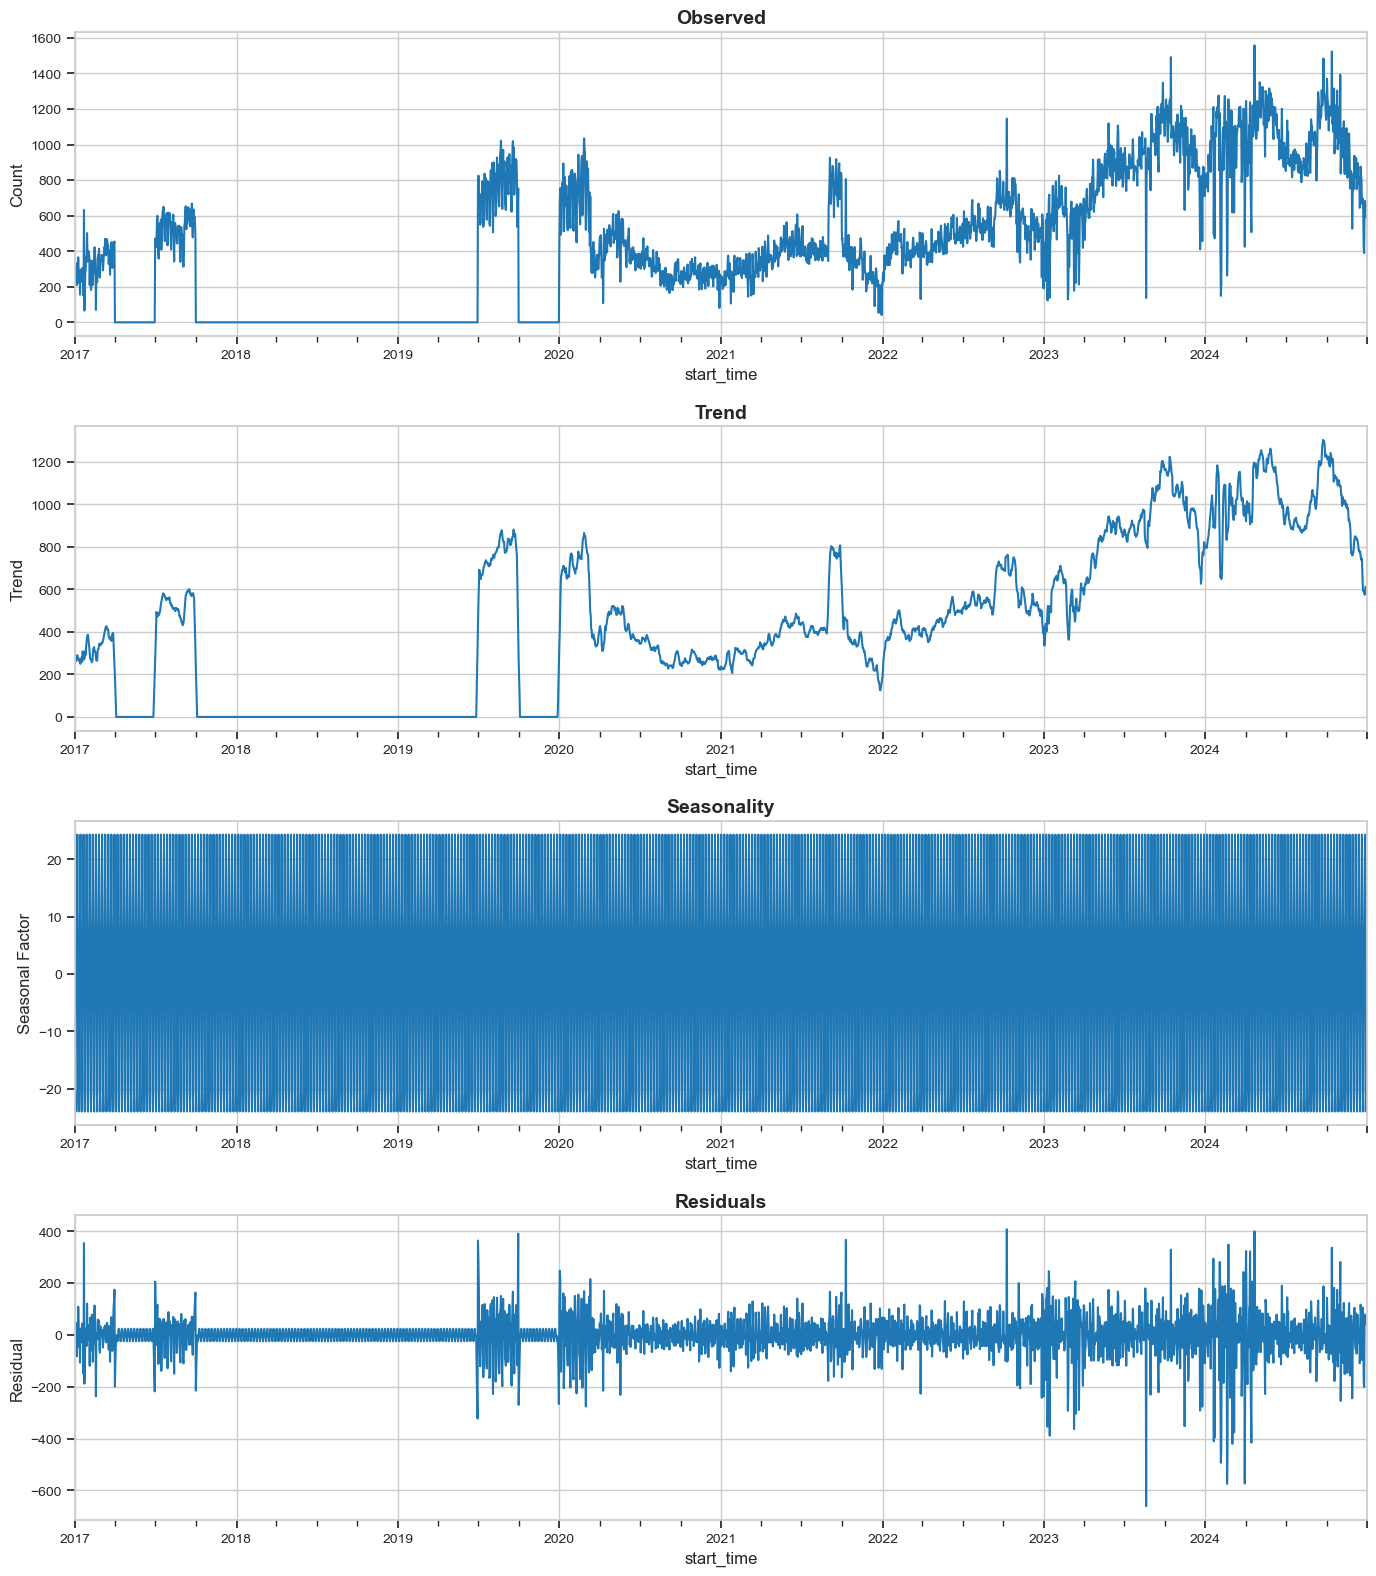

In [129]:
# 7. Fix for perform_time_series_analysis function
def perform_time_series_analysis(df, date_col='start_time', value_col='trip_id', freq='D'):
    """
    Perform time series decomposition analysis
    
    Args:
        df: DataFrame with time series data
        date_col: Column containing datetime values
        value_col: Column to analyze
        freq: Frequency for resampling ('D' for daily, 'M' for monthly, etc.)
        
    Returns:
        Decomposition results
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # Check required columns
    if date_col not in df.columns:
        raise ValueError(f"Date column '{date_col}' not found in DataFrame")
    
    if value_col not in df.columns:
        raise ValueError(f"Value column '{value_col}' not found in DataFrame")
    
    # Prepare time series data
    df_ts = df.copy()
    
    # Ensure datetime format
    df_ts[date_col] = pd.to_datetime(df_ts[date_col])
    
    # Aggregate by date
    time_series = df_ts.set_index(date_col).resample(freq).agg({value_col: 'count'})
    time_series = time_series.fillna(time_series.mean())
    
    # Check if data is suitable for decomposition
    if len(time_series) < 2 * max(4, time_series.index.freqstr.count('M') + 1):
        raise ValueError(f"Time series too short for decomposition with frequency {freq}")
    
    # Check for non-positive values before using multiplicative model
    if (time_series[value_col] <= 0).any():
        print("Warning: Data contains zero or negative values. Using additive model instead of multiplicative.")
        decomposition_model = 'additive'
    else:
        decomposition_model = 'multiplicative'
    
    # Perform decomposition
    decomposition = seasonal_decompose(time_series, model=decomposition_model)
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed', fontsize=14)
    ax1.set_ylabel('Count', fontsize=12)
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend', fontsize=14)
    ax2.set_ylabel('Trend', fontsize=12)
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality', fontsize=14)
    ax3.set_ylabel('Seasonal Factor', fontsize=12)
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residuals', fontsize=14)
    ax4.set_ylabel('Residual', fontsize=12)
    
    plt.tight_layout()
    
    return decomposition, time_series, fig

# Usage example
decomposition, time_series, fig = perform_time_series_analysis(df_merged, date_col='start_time', value_col='trip_id', freq='D')

  File "c:\Users\maqbu\miniconda3\envs\minimal_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\maqbu\miniconda3\envs\minimal_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\maqbu\miniconda3\envs\minimal_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\maqbu\miniconda3\envs\minimal_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


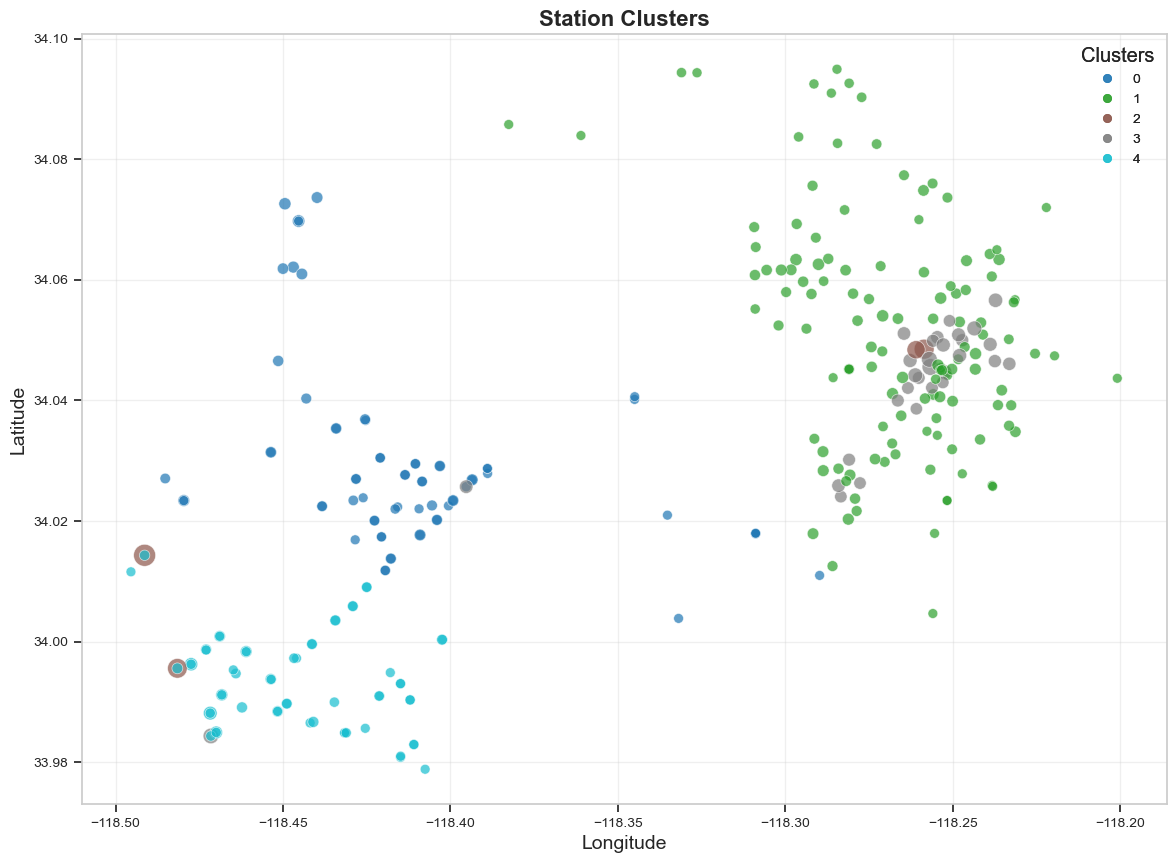

In [130]:
# 8. Fix for cluster_stations function
def cluster_stations(station_metrics, n_clusters=5):
    """
    Perform cluster analysis to identify station groups
    
    Args:
        station_metrics: DataFrame with station metrics
        n_clusters: Number of clusters to create
        
    Returns:
        DataFrame with cluster assignments
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    
    # Check required columns
    required_columns = ['trips', 'lat', 'lon']
    missing_columns = [col for col in required_columns if col not in station_metrics.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Add required columns if missing
    if 'total_docks' not in station_metrics.columns:
        print("Warning: 'total_docks' column not found. Adding placeholder values.")
        station_metrics['total_docks'] = 20  # Default placeholder
    
    if 'utilization_rate' not in station_metrics.columns:
        print("Computing 'utilization_rate' as trips/total_docks")
        station_metrics['utilization_rate'] = station_metrics['trips'] / station_metrics['total_docks']
    
    # Select features for clustering
    features = ['trips', 'total_docks', 'lat', 'lon', 'utilization_rate']
    
    # Create a copy and drop any rows with missing values
    station_data = station_metrics[features].dropna()
    
    if len(station_data) == 0:
        raise ValueError("No valid data for clustering after removing missing values")
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(station_data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Add cluster assignments to original data
    clustered_stations = station_metrics.copy()
    clustered_stations.loc[station_data.index, 'cluster'] = clusters
    
    # Calculate cluster statistics
    cluster_stats = clustered_stations.groupby('cluster').agg({
        'trips': ['mean', 'sum', 'count'],
        'total_docks': ['mean', 'sum'],
        'utilization_rate': ['mean', 'median', 'min', 'max']
    })
    
    # Visualize clusters on map
    plt.figure(figsize=(14, 10))
    
    # Create a scatter plot with cluster colors
    scatter = plt.scatter(
        clustered_stations['lon'], 
        clustered_stations['lat'],
        c=clustered_stations['cluster'],
        cmap='tab10',
        s=clustered_stations['trips'] / clustered_stations['trips'].max() * 200 + 50,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title('Station Clusters', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    return clustered_stations, cluster_stats, plt.gcf()

# Usage example
clustered_stations, cluster_stats, cluster_fig = cluster_stations(station_metrics, n_clusters=5)

Rider Composition:
  - Casual Riders: 25.4%
  - Subscribers: 74.3%
  - Other: 0.3%

Average Trip Duration:
  - Casual Riders: 23.0 min
  - Subscribers: 14.1 min
  - Other: 16.8 min


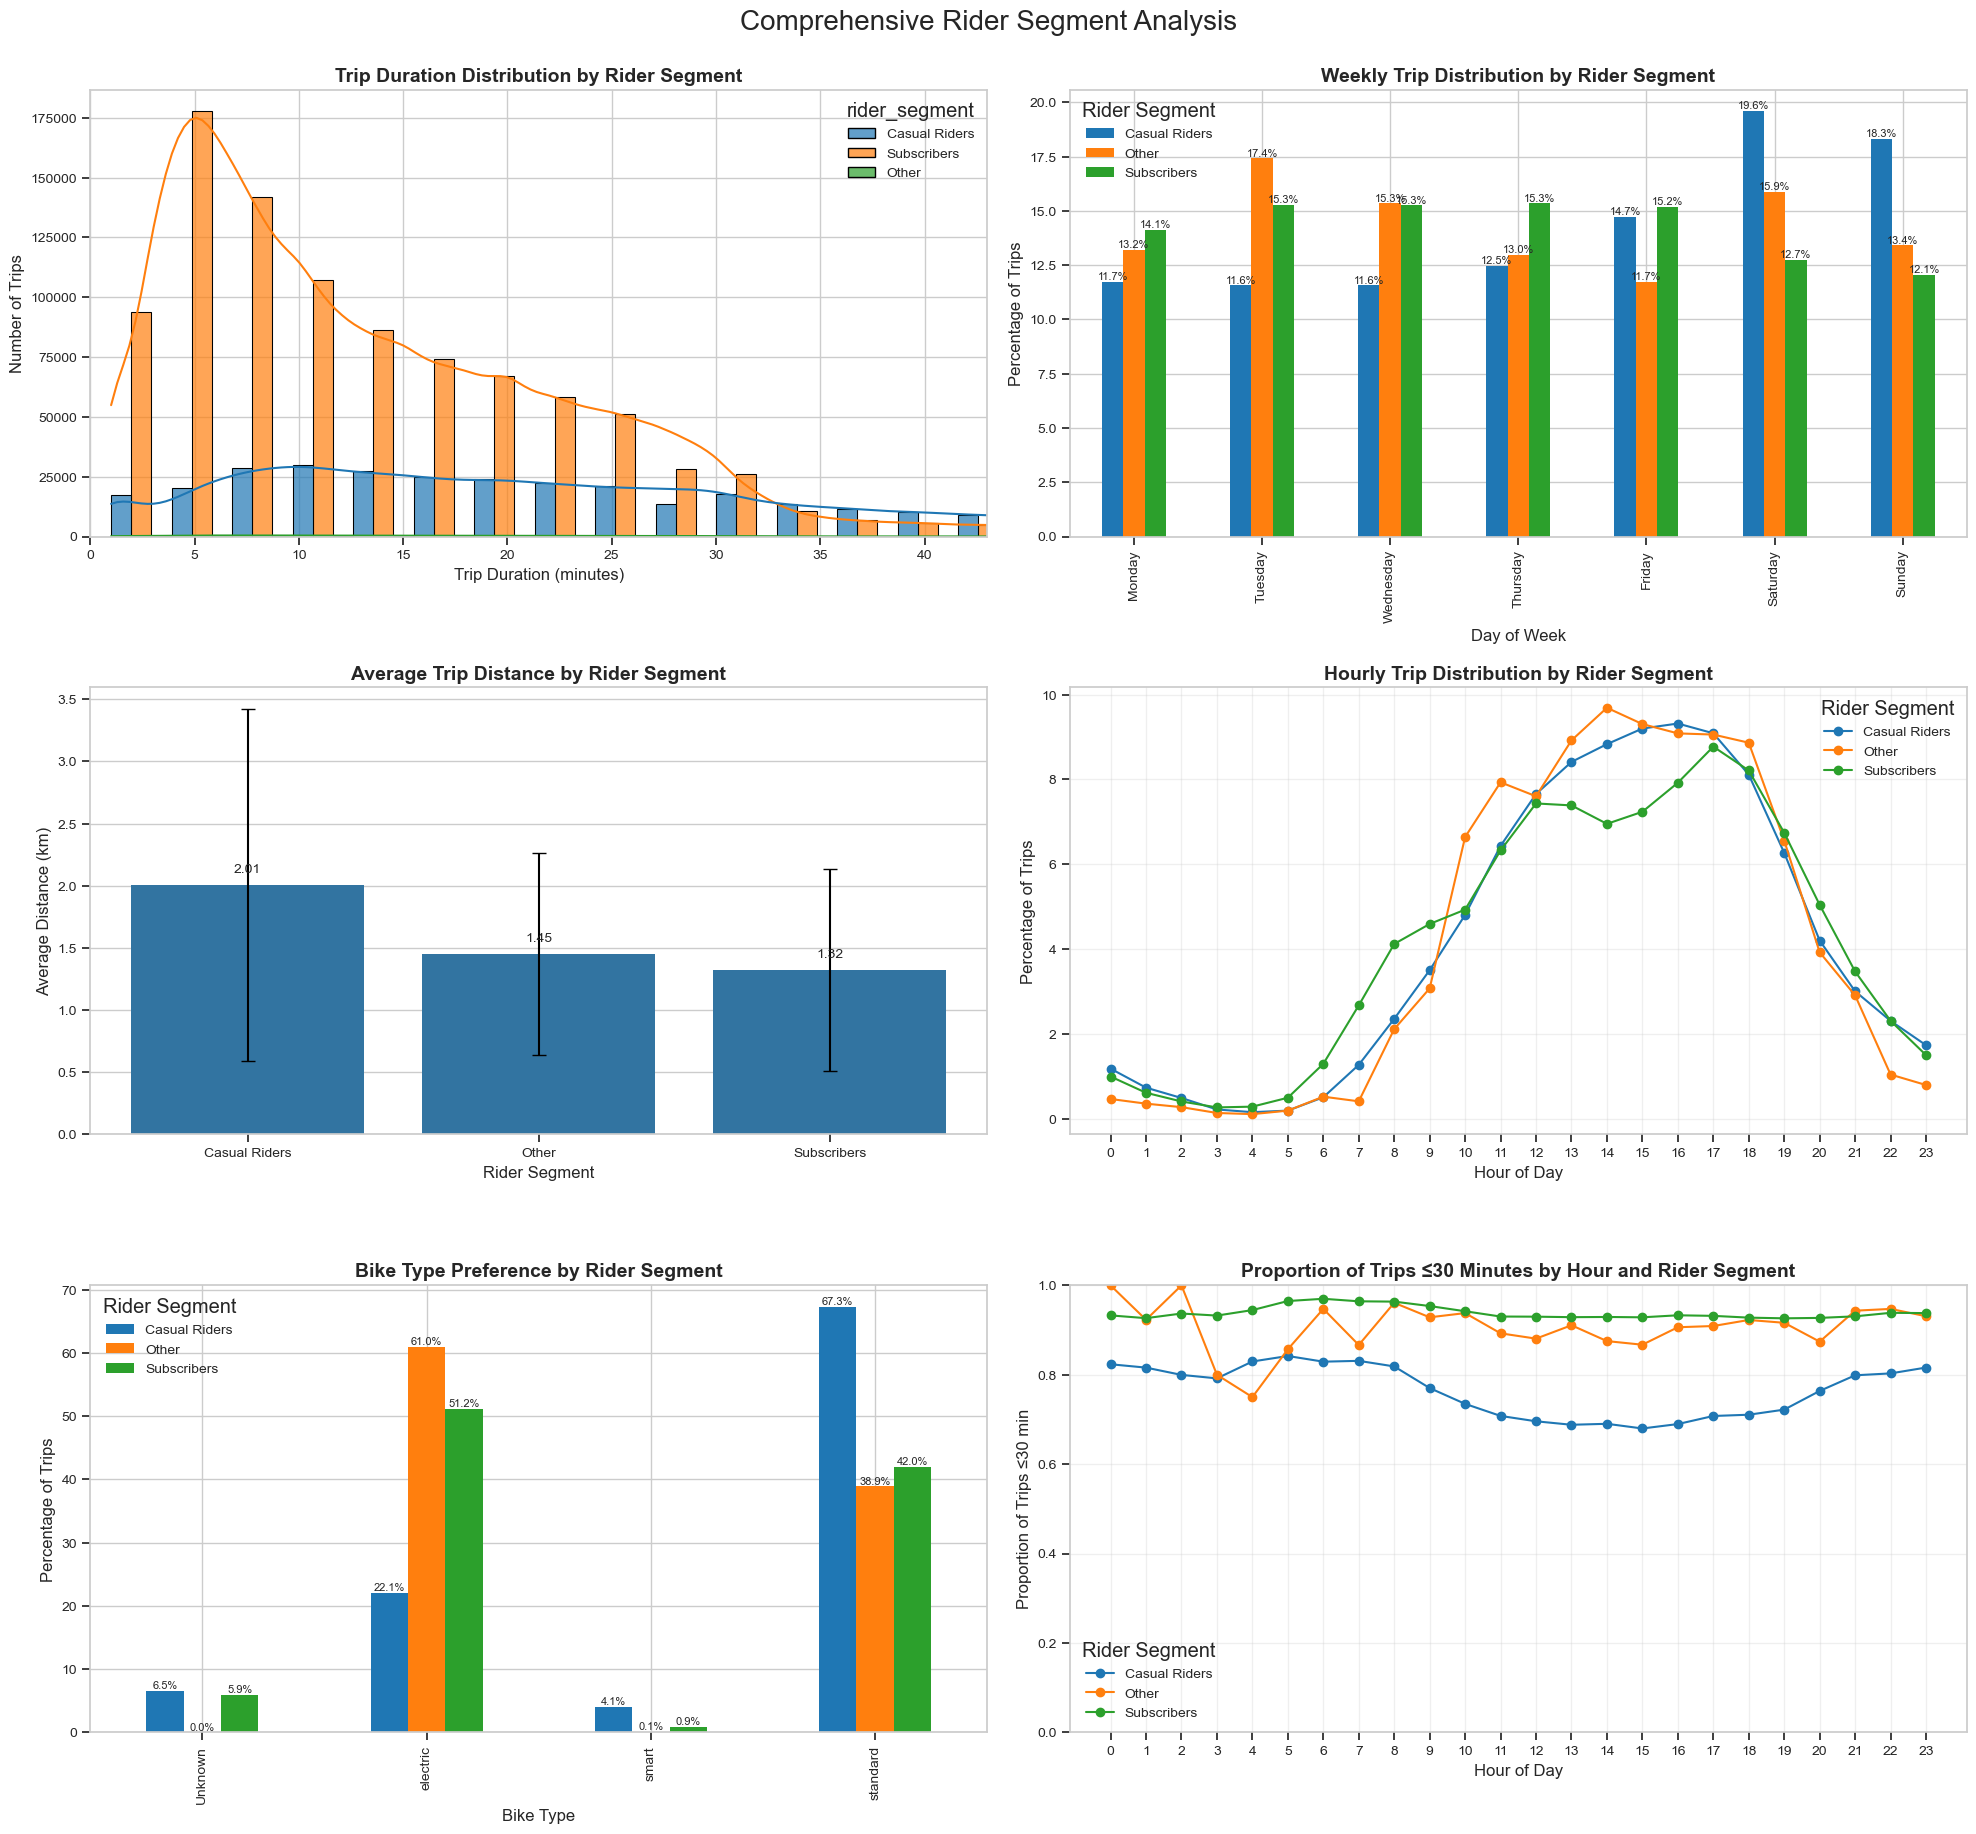

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_rider_segment_dashboard(df, segment_col='rider_segment'):
    """
    Create comprehensive rider segment comparison dashboard
    
    Args:
        df: DataFrame with trip data
        segment_col: Column name containing rider segment
    """
    # First, check if the segment column exists
    if segment_col not in df.columns:
        raise ValueError(f"Column '{segment_col}' not found in DataFrame. Available columns: {df.columns.tolist()}")
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 18))
    
    # 1. Trip Duration Distribution
    ax1 = plt.subplot(3, 2, 1)
    sns.histplot(
        data=df,
        x='duration',
        hue=segment_col,
        multiple='dodge',
        bins=20,
        alpha=0.7,
        kde=True,
        ax=ax1
    )
    
    ax1.set_title('Trip Duration Distribution by Rider Segment', fontsize=14)
    ax1.set_xlabel('Trip Duration (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Trips', fontsize=12)
    ax1.set_xlim(0, df['duration'].quantile(0.95))  # Limit x-axis for better visibility
    
    # Check if 'weekday' column exists, if not create it
    if 'weekday' not in df.columns and 'start_time' in df.columns:
        df['weekday'] = df['start_time'].dt.day_name()
    
    # 2. Weekly Distribution
    ax2 = plt.subplot(3, 2, 2)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Prepare data for plotting
    weekly_trips = df.groupby(['weekday', segment_col]).size().reset_index(name='trips')
    pivot_df = pd.pivot_table(
        weekly_trips, 
        values='trips',
        index='weekday',
        columns=segment_col,
        aggfunc='sum'
    )
    
    # Only reindex if the weekdays exist in the data
    if all(day in pivot_df.index for day in weekday_order):
        pivot_df = pivot_df.reindex(weekday_order)
    
    # Normalize to percentages
    normalized_pivot = pivot_df.div(pivot_df.sum(axis=0), axis=1) * 100
    
    # Plot
    normalized_pivot.plot(kind='bar', ax=ax2)
    ax2.set_title('Weekly Trip Distribution by Rider Segment', fontsize=14)
    ax2.set_xlabel('Day of Week', fontsize=12)
    ax2.set_ylabel('Percentage of Trips', fontsize=12)
    ax2.legend(title='Rider Segment')
    
    # Add percentage labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', fontsize=8)
    
    # 3. Trip Distance Comparison
    ax3 = plt.subplot(3, 2, 3)
    
    # Check if trip_distance_km exists
    distance_col = 'trip_distance_km'
    if distance_col not in df.columns and 'distance' in df.columns:
        distance_col = 'distance'  # Fall back to 'distance' if available
    
    # Calculate statistics
    distance_stats = df.groupby(segment_col)[distance_col].agg(['mean', 'median', 'std']).reset_index()
    
    # Create error bar plot
    sns.barplot(
        data=distance_stats,
        x=segment_col,
        y='mean',
        ax=ax3
    )
    
    # Add error bars
    for i, row in distance_stats.iterrows():
        ax3.errorbar(
            i, row['mean'], yerr=row['std']/2,
            fmt='none', color='black', capsize=5
        )
    
    ax3.set_title(f'Average Trip Distance by Rider Segment', fontsize=14)
    ax3.set_xlabel('Rider Segment', fontsize=12)
    ax3.set_ylabel(f'Average Distance ({distance_col.split("_")[-1] if "_" in distance_col else ""})', fontsize=12)
    
    # Add value labels
    for i, v in enumerate(distance_stats['mean']):
        ax3.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
    
    # 4. Hourly Pattern Comparison
    ax4 = plt.subplot(3, 2, 4)
    
    # Check for trip_hour or create it
    if 'trip_hour' not in df.columns and 'start_time' in df.columns:
        df['trip_hour'] = df['start_time'].dt.hour
    elif 'hour' in df.columns:
        df['trip_hour'] = df['hour']
    
    # Calculate hourly percentages by segment
    hourly_data = df.groupby([df['trip_hour'], segment_col]).size().reset_index(name='trips')
    hourly_pivot = hourly_data.pivot(index='trip_hour', columns=segment_col, values='trips')
    hourly_pct = hourly_pivot.div(hourly_pivot.sum(axis=0), axis=1) * 100
    
    # Plot
    hourly_pct.plot(
        kind='line',
        marker='o',
        ax=ax4
    )
    
    ax4.set_title('Hourly Trip Distribution by Rider Segment', fontsize=14)
    ax4.set_xlabel('Hour of Day', fontsize=12)
    ax4.set_ylabel('Percentage of Trips', fontsize=12)
    ax4.set_xticks(range(0, 24))
    ax4.legend(title='Rider Segment')
    ax4.grid(True, alpha=0.3)
    
    # 5. Bike Type Preference (if bike_type exists)
    ax5 = plt.subplot(3, 2, 5)
    
    if 'bike_type' in df.columns:
        # Calculate bike type preferences
        bike_pref = df.groupby(['bike_type', segment_col]).size().reset_index(name='trips')
        bike_pivot = pd.pivot_table(
            bike_pref,
            values='trips',
            index='bike_type',
            columns=segment_col,
            aggfunc='sum'
        )
        
        # Normalize to percentages
        bike_pct = bike_pivot.div(bike_pivot.sum(axis=0), axis=1) * 100
        
        # Plot
        bike_pct.plot(kind='bar', ax=ax5)
        ax5.set_title('Bike Type Preference by Rider Segment', fontsize=14)
        ax5.set_xlabel('Bike Type', fontsize=12)
        ax5.set_ylabel('Percentage of Trips', fontsize=12)
        ax5.legend(title='Rider Segment')
        
        # Add percentage labels
        for container in ax5.containers:
            ax5.bar_label(container, fmt='%.1f%%', fontsize=8)
    else:
        ax5.text(0.5, 0.5, "Bike type data not available", ha='center', va='center', fontsize=14)
        ax5.set_title('Bike Type Preference by Rider Segment (No Data)', fontsize=14)
    
    # 6. Proportion of Short Trips (under 30 min)
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate proportion of trips under 30 minutes by hour and segment
    df['under_30'] = df['duration'] <= 30
    
    # Get trip_hour if not created earlier
    if 'trip_hour' not in df.columns and 'start_time' in df.columns:
        df['trip_hour'] = df['start_time'].dt.hour
    elif 'hour' in df.columns:
        df['trip_hour'] = df['hour']
    
    under30_data = df.groupby(['trip_hour', segment_col])['under_30'].mean().reset_index(name='pct_under_30')
    under30_pivot = under30_data.pivot(index='trip_hour', columns=segment_col, values='pct_under_30')
    
    # Plot
    under30_pivot.plot(
        kind='line',
        marker='o',
        ax=ax6
    )
    
    ax6.set_title('Proportion of Trips ≤30 Minutes by Hour and Rider Segment', fontsize=14)
    ax6.set_xlabel('Hour of Day', fontsize=12)
    ax6.set_ylabel('Proportion of Trips ≤30 min', fontsize=12)
    ax6.set_xticks(range(0, 24))
    ax6.set_ylim(0, 1)
    ax6.legend(title='Rider Segment')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Rider Segment Analysis', fontsize=20, y=1.02)
    
    # Calculate and display key statistics
    segments = df[segment_col].unique()
    segment_durations = {}
    
    for seg in segments:
        segment_durations[seg] = df[df[segment_col] == seg]['duration'].mean()
    
    # Print rider composition
    print(f"Rider Composition:")
    for seg in segments:
        seg_pct = (df[segment_col] == seg).mean() * 100
        print(f"  - {seg}: {seg_pct:.1f}%")
    
    # Print average durations
    print("\nAverage Trip Duration:")
    for seg, duration in segment_durations.items():
        print(f"  - {seg}: {duration:.1f} min")
    
    return fig


# USAGE EXAMPLE:

# Step 1: Load your data (this should already be in your code)
# df_merged is assumed to be already loaded

# Step 2: Create the rider_segment column based on the available passholder_type column

# Method A: Use passholder_type directly
# create_rider_segment_dashboard(df_merged, segment_col='passholder_type')

# Method B: Create a simplified rider_segment column with just two categories
df_merged['rider_segment'] = df_merged['passholder_type'].map({
    'Monthly Pass': 'Subscribers',
    'Annual Pass': 'Subscribers',
    'Flex Pass': 'Subscribers',
    'Walk-up': 'Casual Riders',
    'One Day Pass': 'Casual Riders',
    'Three Day Pass': 'Casual Riders',
    'Staff Annual': 'Staff'
    # Add other mappings as needed
})

# Handle any unmapped values
df_merged['rider_segment'] = df_merged['rider_segment'].fillna('Other')

# Method C: If you already have the is_subscriber column with boolean values
# df_merged['rider_segment'] = df_merged['is_subscriber'].map({
#     True: 'Subscribers',
#     False: 'Casual Riders'
# })

# Step 3: Create the dashboard
dashboard = create_rider_segment_dashboard(df_merged, segment_col='rider_segment')

# Step 4: Display or save the dashboard
plt.show()  # To display in interactive environments

# To save to a file
# dashboard.savefig('rider_segment_dashboard.png', dpi=300, bbox_inches='tight')